In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
from scipy.interpolate import interp1d,RegularGridInterpolator
from scipy.optimize import least_squares,root
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_network
import ring_network as ring_network
import spat_ori_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ
import dmft

def addcbar(fig,ax,plot,size='5%',pad=0.05):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=size, pad=pad)
    cbar = fig.colorbar(plot, cax=cax, orientation='vertical')
    return cbar

# Solve ODE with Inverse Finite Differences vs Fourier Solution

In [3]:
T = 100
dt = 0.1
NT = int(np.round(T/dt))

ts = np.linspace(0,T,NT,endpoint=False)
ts[ts > T/2] = ts[ts > T/2] - T

os = np.fft.fftfreq(NT,dt)*2*np.pi

fts = 1/np.cosh(ts)
fos = np.real(np.fft.fft(fts)) * dt / np.sqrt(2*np.pi)

L = np.zeros((NT,NT))
L[(np.arange(NT), np.arange(NT))] = 1 + 2/dt**2
L[(np.arange(NT-1), np.arange(1,NT))] = -1/dt**2
L[(np.arange(1,NT), np.arange(NT-1))] = -1/dt**2
L[0,-1] = -1/dt**2
L[-1,0] = -1/dt**2

Lh = np.zeros((NT//2,NT//2))
Lh[(np.arange(NT//2), np.arange(NT//2))] = 1 + 2/dt**2
Lh[(np.arange(NT//2-1), np.arange(1,NT//2))] = -1/dt**2
Lh[(np.arange(1,NT//2), np.arange(NT//2-1))] = -1/dt**2
Lh[0,1] = -2/dt**2
Lh[-1,-1] = 1 + 1/dt**2

tord_idx = np.argsort(ts)
oord_idx = np.argsort(os)

Text(0, 0.5, '$\\left(1+\\omega^2\\right)^{-1}\\mathcal{F}\\left[\\mathrm{Sech}(t)\\right](\\omega)$')

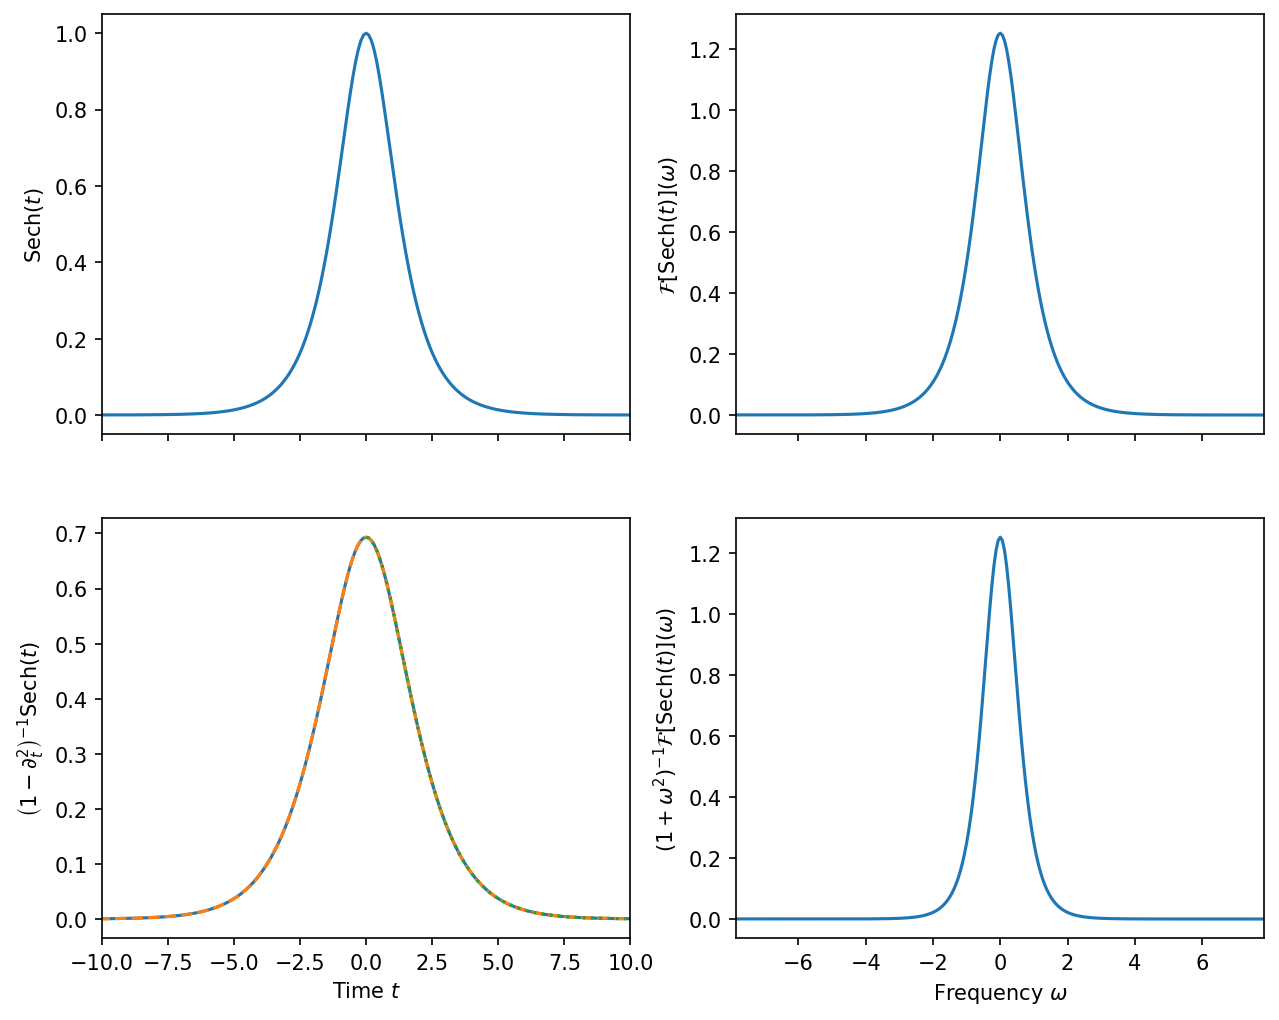

In [4]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=150,sharex='col')

axs[0,0].plot(ts[tord_idx],fts[tord_idx])
axs[0,1].plot(os[oord_idx],fos[oord_idx])
axs[1,1].plot(os[oord_idx],(fos/(1+os**2))[oord_idx])
axs[1,0].plot(ts[tord_idx],np.real(np.fft.ifft(fos/(1+os**2))[tord_idx] * np.sqrt(2*np.pi) / dt))
axs[1,0].plot(ts[tord_idx],np.linalg.solve(L,fts)[tord_idx],'--')
axs[1,0].plot(ts[:NT//2],np.linalg.solve(Lh,fts[:NT//2]),':')

axs[0,0].set_xlim(-10,10)
axs[0,1].set_xlim(-2.5*np.pi,2.5*np.pi)

axs[1,0].set_xlabel(r'Time $t$')
axs[1,1].set_xlabel(r'Frequency $\omega$')
axs[0,0].set_ylabel(r'$\mathrm{Sech}(t)$')
axs[0,1].set_ylabel(r'$\mathcal{F}\left[\mathrm{Sech}(t)\right](\omega)$')
axs[1,0].set_ylabel(r'$\left(1-\partial_t^2\right)^{-1}\mathrm{Sech}(t)$')
axs[1,1].set_ylabel(r'$\left(1+\omega^2\right)^{-1}\mathcal{F}\left[\mathrm{Sech}(t)\right](\omega)$')

# Solve More Complex ODE with Finite Differences

In [5]:
δ = np.zeros(NT)
δ[0] = 1/dt

L = np.zeros((NT,NT))
L[(np.arange(NT), np.arange(NT))] = 1 + 2/dt**2 - np.exp(-0.5*ts**2)# - 1.747*np.exp(-0.5*ts**2)# - 1.674/np.cosh(ts)
L[(np.arange(NT-1), np.arange(1,NT))] = -1/dt**2
L[(np.arange(1,NT), np.arange(NT-1))] = -1/dt**2
L[0,-1] = -1/dt**2
L[-1,0] = -1/dt**2

Text(0, 0.5, '$\\left(1+\\omega^2\\right)^{-1}\\mathcal{F}\\left[\\delta(t)\\right](\\omega)$')

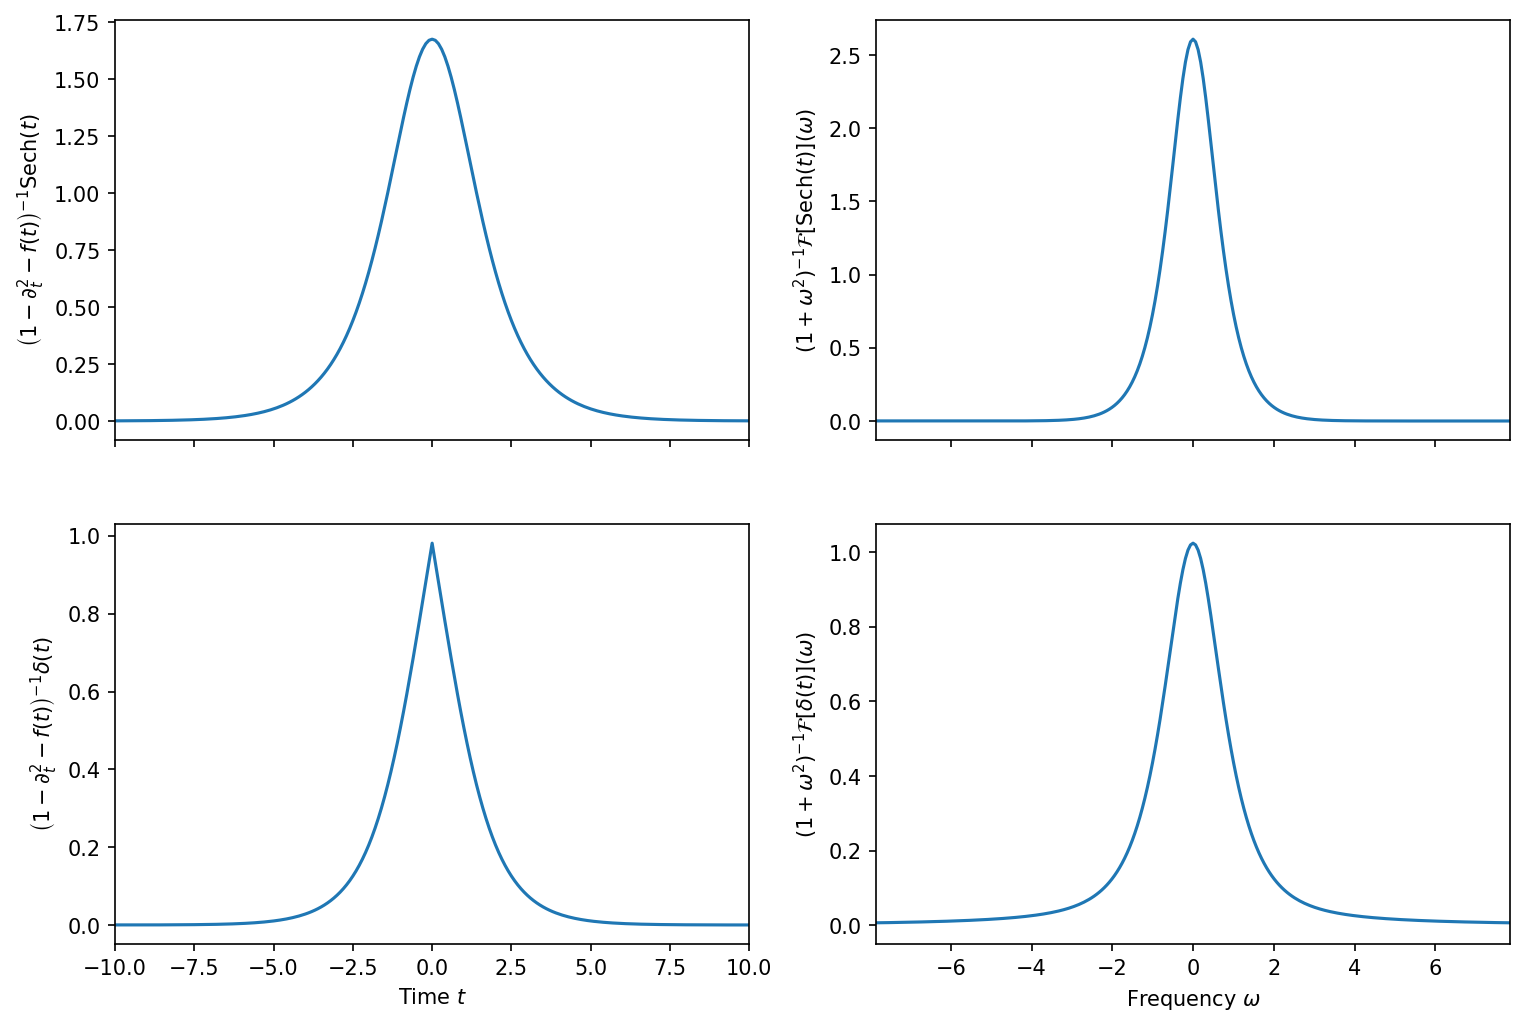

In [6]:
fig,axs = plt.subplots(2,2,figsize=(12,8),dpi=150,sharex='col')

axs[0,0].plot(ts[tord_idx],np.linalg.solve(L,fts)[tord_idx])
axs[0,1].plot(os[oord_idx],np.real(np.fft.fft(np.linalg.solve(L,fts)))[oord_idx] * dt / np.sqrt(2*np.pi))
axs[1,0].plot(ts[tord_idx],np.linalg.solve(L,δ)[tord_idx])
axs[1,1].plot(os[oord_idx],np.real(np.fft.fft(np.linalg.solve(L,δ)))[oord_idx] * dt / np.sqrt(2*np.pi))

axs[0,0].set_xlim(-10,10)
axs[0,1].set_xlim(-2.5*np.pi,2.5*np.pi)

axs[1,0].set_xlabel(r'Time $t$')
axs[1,1].set_xlabel(r'Frequency $\omega$')
axs[0,0].set_ylabel(r'$\left(1-\partial_t^2-f(t)\right)^{-1}\mathrm{Sech}(t)$')
axs[0,1].set_ylabel(r'$\left(1+\omega^2\right)^{-1}\mathcal{F}\left[\mathrm{Sech}(t)\right](\omega)$')
axs[1,0].set_ylabel(r'$\left(1-\partial_t^2-f(t)\right)^{-1}\delta(t)$')
axs[1,1].set_ylabel(r'$\left(1+\omega^2\right)^{-1}\mathcal{F}\left[\delta(t)\right](\omega)$')

# Calculate Values Needed for Linear Response

## Run DMFT on zero contrast fit, and perturb external rate

In [7]:
import dmft

id = None
if id is None:
    with open('./../results/best_fit.pkl', 'rb') as handle:
    # with open('./../results/dmft_grad_descent_id_None_n_75.pkl', 'rb') as handle:
    # with open('./../results/dmft_grad_descent_id_best_fit_v1_n_9.pkl', 'rb') as handle:
        res_dict = pickle.load(handle)
elif len(id)==2:
    with open('./../results/results_ring_{:d}.pkl'.format(
            id[0]), 'rb') as handle:
        res_dict = pickle.load(handle)[id[-1]]
else:
    with open('./../results/results_ring_perturb_njob-{:d}_nrep-{:d}_ntry-{:d}.pkl'.format(
            id[0],id[1],id[2]), 'rb') as handle:
        res_dict = pickle.load(handle)[id[-1]]
prms = res_dict['prms']
eX = res_dict['best_monk_eX']
bX = res_dict['best_monk_bX']
aXs = res_dict['best_monk_aXs']
K = prms['K']
SoriE = prms['SoriE']
SoriI = prms['SoriI']
SoriF = prms['SoriF']
J = prms['J']
beta = prms['beta']
gE = prms['gE']
gI = prms['gI']
hE = prms['hE']
hI = prms['hI']
L = prms['L']
CVL = prms['CVL']
    
ri = ric.Ricciardi()

In [8]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/3

δrX = 0.2

res_dict_init = dmft.run_first_stage_dmft(prms,bX,eX,'./../results',ri,Twrm,Tsav,dt,which='base',return_full=True)
res_dict_pert = dmft.run_first_stage_dmft(prms,bX+δrX,eX,'./../results',ri,Twrm,Tsav,dt,which='base',return_full=True)

0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 30.032303999999996 s
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 31.524995999999994 s


## Calculate mean and cross-covariance function of rate drives and derivatives

In [9]:
reload(dmft)

FE,FI,MFE,MFI,CFFE,CFFI = dmft.base_itp_moments('./../results')

tau = np.array([ri.tE,ri.tI],dtype=np.float32)
W = J*np.array([[1,-gE],[1./beta,-gI/beta]],dtype=np.float32)
Ks = np.array([K,K/4],dtype=np.float32)
H = bX*K*J*np.array([hE,hI/beta],dtype=np.float32)
eH = eX

muH = tau*H
SigH = (muH*eH)**2

muW = tau[:,None]*W*Ks
SigW = tau[:,None]**2*W**2*Ks

dmuHdξ = tau*K*J*np.array([hE,hI/beta],dtype=np.float32)
dSigHdξ = 2*muH*dmuHdξ*eH**2

In [10]:
from scipy.integrate import quad
sr2pi = np.sqrt(2*np.pi)

dmu = 1e-4

def MFPE(mu,Sig):
    return (MFE(mu+dmu,Sig)-MFE(mu-dmu,Sig))/(2*dmu)
def MFPI(mu,Sig):
    return (MFI(mu+dmu,Sig)-MFI(mu-dmu,Sig))/(2*dmu)

def MFPPE(mu,Sig):
    return (MFE(mu,Sig+dmu**2)-MFE(mu,Sig-dmu**2))/dmu**2
def MFPPI(mu,Sig):
    return (MFI(mu,Sig+dmu**2)-MFI(mu,Sig-dmu**2))/dmu**2

def CFFPE(mu,Sig,Cov):
    return (CFFE(mu+dmu,Sig,Cov)-CFFE(mu-dmu,Sig,Cov))/(4*dmu)
def CFFPI(mu,Sig,Cov):
    return (CFFI(mu+dmu,Sig,Cov)-CFFI(mu-dmu,Sig,Cov))/(4*dmu)

def CFFPPE(mu,Sig,Cov):
    return (CFFE(mu,np.fmax(Cov,Sig+dmu**2),Cov)-\
        CFFE(mu,np.fmax(Cov,Sig-dmu**2),Cov))/(np.fmax(Cov,Sig+dmu**2)-np.fmax(Cov,Sig-dmu**2))
def CFFPPI(mu,Sig,Cov):
    return (CFFI(mu,np.fmax(Cov,Sig+dmu**2),Cov)-\
        CFFI(mu,np.fmax(Cov,Sig-dmu**2),Cov))/(np.fmax(Cov,Sig+dmu**2)-np.fmax(Cov,Sig-dmu**2))

def CFPFPE(mu,Sig,Cov):
    return (CFFE(mu,Sig,np.fmin(Sig,Cov+dmu**2))-\
        CFFE(mu,Sig,np.fmin(Sig,Cov-dmu**2)))/(np.fmin(Sig,Cov+dmu**2)-np.fmin(Sig,Cov-dmu**2))
def CFPFPI(mu,Sig,Cov):
    return (CFFI(mu,Sig,np.fmin(Sig,Cov+dmu**2))-\
        CFFI(mu,Sig,np.fmin(Sig,Cov-dmu**2)))/(np.fmin(Sig,Cov+dmu**2)-np.fmin(Sig,Cov-dmu**2))

# def CFFPPEscal(mu,Sig,Cov):
#     if np.isclose(Cov,0):
#         return MFE(mu,Sig)*MFPPE(mu,Sig)
#     if np.isclose(Sig,0):
#         c = 0
#     else:
#         c = np.sign(Cov)*np.fmin(abs(Cov)/Sig,1)
#     return quad(lambda x: np.exp(-0.5*x**2)/sr2pi * MFE(mu+x*np.sqrt(c*Sig),(1-c)*Sig) *\
#         MFPPE(mu+x*np.sqrt(c*Sig),(1-c)*Sig),-8,8)[0]
# CFFPPE = np.vectorize(CFFPPEscal)
# def CFFPPIscal(mu,Sig,Cov):
#     if np.isclose(Cov,0):
#         return MFI(mu,Sig)*MFPPI(mu,Sig)
#     if np.isclose(Sig,0):
#         c = 0
#     else:
#         c = np.sign(Cov)*np.fmin(abs(Cov)/Sig,1)
#     return quad(lambda x: np.exp(-0.5*x**2)/sr2pi * MFI(mu+x*np.sqrt(c*Sig),(1-c)*Sig) *\
#         MFPPI(mu+x*np.sqrt(c*Sig),(1-c)*Sig),-8,8)[0]
# CFFPPI = np.vectorize(CFFPPIscal)

# def CFPFPEscal(mu,Sig,Cov):
#     if np.isclose(Cov,0):
#         return MFPE(mu,Sig)**2
#     if np.isclose(Sig,0):
#         c = 0
#     else:
#         c = np.sign(Cov)*np.fmin(abs(Cov)/Sig,1)
#     return quad(lambda x: np.exp(-0.5*x**2)/sr2pi * MFPE(mu+x*np.sqrt(c*Sig),(1-c)*Sig)**2,-8,8)[0]
# CFPFPE = np.vectorize(CFPFPEscal)
# def CFPFPIscal(mu,Sig,Cov):
#     if np.isclose(Cov,0):
#         return MFPI(mu,Sig)**2
#     if np.isclose(Sig,0):
#         c = 0
#     else:
#         c = np.sign(Cov)*np.fmin(abs(Cov)/Sig,1)
#     return quad(lambda x: np.exp(-0.5*x**2)/sr2pi * MFPI(mu+x*np.sqrt(c*Sig),(1-c)*Sig)**2,-8,8)[0]
# CFPFPI = np.vectorize(CFPFPIscal)

Text(0.5, 0, 'Pearson Corr Coeff')

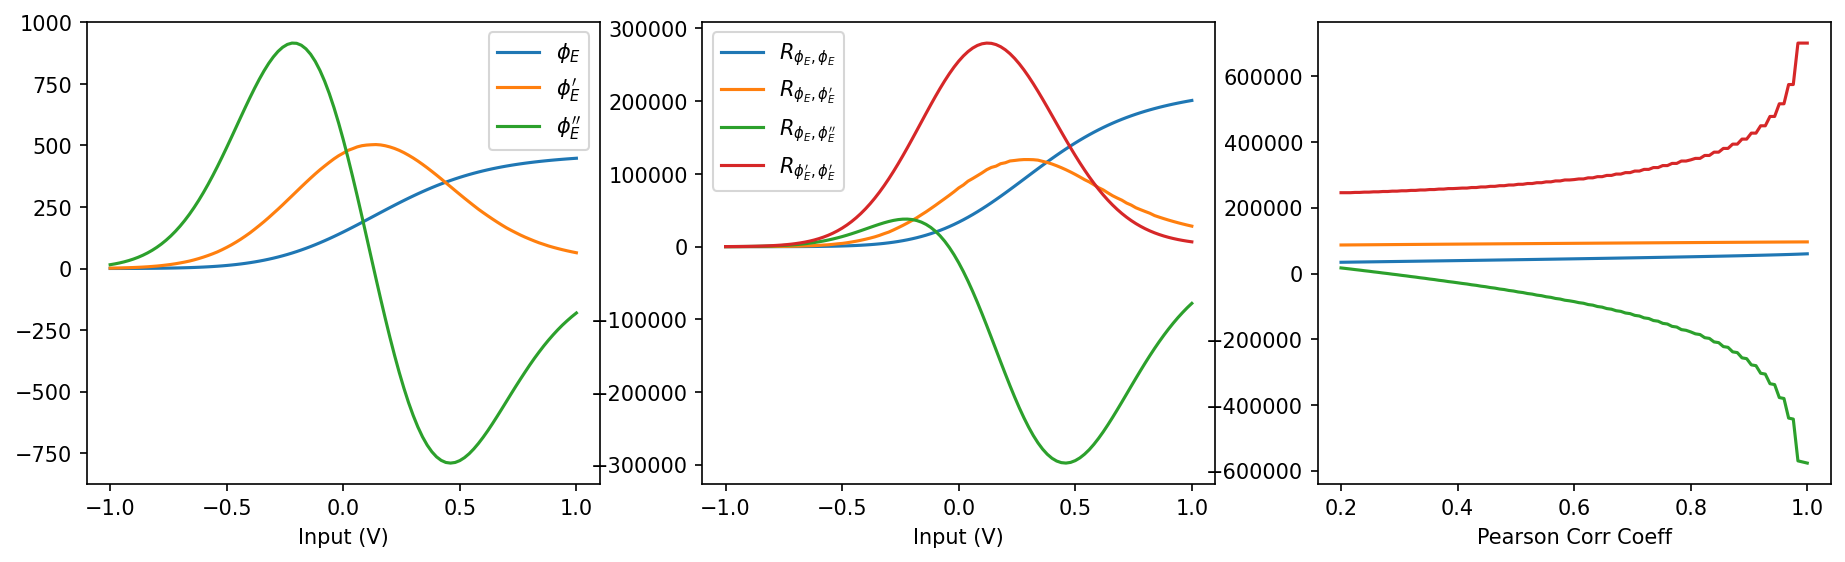

In [11]:
fig,axs = plt.subplots(1,3,figsize=(15,4),dpi=150)

mus = np.linspace(-1,1,101)
covs = 0.1*np.linspace(0.2,1.0,101)

axs[0].plot(mus,MFE(mus,0.1),label=r'$\phi_E$')
axs[0].plot(mus,MFPE(mus,0.1),label=r'$\phi^\prime_E$')
axs[0].plot(mus,MFPPE(mus,0.1),label=r'$\phi^{\prime\prime}_E$')

axs[1].plot(mus,CFFE(mus,0.1,0.05),label=r'$R_{\phi_E,\phi_E}$')
axs[1].plot(mus,CFFPE(mus,0.1,0.05),label=r'$R_{\phi_E,\phi^\prime_E}$')
axs[1].plot(mus,CFFPPE(mus,0.1,0.05),label=r'$R_{\phi_E,\phi^{\prime\prime}_E}$')
axs[1].plot(mus,CFPFPE(mus,0.1,0.05),label=r'$R_{\phi^\prime_E,\phi^\prime_E}$')

axs[2].plot(covs/0.1,CFFE(0.05,0.1,covs),label=r'$R_{\phi_E,\phi_E}$')
axs[2].plot(covs/0.1,CFFPE(0.05,0.1,covs),label=r'$R_{\phi_E,\phi^\prime_E}$')
axs[2].plot(covs/0.1,CFFPPE(0.05,0.1,covs),label=r'$R_{\phi_E,\phi^{\prime\prime}_E}$')
axs[2].plot(covs/0.1,CFPFPE(0.05,0.1,covs),label=r'$R_{\phi^\prime_E,\phi^\prime_E}$')

axs[0].legend()
axs[1].legend()

axs[0].set_xlabel(r'Input (V)')
axs[1].set_xlabel(r'Input (V)')
axs[2].set_xlabel(r'Pearson Corr Coeff')

In [12]:
def get_time_freq_func(f):
    N = f.shape[-1]
    new_shape = np.array(f.shape)
    new_shape[-1] += N-2
    ft = np.zeros(new_shape)
    ft[...,:N] = f
    ft[...,N:] = f[...,-1:1:-1]
    fo = np.real(np.fft.fft(ft))
    return ft,fo

def smooth_func(f,dt,fcut=17,beta=1):
    N = f.shape[-1]
    new_shape = np.array(f.shape)
    new_shape[-1] += N-2
    ft = np.zeros(new_shape)
    ft[...,:N] = f
    ft[...,N:] = f[...,-1:1:-1]
    fo = np.real(np.fft.fft(ft))
    fo *= 1/(1 + np.exp((np.abs(np.fft.fftfreq(2*(N-1),dt)) - fcut)*beta))
    return np.real(np.fft.ifft(fo))[...,:N]

In [13]:
r = res_dict_init['r']
Cr = res_dict_init['Cr']

φ = np.array([MFE(res_dict_init['mu'][0],res_dict_init['Sig'][0,0])[0],
              MFI(res_dict_init['mu'][1],res_dict_init['Sig'][1,0])[0]])
φp = np.array([MFPE(res_dict_init['mu'][0],res_dict_init['Sig'][0,0])[0],
               MFPI(res_dict_init['mu'][1],res_dict_init['Sig'][1,0])[0]])
φpp = np.array([MFPPE(res_dict_init['mu'][0],res_dict_init['Sig'][0,0])[0],
                MFPPI(res_dict_init['mu'][1],res_dict_init['Sig'][1,0])[0]])

Rφφ = np.array([[CFFE(res_dict_init['mu'][0],res_dict_init['Sig'][0,0],cov)[0] for cov in res_dict_init['Sig'][0]],
                [CFFI(res_dict_init['mu'][1],res_dict_init['Sig'][1,0],cov)[0] for cov in res_dict_init['Sig'][1]]])
Rφφp = np.array([[CFFPE(res_dict_init['mu'][0],res_dict_init['Sig'][0,0],cov)[0] for cov in res_dict_init['Sig'][0]],
                 [CFFPI(res_dict_init['mu'][1],res_dict_init['Sig'][1,0],cov)[0] for cov in res_dict_init['Sig'][1]]])
Rφφpp = np.array([[CFFPPE(res_dict_init['mu'][0],res_dict_init['Sig'][0,0],cov)[0] for cov in res_dict_init['Sig'][0]],
                  [CFFPPI(res_dict_init['mu'][1],res_dict_init['Sig'][1,0],cov)[0] for cov in res_dict_init['Sig'][1]]])
Rφpφp = np.array([[CFPFPE(res_dict_init['mu'][0],res_dict_init['Sig'][0,0],cov)[0] for cov in res_dict_init['Sig'][0]],
                  [CFPFPI(res_dict_init['mu'][1],res_dict_init['Sig'][1,0],cov)[0] for cov in res_dict_init['Sig'][1]]])

Rφφpp = smooth_func(Rφφpp,dt)
Rφpφp = smooth_func(Rφpφp,dt)

In [14]:
print(φ)
print(φp)
print(φpp)
print(Rφφ[:,0])
print(Rφφp[:,0])
print(Rφφpp[:,0])
print(Rφpφp[:,0])

[12.61320777 21.20005583]
[1463.85751976 1635.89724411]
[113328.76598029  90271.41984568]
[ 425.48369684 2105.09001648]
[ 34713.12386014 101407.66418112]
[1115578.64989337  590120.32672569]
[3495872.04108429 7060918.69437004]


## Construct matrices and vectors to solve for linear suceptibilities

In [15]:
NP = res_dict_init['Sig'].shape[0]
NT = res_dict_init['Sig'].shape[1]
dt = 0.01/3
ts = np.arange(NT)*dt

L = np.zeros((NT,NT))
L[(np.arange(NT), np.arange(NT))] = -2/dt**2
L[(np.arange(NT-1), np.arange(1,NT))] = 1/dt**2
L[(np.arange(1,NT), np.arange(NT-1))] = 1/dt**2
L[0,1] = 2/dt**2
L[-1,-1] = -1/dt**2
# L[-1,-2] = 2/dt**2

δ = np.concatenate(([1],np.zeros(NT-1)))

A = np.eye(NP) - φp[:,None] * muW
B = -0.5 * φpp[:,None,None] * SigW[:,:,None] * δ[None,None,:]
C = -2 * Rφφp[:,:,None] * muW[:,None,:]
D = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
    - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:] +\
    - Rφpφp[:,:,None,None] * SigW[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
    - Rφφpp[:,:,None,None] * SigW[:,None,:,None] * δ[None,None,None,:]
D0dis = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
    - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:]
D1dis = - Rφpφp[:,:,None,None] * SigW[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
    - Rφφpp[:,:,None,None] * SigW[:,None,:,None] * δ[None,None,None,:]

E = φp * dmuHdξ + 0.5 * φpp * dSigHdξ
F = 2 * Rφφp * dmuHdξ[:,None] + (Rφφpp + Rφpφp) * dSigHdξ[:,None]

In [16]:
print(A)
print(B[:,:,0])
print(C[:,0,:])
print(D[:,0,:,0])
print()
print(E)
print(F[:,0])

[[ -1.28870839   3.40446534]
 [-11.18825116   8.29033883]]
[[-0.00027703 -0.00245189]
 [-0.00422243 -0.00717123]]
[[ -108.54638058   161.46329171]
 [-1387.09741141   903.84189471]]
[[60.97745302 -0.19953899]
 [-0.71575231 11.78439088]]

[11.39572194  1.65154683]
[543.12768741 204.80399018]


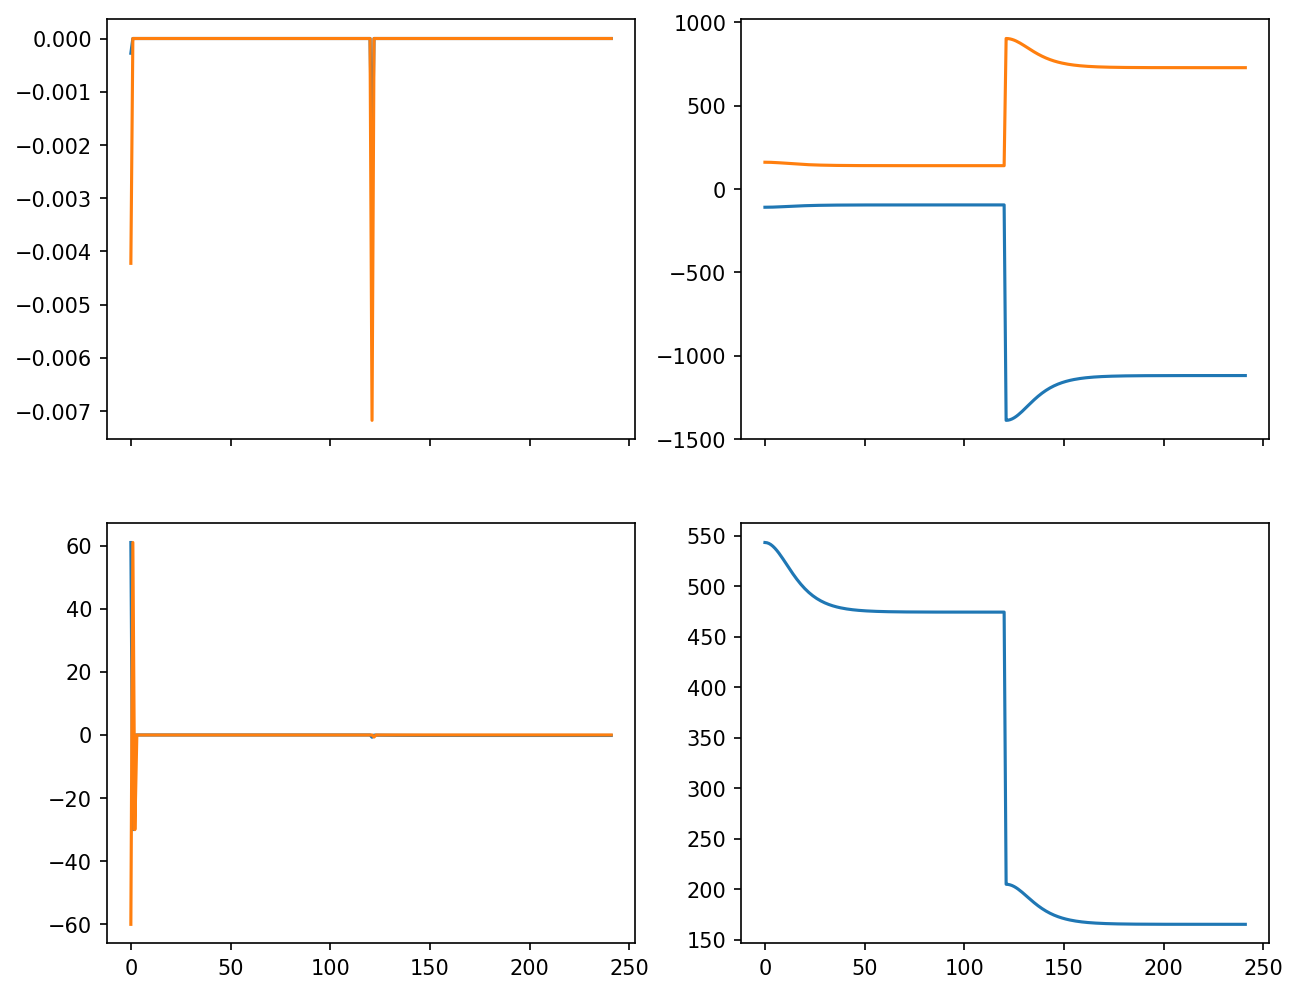

In [17]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=150,sharex=True)

axs[0,0].plot(B.reshape(NP,-1).T)
axs[0,1].plot(C.reshape(-1,NP))
axs[1,0].plot(D.reshape((NP*NT,NP*NT))[:,:2])
axs[1,1].plot(F.reshape(NP*NT))

## Verify that rate moments satisfy self-consistent equations

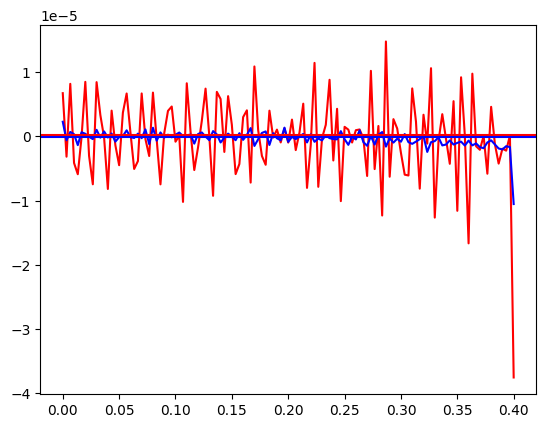

In [18]:
plt.plot(ts,((np.eye(NT) - (tau[0]**2 * L - tau[0] * L*dt))@Cr[0] - Rφφ[0])/Cr[0],c='r')
plt.plot(ts,((np.eye(NT) - (tau[1]**2 * L - tau[1] * L*dt))@Cr[1] - Rφφ[1])/Cr[1],c='b')
plt.axhline((r[0] - φ[0])/r[0],c='r')
plt.axhline((r[1] - φ[1])/r[1],c='b')

In [19]:
M = np.block([[A,B.reshape(NP,NP*NT)],[C.reshape(NP*NT,NP),D.reshape(NP*NT,NP*NT)]])
f = np.concatenate([E,F.flatten()])

M0dis = np.block([[A,np.zeros_like(B).reshape(NP,NP*NT)],[C.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])
M1dis = np.block([[np.zeros_like(A),B.reshape(NP,NP*NT)],[np.zeros_like(C).reshape(NP*NT,NP),D1dis.reshape(NP*NT,NP*NT)]])

In [20]:
dmdξ = np.linalg.solve(M,f)
drdξ = dmdξ[:NP]
dCrdξ = dmdξ[NP:].reshape(NP,NT)

dmdξ0dis = np.linalg.solve(M0dis,f)
drdξ0dis = dmdξ0dis[:NP]
dCrdξ0dis = dmdξ0dis[NP:].reshape(NP,NT)

dmdξ1dis = dmdξ0dis - np.linalg.solve(M0dis,M1dis@np.linalg.solve(M0dis,dmdξ0dis))
drdξ1dis = dmdξ1dis[:NP]
dCrdξ1dis = dmdξ1dis[NP:].reshape(NP,NT)

Text(0, 0.5, 'Change in Moments, No Weight Disorder')

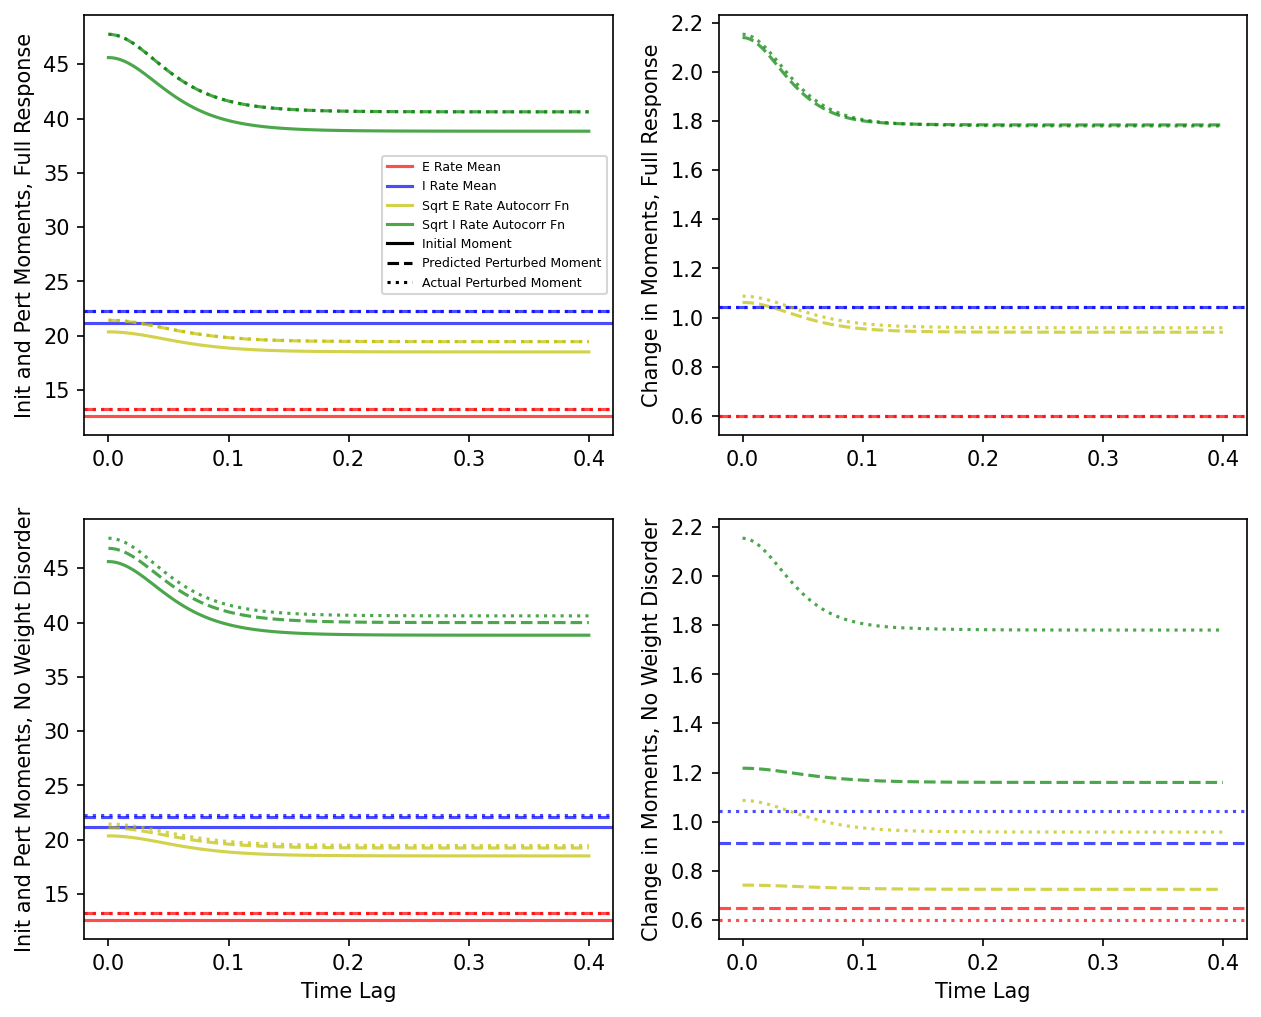

In [21]:
fig,axs= plt.subplots(2,2,figsize=(10,8),dpi=150)

axs[0,0].axhline(r[0],c='r',alpha=0.7,label='E Rate Mean')
axs[0,0].axhline(r[1],c='b',alpha=0.7,label='I Rate Mean')
axs[0,0].plot(ts,np.sqrt(Cr[0]),c='y',alpha=0.7,label='Sqrt E Rate Autocorr Fn')
axs[0,0].plot(ts,np.sqrt(Cr[1]),c='g',alpha=0.7,label='Sqrt I Rate Autocorr Fn')

axs[0,0].axhline(r[0] + drdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,0].axhline(r[1] + drdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Cr[0] + dCrdξ[0]*δrX),c='y',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Cr[1] + dCrdξ[1]*δrX),c='g',ls='--',alpha=0.7)

axs[0,0].axhline(res_dict_pert['r'][0],c='r',ls=':',alpha=0.7)
axs[0,0].axhline(res_dict_pert['r'][1],c='b',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Cr'][0]),c='y',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Cr'][1]),c='g',ls=':',alpha=0.7)

axs[0,0].plot(np.nan,np.nan,c='k',ls='-',label='Initial Moment')
axs[0,0].plot(np.nan,np.nan,c='k',ls='--',label='Predicted Perturbed Moment')
axs[0,0].plot(np.nan,np.nan,c='k',ls=':',label='Actual Perturbed Moment')

axs[0,0].legend(fontsize=6)

axs[0,1].axhline(drdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,1].axhline(drdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(Cr[0] + dCrdξ[0]*δrX) - np.sqrt(Cr[0]),c='y',ls='--',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(Cr[1] + dCrdξ[1]*δrX) - np.sqrt(Cr[1]),c='g',ls='--',alpha=0.7)

axs[0,1].axhline(res_dict_pert['r'][0] - r[0],c='r',ls=':',alpha=0.7)
axs[0,1].axhline(res_dict_pert['r'][1] - r[1],c='b',ls=':',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(res_dict_pert['Cr'][0]) - np.sqrt(Cr[0]),c='y',ls=':',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(res_dict_pert['Cr'][1]) - np.sqrt(Cr[1]),c='g',ls=':',alpha=0.7)

axs[1,0].axhline(r[0],c='r',alpha=0.7,label='Initial E Rate Mean')
axs[1,0].axhline(r[1],c='b',alpha=0.7,label='Initial I Rate Mean')
axs[1,0].plot(ts,np.sqrt(Cr[0]),c='y',alpha=0.7,label='Initial Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(Cr[1]),c='g',alpha=0.7,label='Initial Sqrt I Rate Autocorr Fn')

axs[1,0].axhline(r[0] + drdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7,label='Predicted Perturbed E Rate Mean')
axs[1,0].axhline(r[1] + drdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7,label='Predicted Perturbed I Rate Mean')
axs[1,0].plot(ts,np.sqrt(Cr[0] + dCrdξ0dis[0]*δrX),c='y',ls='--',alpha=0.7,label='Predicted Perturbed Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(Cr[1] + dCrdξ0dis[1]*δrX),c='g',ls='--',alpha=0.7,label='Predicted Perturbed Sqrt I Rate Autocorr Fn')

axs[1,0].axhline(res_dict_pert['r'][0],c='r',ls=':',alpha=0.7,label='Perturbed E Rate Mean')
axs[1,0].axhline(res_dict_pert['r'][1],c='b',ls=':',alpha=0.7,label='Perturbed I Rate Mean')
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Cr'][0]),c='y',ls=':',alpha=0.7,label='Perturbed Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Cr'][1]),c='g',ls=':',alpha=0.7,label='Perturbed Sqrt I Rate Autocorr Fn')

axs[1,1].axhline(drdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7)
axs[1,1].axhline(drdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(Cr[0] + dCrdξ0dis[0]*δrX) - np.sqrt(Cr[0]),c='y',ls='--',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(Cr[1] + dCrdξ0dis[1]*δrX) - np.sqrt(Cr[1]),c='g',ls='--',alpha=0.7)

axs[1,1].axhline(res_dict_pert['r'][0] - r[0],c='r',ls=':',alpha=0.7)
axs[1,1].axhline(res_dict_pert['r'][1] - r[1],c='b',ls=':',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(res_dict_pert['Cr'][0]) - np.sqrt(Cr[0]),c='y',ls=':',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(res_dict_pert['Cr'][1]) - np.sqrt(Cr[1]),c='g',ls=':',alpha=0.7)

axs[1,0].set_xlabel('Time Lag')
axs[1,1].set_xlabel('Time Lag')
axs[0,0].set_ylabel('Init and Pert Moments, Full Response')
axs[0,1].set_ylabel('Change in Moments, Full Response')
axs[1,0].set_ylabel('Init and Pert Moments, No Weight Disorder')
axs[1,1].set_ylabel('Change in Moments, No Weight Disorder')

Text(0, 0.5, 'Change in Moments, 1st Order Weight Disorder')

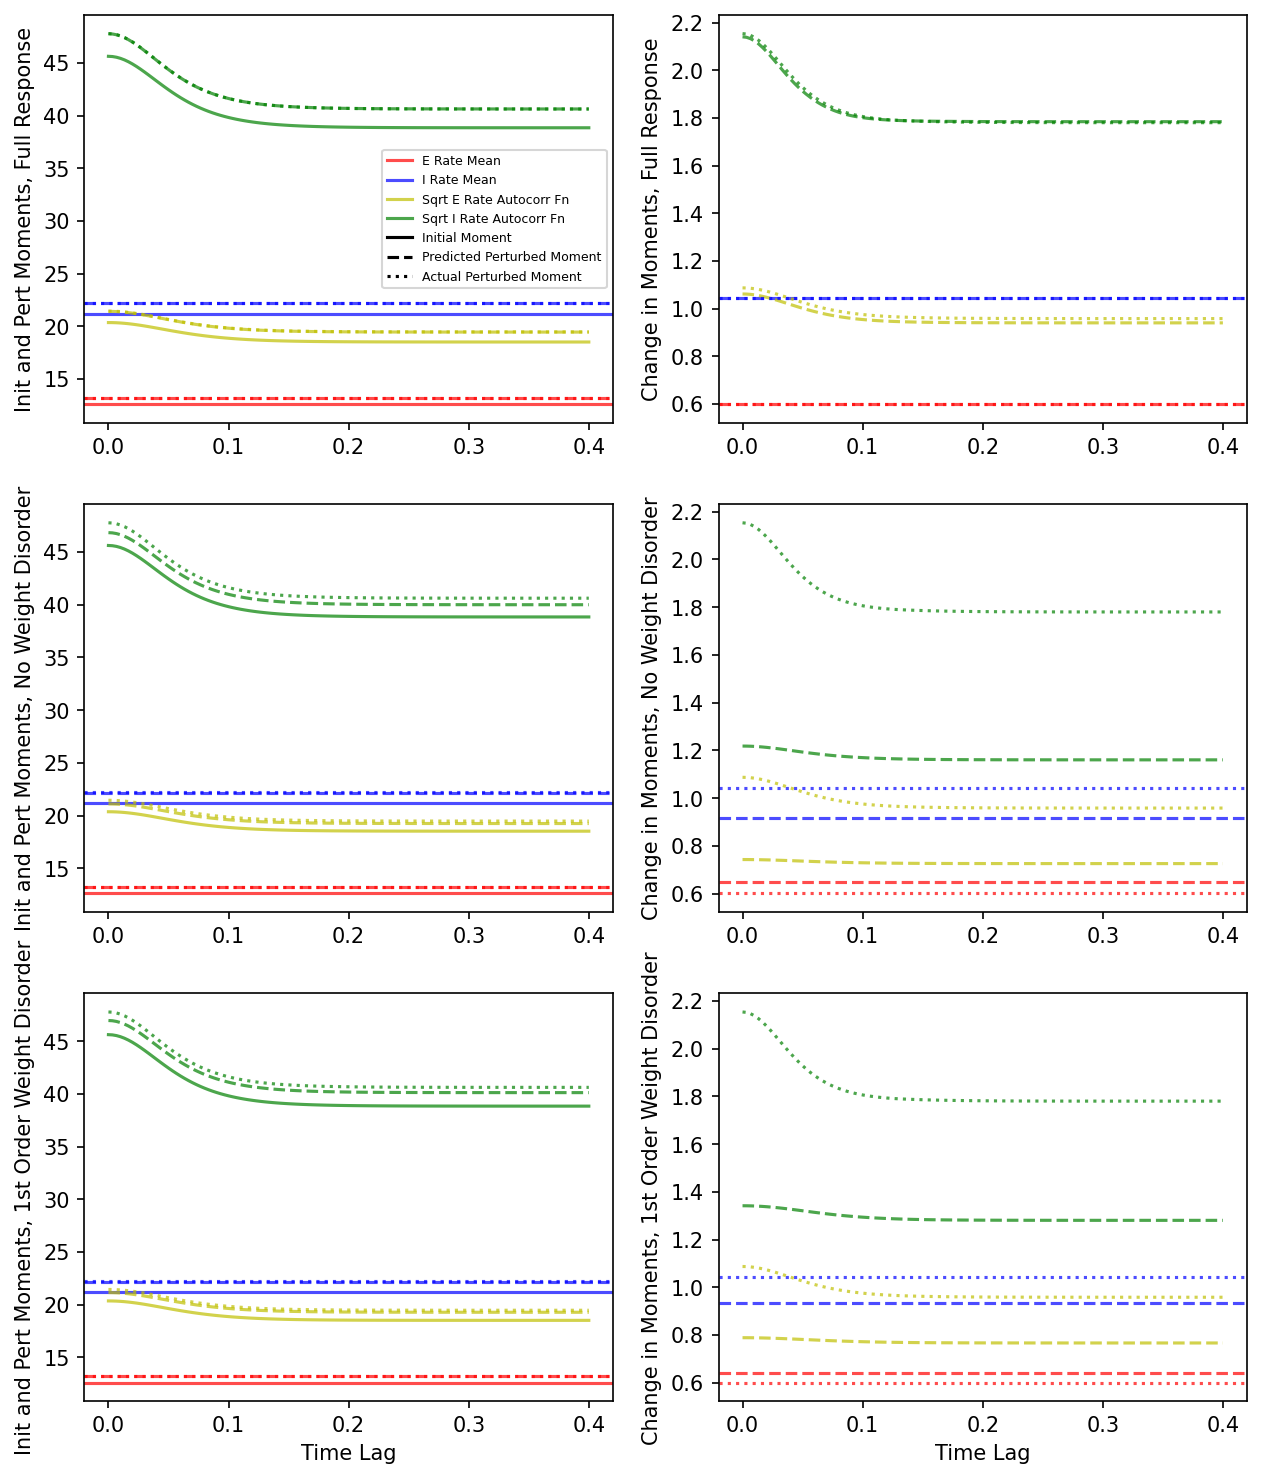

In [22]:
fig,axs= plt.subplots(3,2,figsize=(10,12),dpi=150)

axs[0,0].axhline(r[0],c='r',alpha=0.7,label='E Rate Mean')
axs[0,0].axhline(r[1],c='b',alpha=0.7,label='I Rate Mean')
axs[0,0].plot(ts,np.sqrt(Cr[0]),c='y',alpha=0.7,label='Sqrt E Rate Autocorr Fn')
axs[0,0].plot(ts,np.sqrt(Cr[1]),c='g',alpha=0.7,label='Sqrt I Rate Autocorr Fn')

axs[0,0].axhline(r[0] + drdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,0].axhline(r[1] + drdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Cr[0] + dCrdξ[0]*δrX),c='y',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Cr[1] + dCrdξ[1]*δrX),c='g',ls='--',alpha=0.7)

axs[0,0].axhline(res_dict_pert['r'][0],c='r',ls=':',alpha=0.7)
axs[0,0].axhline(res_dict_pert['r'][1],c='b',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Cr'][0]),c='y',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Cr'][1]),c='g',ls=':',alpha=0.7)

axs[0,0].plot(np.nan,np.nan,c='k',ls='-',label='Initial Moment')
axs[0,0].plot(np.nan,np.nan,c='k',ls='--',label='Predicted Perturbed Moment')
axs[0,0].plot(np.nan,np.nan,c='k',ls=':',label='Actual Perturbed Moment')

axs[0,0].legend(fontsize=6)

axs[0,1].axhline(drdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,1].axhline(drdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(Cr[0] + dCrdξ[0]*δrX) - np.sqrt(Cr[0]),c='y',ls='--',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(Cr[1] + dCrdξ[1]*δrX) - np.sqrt(Cr[1]),c='g',ls='--',alpha=0.7)

axs[0,1].axhline(res_dict_pert['r'][0] - r[0],c='r',ls=':',alpha=0.7)
axs[0,1].axhline(res_dict_pert['r'][1] - r[1],c='b',ls=':',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(res_dict_pert['Cr'][0]) - np.sqrt(Cr[0]),c='y',ls=':',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(res_dict_pert['Cr'][1]) - np.sqrt(Cr[1]),c='g',ls=':',alpha=0.7)

axs[1,0].axhline(r[0],c='r',alpha=0.7,label='Initial E Rate Mean')
axs[1,0].axhline(r[1],c='b',alpha=0.7,label='Initial I Rate Mean')
axs[1,0].plot(ts,np.sqrt(Cr[0]),c='y',alpha=0.7,label='Initial Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(Cr[1]),c='g',alpha=0.7,label='Initial Sqrt I Rate Autocorr Fn')

axs[1,0].axhline(r[0] + drdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7,label='Predicted Perturbed E Rate Mean')
axs[1,0].axhline(r[1] + drdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7,label='Predicted Perturbed I Rate Mean')
axs[1,0].plot(ts,np.sqrt(Cr[0] + dCrdξ0dis[0]*δrX),c='y',ls='--',alpha=0.7,label='Predicted Perturbed Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(Cr[1] + dCrdξ0dis[1]*δrX),c='g',ls='--',alpha=0.7,label='Predicted Perturbed Sqrt I Rate Autocorr Fn')

axs[1,0].axhline(res_dict_pert['r'][0],c='r',ls=':',alpha=0.7,label='Perturbed E Rate Mean')
axs[1,0].axhline(res_dict_pert['r'][1],c='b',ls=':',alpha=0.7,label='Perturbed I Rate Mean')
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Cr'][0]),c='y',ls=':',alpha=0.7,label='Perturbed Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Cr'][1]),c='g',ls=':',alpha=0.7,label='Perturbed Sqrt I Rate Autocorr Fn')

axs[1,1].axhline(drdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7)
axs[1,1].axhline(drdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(Cr[0] + dCrdξ0dis[0]*δrX) - np.sqrt(Cr[0]),c='y',ls='--',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(Cr[1] + dCrdξ0dis[1]*δrX) - np.sqrt(Cr[1]),c='g',ls='--',alpha=0.7)

axs[1,1].axhline(res_dict_pert['r'][0] - r[0],c='r',ls=':',alpha=0.7)
axs[1,1].axhline(res_dict_pert['r'][1] - r[1],c='b',ls=':',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(res_dict_pert['Cr'][0]) - np.sqrt(Cr[0]),c='y',ls=':',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(res_dict_pert['Cr'][1]) - np.sqrt(Cr[1]),c='g',ls=':',alpha=0.7)

axs[2,0].axhline(r[0],c='r',alpha=0.7,label='Initial E Rate Mean')
axs[2,0].axhline(r[1],c='b',alpha=0.7,label='Initial I Rate Mean')
axs[2,0].plot(ts,np.sqrt(Cr[0]),c='y',alpha=0.7,label='Initial Sqrt E Rate Autocorr Fn')
axs[2,0].plot(ts,np.sqrt(Cr[1]),c='g',alpha=0.7,label='Initial Sqrt I Rate Autocorr Fn')

axs[2,0].axhline(r[0] + drdξ1dis[0]*δrX,c='r',ls='--',alpha=0.7,label='Predicted Perturbed E Rate Mean')
axs[2,0].axhline(r[1] + drdξ1dis[1]*δrX,c='b',ls='--',alpha=0.7,label='Predicted Perturbed I Rate Mean')
axs[2,0].plot(ts,np.sqrt(Cr[0] + dCrdξ1dis[0]*δrX),c='y',ls='--',alpha=0.7,label='Predicted Perturbed Sqrt E Rate Autocorr Fn')
axs[2,0].plot(ts,np.sqrt(Cr[1] + dCrdξ1dis[1]*δrX),c='g',ls='--',alpha=0.7,label='Predicted Perturbed Sqrt I Rate Autocorr Fn')

axs[2,0].axhline(res_dict_pert['r'][0],c='r',ls=':',alpha=0.7,label='Perturbed E Rate Mean')
axs[2,0].axhline(res_dict_pert['r'][1],c='b',ls=':',alpha=0.7,label='Perturbed I Rate Mean')
axs[2,0].plot(ts,np.sqrt(res_dict_pert['Cr'][0]),c='y',ls=':',alpha=0.7,label='Perturbed Sqrt E Rate Autocorr Fn')
axs[2,0].plot(ts,np.sqrt(res_dict_pert['Cr'][1]),c='g',ls=':',alpha=0.7,label='Perturbed Sqrt I Rate Autocorr Fn')

axs[2,1].axhline(drdξ1dis[0]*δrX,c='r',ls='--',alpha=0.7)
axs[2,1].axhline(drdξ1dis[1]*δrX,c='b',ls='--',alpha=0.7)
axs[2,1].plot(ts,np.sqrt(Cr[0] + dCrdξ1dis[0]*δrX) - np.sqrt(Cr[0]),c='y',ls='--',alpha=0.7)
axs[2,1].plot(ts,np.sqrt(Cr[1] + dCrdξ1dis[1]*δrX) - np.sqrt(Cr[1]),c='g',ls='--',alpha=0.7)

axs[2,1].axhline(res_dict_pert['r'][0] - r[0],c='r',ls=':',alpha=0.7)
axs[2,1].axhline(res_dict_pert['r'][1] - r[1],c='b',ls=':',alpha=0.7)
axs[2,1].plot(ts,np.sqrt(res_dict_pert['Cr'][0]) - np.sqrt(Cr[0]),c='y',ls=':',alpha=0.7)
axs[2,1].plot(ts,np.sqrt(res_dict_pert['Cr'][1]) - np.sqrt(Cr[1]),c='g',ls=':',alpha=0.7)

axs[2,0].set_xlabel('Time Lag')
axs[2,1].set_xlabel('Time Lag')
axs[0,0].set_ylabel('Init and Pert Moments, Full Response')
axs[0,1].set_ylabel('Change in Moments, Full Response')
axs[1,0].set_ylabel('Init and Pert Moments, No Weight Disorder')
axs[1,1].set_ylabel('Change in Moments, No Weight Disorder')
axs[2,0].set_ylabel('Init and Pert Moments, 1st Order Weight Disorder')
axs[2,1].set_ylabel('Change in Moments, 1st Order Weight Disorder')

Text(0, 0.5, 'Change in Moments, No Weight Disorder')

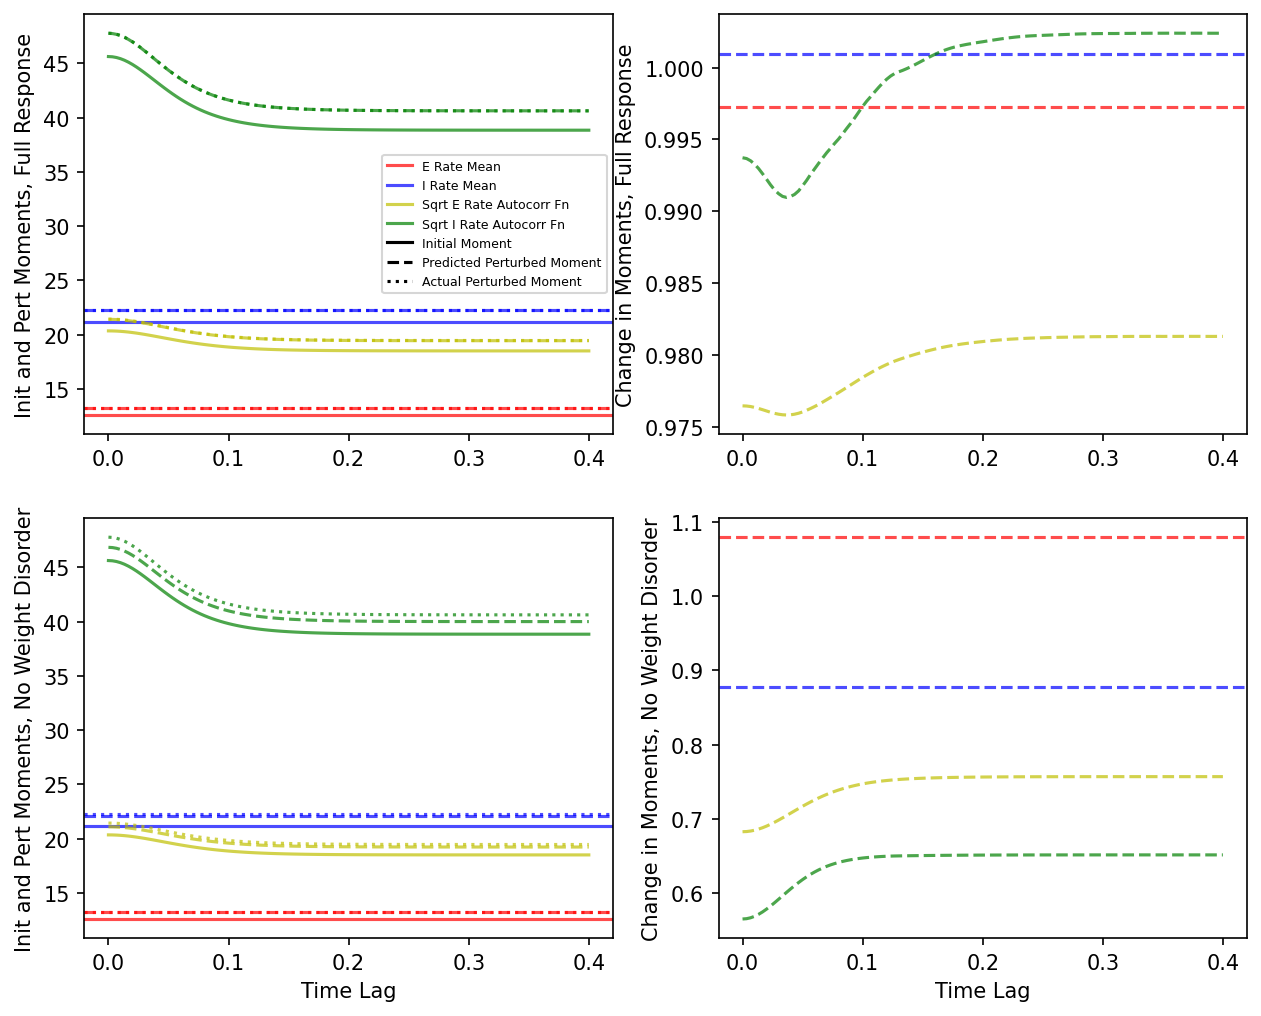

In [23]:
fig,axs= plt.subplots(2,2,figsize=(10,8),dpi=150)

axs[0,0].axhline(r[0],c='r',alpha=0.7,label='E Rate Mean')
axs[0,0].axhline(r[1],c='b',alpha=0.7,label='I Rate Mean')
axs[0,0].plot(ts,np.sqrt(Cr[0]),c='y',alpha=0.7,label='Sqrt E Rate Autocorr Fn')
axs[0,0].plot(ts,np.sqrt(Cr[1]),c='g',alpha=0.7,label='Sqrt I Rate Autocorr Fn')

axs[0,0].axhline(r[0] + drdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,0].axhline(r[1] + drdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Cr[0] + dCrdξ[0]*δrX),c='y',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Cr[1] + dCrdξ[1]*δrX),c='g',ls='--',alpha=0.7)

axs[0,0].axhline(res_dict_pert['r'][0],c='r',ls=':',alpha=0.7)
axs[0,0].axhline(res_dict_pert['r'][1],c='b',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Cr'][0]),c='y',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Cr'][1]),c='g',ls=':',alpha=0.7)

axs[0,0].plot(np.nan,np.nan,c='k',ls='-',label='Initial Moment')
axs[0,0].plot(np.nan,np.nan,c='k',ls='--',label='Predicted Perturbed Moment')
axs[0,0].plot(np.nan,np.nan,c='k',ls=':',label='Actual Perturbed Moment')

axs[0,0].legend(fontsize=6)

axs[0,1].axhline(drdξ[0]*δrX/(res_dict_pert['r'][0] - r[0]),c='r',ls='--',alpha=0.7)
axs[0,1].axhline(drdξ[1]*δrX/(res_dict_pert['r'][1] - r[1]),c='b',ls='--',alpha=0.7)
axs[0,1].plot(ts,(np.sqrt(Cr[0] + dCrdξ[0]*δrX) - np.sqrt(Cr[0]))/(np.sqrt(res_dict_pert['Cr'][0]) - np.sqrt(Cr[0])),c='y',ls='--',alpha=0.7)
axs[0,1].plot(ts,(np.sqrt(Cr[1] + dCrdξ[1]*δrX) - np.sqrt(Cr[1]))/(np.sqrt(res_dict_pert['Cr'][1]) - np.sqrt(Cr[1])),c='g',ls='--',alpha=0.7)

axs[1,0].axhline(r[0],c='r',alpha=0.7,label='Initial E Rate Mean')
axs[1,0].axhline(r[1],c='b',alpha=0.7,label='Initial I Rate Mean')
axs[1,0].plot(ts,np.sqrt(Cr[0]),c='y',alpha=0.7,label='Initial Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(Cr[1]),c='g',alpha=0.7,label='Initial Sqrt I Rate Autocorr Fn')

axs[1,0].axhline(r[0] + drdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7,label='Predicted Perturbed E Rate Mean')
axs[1,0].axhline(r[1] + drdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7,label='Predicted Perturbed I Rate Mean')
axs[1,0].plot(ts,np.sqrt(Cr[0] + dCrdξ0dis[0]*δrX),c='y',ls='--',alpha=0.7,label='Predicted Perturbed Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(Cr[1] + dCrdξ0dis[1]*δrX),c='g',ls='--',alpha=0.7,label='Predicted Perturbed Sqrt I Rate Autocorr Fn')

axs[1,0].axhline(res_dict_pert['r'][0],c='r',ls=':',alpha=0.7,label='Perturbed E Rate Mean')
axs[1,0].axhline(res_dict_pert['r'][1],c='b',ls=':',alpha=0.7,label='Perturbed I Rate Mean')
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Cr'][0]),c='y',ls=':',alpha=0.7,label='Perturbed Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Cr'][1]),c='g',ls=':',alpha=0.7,label='Perturbed Sqrt I Rate Autocorr Fn')

axs[1,1].axhline(drdξ0dis[0]*δrX/(res_dict_pert['r'][0] - r[0]),c='r',ls='--',alpha=0.7)
axs[1,1].axhline(drdξ0dis[1]*δrX/(res_dict_pert['r'][1] - r[1]),c='b',ls='--',alpha=0.7)
axs[1,1].plot(ts,(np.sqrt(Cr[0] + dCrdξ0dis[0]*δrX) - np.sqrt(Cr[0]))/(np.sqrt(res_dict_pert['Cr'][0]) - np.sqrt(Cr[0])),c='y',ls='--',alpha=0.7)
axs[1,1].plot(ts,(np.sqrt(Cr[1] + dCrdξ0dis[1]*δrX) - np.sqrt(Cr[1]))/(np.sqrt(res_dict_pert['Cr'][1]) - np.sqrt(Cr[1])),c='g',ls='--',alpha=0.7)

axs[1,0].set_xlabel('Time Lag')
axs[1,1].set_xlabel('Time Lag')
axs[0,0].set_ylabel('Init and Pert Moments, Full Response')
axs[0,1].set_ylabel('Change in Moments, Full Response')
axs[1,0].set_ylabel('Init and Pert Moments, No Weight Disorder')
axs[1,1].set_ylabel('Change in Moments, No Weight Disorder')

# Calculate linear response with Structure

In [24]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/3

δrX = 0.2

res_dict_init = dmft.run_first_stage_ring_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,which='base',return_full=True)
res_dict_pert = dmft.run_first_stage_ring_dmft(prms,bX+δrX,aXs[-1]/(bX+δrX),eX,'./../results',ri,Twrm,Tsav,dt,which='base',return_full=True)

0.20% completed


/Users/tuannguyen/ToroidalNetworks/sparse_weights/notebooks/./../scripts/dmft.py:701: RuntimeWarning: invalid value encountered in divide
  sCrij = solve_width((Craij-Crbij)/(Crpij-Crbij))


0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 161.797059 s
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 143.90458999999998 s


In [25]:
rb = res_dict_init['rb']
rp = res_dict_init['rp']
sr = res_dict_init['sr']
Crb = res_dict_init['Crb']
Crp = res_dict_init['Crp']
sCr = res_dict_init['sCr'][:,-1]

print(res_dict_init['sr'])
print(res_dict_init['sCr'][:,-1])
print()
print(res_dict_pert['sr'])
print(res_dict_pert['sCr'][:,-1])

[12.68158104 33.16991463]
[11.11536136 31.15445084]

[12.71955659 33.16255261]
[11.19468807 31.28438903]


In [26]:
SoriE = prms['SoriE']
SoriI = prms['SoriI']

Hb = bX*K*J*np.array([hE,hI/beta],dtype=np.float32)
Hp = (bX+aXs[-1])*K*J*np.array([hE,hI/beta],dtype=np.float32)

muHb = tau*Hb
SigHb = (muHb*eH)**2
muHp = tau*Hp
SigHp = (muHp*eH)**2

sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
sW2 = sW**2
sWr = np.sqrt(sW2+sr**2)
sWCr = np.sqrt(sW2+sCr**2)

muWbb = (1 - dmft.struct_fact(180/2,sWr,sr,180)) * muW
muWbp = dmft.struct_fact(180/2,sWr,sr,180) * muW
muWpb = (1 - dmft.struct_fact(0,sWr,sr,180)) * muW
muWpp = dmft.struct_fact(0,sWr,sr,180) * muW

SigWbb = (1 - dmft.struct_fact(180/2,sWCr,sCr,180)) * SigW
SigWbp = dmft.struct_fact(180/2,sWCr,sCr,180) * SigW
SigWpb = (1 - dmft.struct_fact(0,sWCr,sCr,180)) * SigW
SigWpp = dmft.struct_fact(0,sWCr,sCr,180) * SigW

dmuHbdξ = tau*K*J*np.array([hE,hI/beta],dtype=np.float32)# + dmuWbpdsr*dsr/δrX@rp + dmuWbbdsr*dsr/δrX@rb
dmuHpdξ = tau*K*J*np.array([hE,hI/beta],dtype=np.float32)# + dmuWppdsr*dsr/δrX@rp + dmuWpbdsr*dsr/δrX@rb
dSigHbdξ = (2*muHb*dmuHbdξ*eH**2)[:,None]# + dSigWbpdsCr*dsCr/δrX@Crp + dSigWbbdsCr*dsCr/δrX@Crb
dSigHpdξ = (2*muHp*dmuHpdξ*eH**2)[:,None]# + dSigWppdsCr*dsCr/δrX@Crp + dSigWpbdsCr*dsCr/δrX@Crb

In [27]:
bφ = np.array([MFE(res_dict_init['mub'][0],res_dict_init['Sigb'][0,0])[0],
               MFI(res_dict_init['mub'][1],res_dict_init['Sigb'][1,0])[0]])
bφp = np.array([MFPE(res_dict_init['mub'][0],res_dict_init['Sigb'][0,0])[0],
                MFPI(res_dict_init['mub'][1],res_dict_init['Sigb'][1,0])[0]])
bφpp = np.array([MFPPE(res_dict_init['mub'][0],res_dict_init['Sigb'][0,0])[0],
                 MFPPI(res_dict_init['mub'][1],res_dict_init['Sigb'][1,0])[0]])
pφ = np.array([MFE(res_dict_init['mup'][0],res_dict_init['Sigp'][0,0])[0],
               MFI(res_dict_init['mup'][1],res_dict_init['Sigp'][1,0])[0]])
pφp = np.array([MFPE(res_dict_init['mup'][0],res_dict_init['Sigp'][0,0])[0],
                MFPI(res_dict_init['mup'][1],res_dict_init['Sigp'][1,0])[0]])
pφpp = np.array([MFPPE(res_dict_init['mup'][0],res_dict_init['Sigp'][0,0])[0],
                 MFPPI(res_dict_init['mup'][1],res_dict_init['Sigp'][1,0])[0]])

bRφφ = np.array([[CFFE(res_dict_init['mub'][0],
                       res_dict_init['Sigb'][0,0],cov)[0] for cov in res_dict_init['Sigb'][0]],
                 [CFFI(res_dict_init['mub'][1],
                       res_dict_init['Sigb'][1,0],cov)[0] for cov in res_dict_init['Sigb'][1]]])
bRφφp = np.array([[CFFPE(res_dict_init['mub'][0],
                         res_dict_init['Sigb'][0,0],cov)[0] for cov in res_dict_init['Sigb'][0]],
                  [CFFPI(res_dict_init['mub'][1],
                         res_dict_init['Sigb'][1,0],cov)[0] for cov in res_dict_init['Sigb'][1]]])
bRφφpp = np.array([[CFFPPE(res_dict_init['mub'][0],
                           res_dict_init['Sigb'][0,0],cov)[0] for cov in res_dict_init['Sigb'][0]],
                   [CFFPPI(res_dict_init['mub'][1],
                           res_dict_init['Sigb'][1,0],cov)[0] for cov in res_dict_init['Sigb'][1]]])
bRφpφp = np.array([[CFPFPE(res_dict_init['mub'][0],
                           res_dict_init['Sigb'][0,0],cov)[0] for cov in res_dict_init['Sigb'][0]],
                   [CFPFPI(res_dict_init['mub'][1],
                           res_dict_init['Sigb'][1,0],cov)[0] for cov in res_dict_init['Sigb'][1]]])
pRφφ = np.array([[CFFE(res_dict_init['mup'][0],
                       res_dict_init['Sigp'][0,0],cov)[0] for cov in res_dict_init['Sigp'][0]],
                 [CFFI(res_dict_init['mup'][1],
                       res_dict_init['Sigp'][1,0],cov)[0] for cov in res_dict_init['Sigp'][1]]])
pRφφp = np.array([[CFFPE(res_dict_init['mup'][0],
                         res_dict_init['Sigp'][0,0],cov)[0] for cov in res_dict_init['Sigp'][0]],
                  [CFFPI(res_dict_init['mup'][1],
                         res_dict_init['Sigp'][1,0],cov)[0] for cov in res_dict_init['Sigp'][1]]])
pRφφpp = np.array([[CFFPPE(res_dict_init['mup'][0],
                           res_dict_init['Sigp'][0,0],cov)[0] for cov in res_dict_init['Sigp'][0]],
                   [CFFPPI(res_dict_init['mup'][1],
                           res_dict_init['Sigp'][1,0],cov)[0] for cov in res_dict_init['Sigp'][1]]])
pRφpφp = np.array([[CFPFPE(res_dict_init['mup'][0],
                           res_dict_init['Sigp'][0,0],cov)[0] for cov in res_dict_init['Sigp'][0]],
                   [CFPFPI(res_dict_init['mup'][1],
                           res_dict_init['Sigp'][1,0],cov)[0] for cov in res_dict_init['Sigp'][1]]])

bRφφpp = smooth_func(bRφφpp,dt)
bRφpφp = smooth_func(bRφpφp,dt)
pRφφpp = smooth_func(pRφφpp,dt)
pRφpφp = smooth_func(pRφpφp,dt)

In [28]:
NP = res_dict_init['Sigb'].shape[0]
NT = res_dict_init['Sigb'].shape[1]
dt = 0.01/3
ts = np.arange(NT)*dt

L = np.zeros((NT,NT))
L[(np.arange(NT), np.arange(NT))] = -2/dt**2
L[(np.arange(NT-1), np.arange(1,NT))] = 1/dt**2
L[(np.arange(1,NT), np.arange(NT-1))] = 1/dt**2
L[0,1] = 2/dt**2
L[-1,-1] = -1/dt**2
# L[-1,-2] = 2/dt**2

δ = np.concatenate(([1],np.zeros(NT-1)))

A = np.eye(NP) - φp[:,None] * muW
B = -0.5 * φpp[:,None,None] * SigW[:,:,None] * δ[None,None,:]
C = -2 * Rφφp[:,:,None] * muW[:,None,:]
D = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
    - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:] +\
    - Rφpφp[:,:,None,None] * SigW[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
    - Rφφpp[:,:,None,None] * SigW[:,None,:,None] * δ[None,None,None,:]

Abb = np.eye(NP) - bφp[:,None] * muWbb
Bbb = -0.5 * bφpp[:,None,None] * SigWbb[:,:,None] * δ[None,None,:]
Cbb = -2 * bRφφp[:,:,None] * muWbb[:,None,:]
Dbb = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
    - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:] +\
    - bRφpφp[:,:,None,None] * SigWbb[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
    - bRφφpp[:,:,None,None] * SigWbb[:,None,:,None] * δ[None,None,None,:]

Abp = - bφp[:,None] * muWbp
Bbp = -0.5 * bφpp[:,None,None] * SigWbp[:,:,None] * δ[None,None,:]
Cbp = -2 * bRφφp[:,:,None] * muWbp[:,None,:]
Dbp = - bRφpφp[:,:,None,None] * SigWbp[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
    - bRφφpp[:,:,None,None] * SigWbp[:,None,:,None] * δ[None,None,None,:]

Apb = - pφp[:,None] * muWpb
Bpb = -0.5 * pφpp[:,None,None] * SigWpb[:,:,None] * δ[None,None,:]
Cpb = -2 * pRφφp[:,:,None] * muWpb[:,None,:]
Dpb = - pRφpφp[:,:,None,None] * SigWpb[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
    - pRφφpp[:,:,None,None] * SigWpb[:,None,:,None] * δ[None,None,None,:]

App = np.eye(NP) - pφp[:,None] * muWpp
Bpp = -0.5 * pφpp[:,None,None] * SigWpp[:,:,None] * δ[None,None,:]
Cpp = -2 * pRφφp[:,:,None] * muWpp[:,None,:]
Dpp = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
    - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:] +\
    - pRφpφp[:,:,None,None] * SigWpp[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
    - pRφφpp[:,:,None,None] * SigWpp[:,None,:,None] * δ[None,None,None,:]
    
D0dis = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
    - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:]

Eb = bφp * dmuHbdξ + 0.5 * bφpp * dSigHbdξ[:,0]
Fb = 2 * bRφφp * dmuHbdξ[:,None] + bRφφpp * dSigHbdξ[:,0:1] + bRφpφp * dSigHbdξ

Ep = pφp * dmuHpdξ + 0.5 * pφpp * dSigHpdξ[:,0]
Fp = 2 * pRφφp * dmuHpdξ[:,None] + pRφφpp * dSigHpdξ[:,0:1] + pRφpφp * dSigHpdξ

In [29]:
Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
Mbp = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mpb = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
Mpp = np.block([[App,Bpp.reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])
fb = np.concatenate([Eb,Fb.flatten()])
fp = np.concatenate([Ep,Fp.flatten()])

Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])
Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),np.zeros_like(Dbp).reshape(NP*NT,NP*NT)]])
Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),np.zeros_like(Dpb).reshape(NP*NT,NP*NT)]])
Mpp0dis = np.block([[App,np.zeros_like(Bpp).reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])

M = np.block([[Mbb,Mbp],[Mpb,Mpp]])
M0dis = np.block([[Mbb0dis,Mbp0dis],[Mpb0dis,Mpp0dis]])
f = np.concatenate([fb,fp])

In [30]:
dmdξ = np.linalg.solve(M,f)
dmbdξ = dmdξ[:NP+NP*NT]
dmpdξ = dmdξ[NP+NP*NT:]
drbdξ = dmbdξ[:NP]
dCrbdξ = dmbdξ[NP:].reshape(NP,NT)
drpdξ = dmpdξ[:NP]
dCrpdξ = dmpdξ[NP:].reshape(NP,NT)

dmdξ0dis = np.linalg.solve(M0dis,f)
dmbdξ0dis = dmdξ0dis[:NP+NP*NT]
dmpdξ0dis = dmdξ0dis[NP+NP*NT:]
drbdξ0dis = dmbdξ0dis[:NP]
dCrbdξ0dis = dmbdξ0dis[NP:].reshape(NP,NT)
drpdξ0dis = dmpdξ0dis[:NP]
dCrpdξ0dis = dmpdξ0dis[NP:].reshape(NP,NT)

Text(0, 0.5, 'Change in Peak Moments, No Weight Disorder')

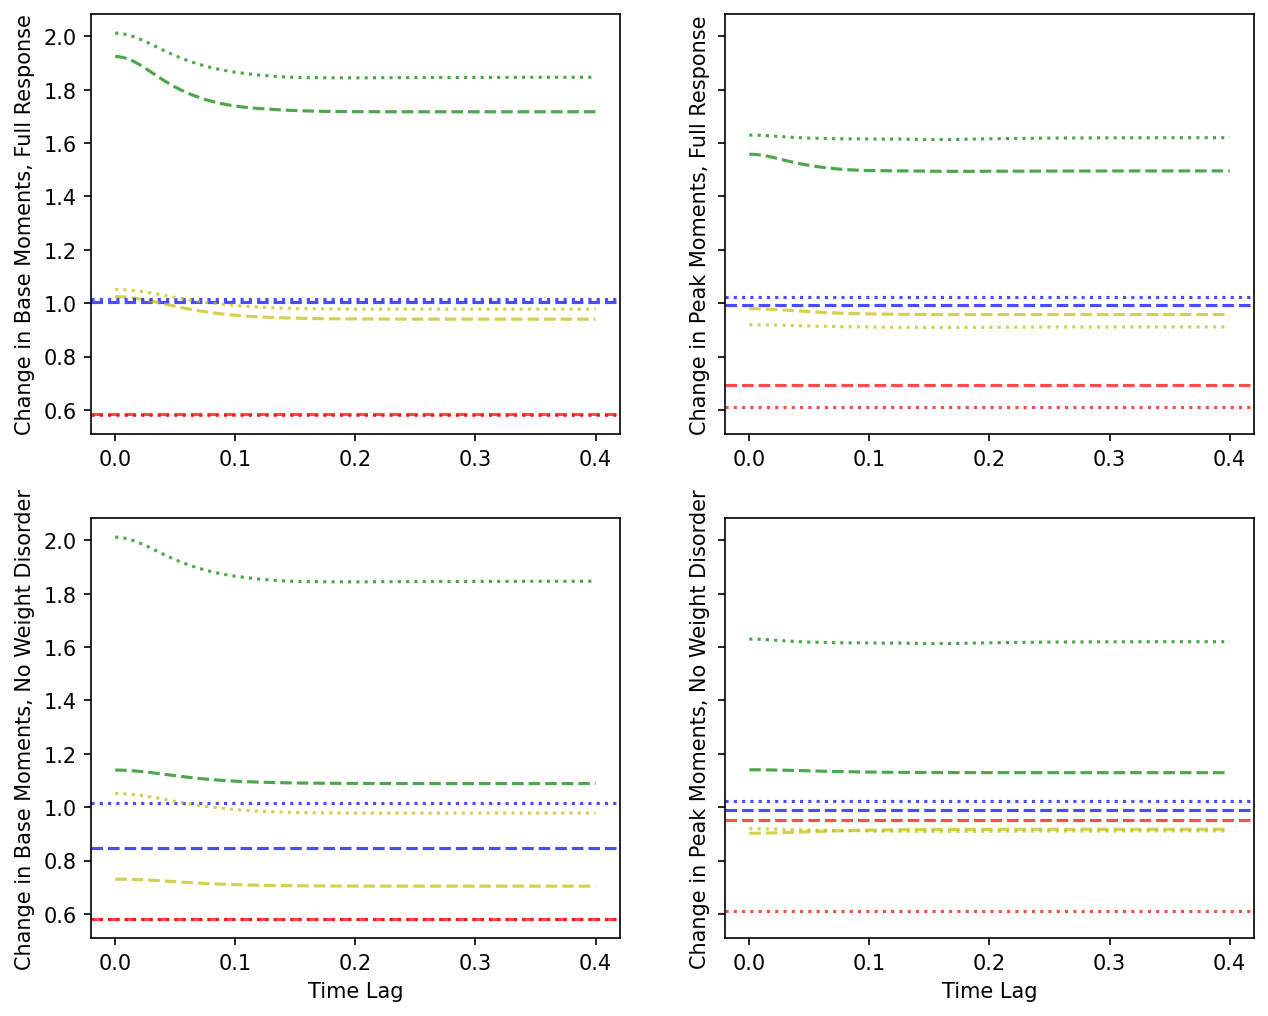

In [31]:
fig,axs= plt.subplots(2,2,figsize=(10,8),dpi=150,sharey=True)

axs[0,0].axhline(drbdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,0].axhline(drbdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Crb[0] + dCrbdξ[0]*δrX) - np.sqrt(Crb[0]),c='y',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Crb[1] + dCrbdξ[1]*δrX) - np.sqrt(Crb[1]),c='g',ls='--',alpha=0.7)

axs[0,0].axhline(res_dict_pert['rb'][0] - rb[0],c='r',ls=':',alpha=0.7)
axs[0,0].axhline(res_dict_pert['rb'][1] - rb[1],c='b',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Crb'][0]) - np.sqrt(Crb[0]),c='y',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Crb'][1]) - np.sqrt(Crb[1]),c='g',ls=':',alpha=0.7)

axs[0,1].axhline(drpdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,1].axhline(drpdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(Crp[0] + dCrpdξ[0]*δrX) - np.sqrt(Crp[0]),c='y',ls='--',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(Crp[1] + dCrpdξ[1]*δrX) - np.sqrt(Crp[1]),c='g',ls='--',alpha=0.7)

axs[0,1].axhline(res_dict_pert['rp'][0] - rp[0],c='r',ls=':',alpha=0.7)
axs[0,1].axhline(res_dict_pert['rp'][1] - rp[1],c='b',ls=':',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(res_dict_pert['Crp'][0]) - np.sqrt(Crp[0]),c='y',ls=':',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(res_dict_pert['Crp'][1]) - np.sqrt(Crp[1]),c='g',ls=':',alpha=0.7)

axs[1,0].axhline(drbdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7)
axs[1,0].axhline(drbdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(Crb[0] + dCrbdξ0dis[0]*δrX) - np.sqrt(Crb[0]),c='y',ls='--',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(Crb[1] + dCrbdξ0dis[1]*δrX) - np.sqrt(Crb[1]),c='g',ls='--',alpha=0.7)

axs[1,0].axhline(res_dict_pert['rb'][0] - rb[0],c='r',ls=':',alpha=0.7)
axs[1,0].axhline(res_dict_pert['rb'][1] - rb[1],c='b',ls=':',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Crb'][0]) - np.sqrt(Crb[0]),c='y',ls=':',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Crb'][1]) - np.sqrt(Crb[1]),c='g',ls=':',alpha=0.7)

axs[1,1].axhline(drpdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7)
axs[1,1].axhline(drpdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(Crp[0] + dCrpdξ0dis[0]*δrX) - np.sqrt(Crp[0]),c='y',ls='--',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(Crp[1] + dCrpdξ0dis[1]*δrX) - np.sqrt(Crp[1]),c='g',ls='--',alpha=0.7)

axs[1,1].axhline(res_dict_pert['rp'][0] - rp[0],c='r',ls=':',alpha=0.7)
axs[1,1].axhline(res_dict_pert['rp'][1] - rp[1],c='b',ls=':',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(res_dict_pert['Crp'][0]) - np.sqrt(Crp[0]),c='y',ls=':',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(res_dict_pert['Crp'][1]) - np.sqrt(Crp[1]),c='g',ls=':',alpha=0.7)

axs[1,0].set_xlabel('Time Lag')
axs[1,1].set_xlabel('Time Lag')
axs[0,0].set_ylabel('Change in Base Moments, Full Response')
axs[0,1].set_ylabel('Change in Peak Moments, Full Response')
axs[1,0].set_ylabel('Change in Base Moments, No Weight Disorder')
axs[1,1].set_ylabel('Change in Peak Moments, No Weight Disorder')

## Calculate Linear Response with Width Changes

In [32]:
dsr = res_dict_pert['sr']-res_dict_init['sr']
dsCr = res_dict_pert['sCr'][:,-1]-res_dict_init['sCr'][:,-1]

dmuWbbdsr = (dmft.struct_fact(180/2,np.sqrt(sW2+(sr+0.1)**2),sr+0.1,180) +\
    - dmft.struct_fact(180/2,np.sqrt(sW2+(sr-0.1)**2),sr-0.1,180)) / 0.2 * muW
dmuWbpdsr = (dmft.struct_fact(180/2,np.sqrt(sW2+(sr+0.1)**2),sr+0.1,180) +\
    - dmft.struct_fact(180/2,np.sqrt(sW2+(sr-0.1)**2),sr-0.1,180)) / 0.2 * muW
dmuWpbdsr = (dmft.struct_fact(0,np.sqrt(sW2+(sr+0.1)**2),sr+0.1,180) +\
    - dmft.struct_fact(0,np.sqrt(sW2+(sr-0.1)**2),sr-0.1,180)) / 0.2 * muW
dmuWppdsr = (dmft.struct_fact(0,np.sqrt(sW2+(sr+0.1)**2),sr+0.1,180) +\
    - dmft.struct_fact(0,np.sqrt(sW2+(sr-0.1)**2),sr-0.1,180)) / 0.2 * muW

dSigWbbdsCr = (dmft.struct_fact(180/2,np.sqrt(sW2+(sCr+0.1)**2),sCr+0.1,180) +\
    - dmft.struct_fact(180/2,np.sqrt(sW2+(sCr-0.1)**2),sCr-0.1,180)) / 0.2 * SigW
dSigWbpdsCr = (dmft.struct_fact(180/2,np.sqrt(sW2+(sCr+0.1)**2),sCr+0.1,180) +\
    - dmft.struct_fact(180/2,np.sqrt(sW2+(sCr-0.1)**2),sCr-0.1,180)) / 0.2 * SigW
dSigWpbdsCr = (dmft.struct_fact(0,np.sqrt(sW2+(sCr+0.1)**2),sCr+0.1,180) +\
    - dmft.struct_fact(0,np.sqrt(sW2+(sCr-0.1)**2),sCr-0.1,180)) / 0.2 * SigW
dSigWppdsCr = (dmft.struct_fact(0,np.sqrt(sW2+(sCr+0.1)**2),sCr+0.1,180) +\
    - dmft.struct_fact(0,np.sqrt(sW2+(sCr-0.1)**2),sCr-0.1,180)) / 0.2 * SigW

In [33]:
print(tau*K*J*np.array([hE,hI/beta],dtype=np.float32))
print(tau*K*J*np.array([hE,hI/beta],dtype=np.float32))
print(dmuWbpdsr*dsr/δrX@rp + dmuWbbdsr*dsr/δrX@rb)
print(dmuWppdsr*dsr/δrX@rp + dmuWpbdsr*dsr/δrX@rb)

[0.00773113 0.00100892]
[0.00773113 0.00100892]
[0.00018881 0.00076433]
[0.00046844 0.00197345]


In [34]:
dmuHbdξ = tau*K*J*np.array([hE,hI/beta],dtype=np.float32) + dmuWbpdsr*dsr/δrX@rp + dmuWbbdsr*dsr/δrX@rb
dmuHpdξ = tau*K*J*np.array([hE,hI/beta],dtype=np.float32) + dmuWppdsr*dsr/δrX@rp + dmuWpbdsr*dsr/δrX@rb
dSigHbdξ = (2*muHb*dmuHbdξ*eH**2)[:,None] + dSigWbpdsCr*dsCr/δrX@Crp + dSigWbbdsCr*dsCr/δrX@Crb
dSigHpdξ = (2*muHp*dmuHpdξ*eH**2)[:,None] + dSigWppdsCr*dsCr/δrX@Crp + dSigWpbdsCr*dsCr/δrX@Crb

Eb = bφp * dmuHbdξ + 0.5 * bφpp * dSigHbdξ[:,0]
Fb = 2 * bRφφp * dmuHbdξ[:,None] + bRφφpp * dSigHbdξ[:,0:1] + bRφpφp * dSigHbdξ

Ep = pφp * dmuHpdξ + 0.5 * pφpp * dSigHpdξ[:,0]
Fp = 2 * pRφφp * dmuHpdξ[:,None] + pRφφpp * dSigHpdξ[:,0:1] + pRφpφp * dSigHpdξ

Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
Mbp = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mpb = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
Mpp = np.block([[App,Bpp.reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])
fb = np.concatenate([Eb,Fb.flatten()])
fp = np.concatenate([Ep,Fp.flatten()])

Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])
Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),np.zeros_like(Dbp).reshape(NP*NT,NP*NT)]])
Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),np.zeros_like(Dpb).reshape(NP*NT,NP*NT)]])
Mpp0dis = np.block([[App,np.zeros_like(Bpp).reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])

M = np.block([[Mbb,Mbp],[Mpb,Mpp]])
M0dis = np.block([[Mbb0dis,Mbp0dis],[Mpb0dis,Mpp0dis]])
f = np.concatenate([fb,fp])

dmdξ = np.linalg.solve(M,f)
dmbdξ = dmdξ[:NP+NP*NT]
dmpdξ = dmdξ[NP+NP*NT:]
drbdξ = dmbdξ[:NP]
dCrbdξ = dmbdξ[NP:].reshape(NP,NT)
drpdξ = dmpdξ[:NP]
dCrpdξ = dmpdξ[NP:].reshape(NP,NT)

dmdξ0dis = np.linalg.solve(M0dis,f)
dmbdξ0dis = dmdξ0dis[:NP+NP*NT]
dmpdξ0dis = dmdξ0dis[NP+NP*NT:]
drbdξ0dis = dmbdξ0dis[:NP]
dCrbdξ0dis = dmbdξ0dis[NP:].reshape(NP,NT)
drpdξ0dis = dmpdξ0dis[:NP]
dCrpdξ0dis = dmpdξ0dis[NP:].reshape(NP,NT)

Text(0, 0.5, 'Change in Peak Moments, No Weight Disorder')

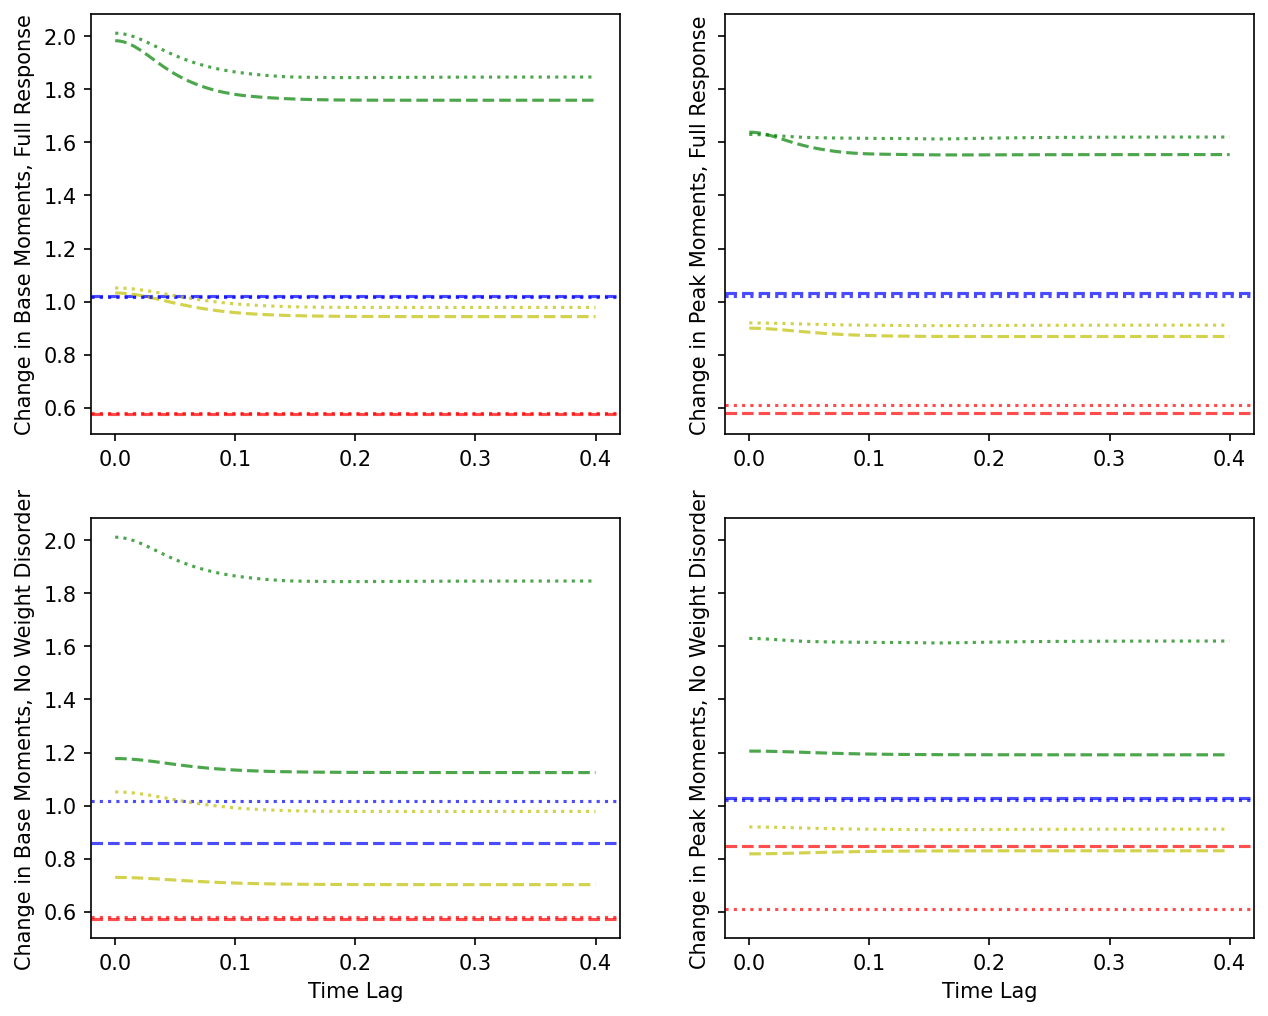

In [35]:
fig,axs= plt.subplots(2,2,figsize=(10,8),dpi=150,sharey=True)

axs[0,0].axhline(drbdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,0].axhline(drbdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Crb[0] + dCrbdξ[0]*δrX) - np.sqrt(Crb[0]),c='y',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Crb[1] + dCrbdξ[1]*δrX) - np.sqrt(Crb[1]),c='g',ls='--',alpha=0.7)

axs[0,0].axhline(res_dict_pert['rb'][0] - rb[0],c='r',ls=':',alpha=0.7)
axs[0,0].axhline(res_dict_pert['rb'][1] - rb[1],c='b',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Crb'][0]) - np.sqrt(Crb[0]),c='y',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Crb'][1]) - np.sqrt(Crb[1]),c='g',ls=':',alpha=0.7)

axs[0,1].axhline(drpdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,1].axhline(drpdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(Crp[0] + dCrpdξ[0]*δrX) - np.sqrt(Crp[0]),c='y',ls='--',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(Crp[1] + dCrpdξ[1]*δrX) - np.sqrt(Crp[1]),c='g',ls='--',alpha=0.7)

axs[0,1].axhline(res_dict_pert['rp'][0] - rp[0],c='r',ls=':',alpha=0.7)
axs[0,1].axhline(res_dict_pert['rp'][1] - rp[1],c='b',ls=':',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(res_dict_pert['Crp'][0]) - np.sqrt(Crp[0]),c='y',ls=':',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(res_dict_pert['Crp'][1]) - np.sqrt(Crp[1]),c='g',ls=':',alpha=0.7)

axs[1,0].axhline(drbdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7)
axs[1,0].axhline(drbdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(Crb[0] + dCrbdξ0dis[0]*δrX) - np.sqrt(Crb[0]),c='y',ls='--',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(Crb[1] + dCrbdξ0dis[1]*δrX) - np.sqrt(Crb[1]),c='g',ls='--',alpha=0.7)

axs[1,0].axhline(res_dict_pert['rb'][0] - rb[0],c='r',ls=':',alpha=0.7)
axs[1,0].axhline(res_dict_pert['rb'][1] - rb[1],c='b',ls=':',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Crb'][0]) - np.sqrt(Crb[0]),c='y',ls=':',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Crb'][1]) - np.sqrt(Crb[1]),c='g',ls=':',alpha=0.7)

axs[1,1].axhline(drpdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7)
axs[1,1].axhline(drpdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(Crp[0] + dCrpdξ0dis[0]*δrX) - np.sqrt(Crp[0]),c='y',ls='--',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(Crp[1] + dCrpdξ0dis[1]*δrX) - np.sqrt(Crp[1]),c='g',ls='--',alpha=0.7)

axs[1,1].axhline(res_dict_pert['rp'][0] - rp[0],c='r',ls=':',alpha=0.7)
axs[1,1].axhline(res_dict_pert['rp'][1] - rp[1],c='b',ls=':',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(res_dict_pert['Crp'][0]) - np.sqrt(Crp[0]),c='y',ls=':',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(res_dict_pert['Crp'][1]) - np.sqrt(Crp[1]),c='g',ls=':',alpha=0.7)

axs[1,0].set_xlabel('Time Lag')
axs[1,1].set_xlabel('Time Lag')
axs[0,0].set_ylabel('Change in Base Moments, Full Response')
axs[0,1].set_ylabel('Change in Peak Moments, Full Response')
axs[1,0].set_ylabel('Change in Base Moments, No Weight Disorder')
axs[1,1].set_ylabel('Change in Peak Moments, No Weight Disorder')

## Figure out which projections can be treated perturbatively

In [36]:
np.max(np.real(np.linalg.eig(np.linalg.inv(np.block([[Mbb,np.zeros_like(Mbp)],[Mpb,Mpp]]))@\
    np.block([[np.zeros_like(Mbb),Mbp],[np.zeros_like(Mpb),np.zeros_like(Mpp)]]))[0]))

0.0

In [37]:
np.max(np.real(np.linalg.eig(np.linalg.inv(np.block([[Mbb,np.zeros_like(Mbp)],[np.zeros_like(Mpb),Mpp]]))@\
    np.block([[np.zeros_like(Mbb),Mbp],[Mpb,np.zeros_like(Mpp)]]))[0]))

0.48404365710915975

# Calculate linear response with Opto Perturbation

In [38]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/5

res_dict_init = dmft.run_first_stage_ring_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,which='base',return_full=True)
res_dict_pert = dmft.run_first_stage_ring_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,which='opto',return_full=True)

0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 452.74981199999996 s
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 405.126542 s


In [39]:
rvb = res_dict_init['rb']
rvp = res_dict_init['rp']
sr = res_dict_init['sr']
Crvb = res_dict_init['Crb']
Crvp = res_dict_init['Crp']
sCr = res_dict_init['sCr'][:,-1]

rob = res_dict_pert['rb']
rop = res_dict_pert['rp']
Crob = res_dict_pert['Crb']
Crop = res_dict_pert['Crp']

In [67]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/5

res_dict_decoup = dmft.run_decoupled_two_site_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,struct_dict=res_dict_init,which='opto',return_full=True)

0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 254.17247999999995 s


In [68]:
rLb = res_dict_decoup['rb']
rLp = res_dict_decoup['rp']
CrLb = res_dict_decoup['Crb']
CrLp = res_dict_decoup['Crp']

δrb0 = rLb - rvb
δrp0 = rLp - rvp
δCrb0 = CrLb - Crvb
δCrp0 = CrLp - Crvp

In [42]:
print(δrb0)
print(res_dict_pert['rb'] - rvb)
print()
print(δrp0)
print(res_dict_pert['rp'] - rvp)
print()
print(δCrb0[:,-1])
print(res_dict_pert['Crb'][:,-1] - Crvb[:,-1])
print()
print(δCrp0[:,-1])
print(res_dict_pert['Crp'][:,-1] - Crvp[:,-1])

[3.3925219 5.5797977]
[3.3195581 5.4540977]

[5.5653305 2.80867  ]
[0.01517105 3.9450226 ]

[ 830.6214 1198.3162]
[ 830.6779 1254.0894]

[1627.8198   938.70996]
[ 932.0923 1432.9526]


In [43]:
FL,MFL,CFFL = dmft.opto_itp_moments('./../results',prms['L'],CVL)

SoriE = prms['SoriE']
SoriI = prms['SoriI']

sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
sW2 = sW**2
sWr = np.sqrt(sW2+sr**2)
sWCr = np.sqrt(sW2+sCr**2)

muWbb = (1 - dmft.struct_fact(180/2,sWr,sr,180)) * muW
muWbp = dmft.struct_fact(180/2,sWr,sr,180) * muW
muWpb = (1 - dmft.struct_fact(0,sWr,sr,180)) * muW
muWpp = dmft.struct_fact(0,sWr,sr,180) * muW

SigWbb = (1 - dmft.struct_fact(180/2,sWCr,sCr,180)) * SigW
SigWbp = dmft.struct_fact(180/2,sWCr,sCr,180) * SigW
SigWpb = (1 - dmft.struct_fact(0,sWCr,sCr,180)) * SigW
SigWpp = dmft.struct_fact(0,sWCr,sCr,180) * SigW

In [44]:
dmu = 1e-4

def MFPL(mu,Sig):
    return (MFL(mu+dmu,Sig)-MFL(mu-dmu,Sig))/(2*dmu)

def MFPPL(mu,Sig):
    return (MFL(mu,Sig+dmu**2)-MFL(mu,Sig-dmu**2))/dmu**2

def CFFPL(mu,Sig,Cov):
    return (CFFL(mu+dmu,Sig,Cov)-CFFL(mu-dmu,Sig,Cov))/(4*dmu)

def CFFPPL(mu,Sig,Cov):
    return (CFFL(mu,np.fmax(Cov,Sig+dmu**2),Cov)-\
        CFFL(mu,np.fmax(Cov,Sig-dmu**2),Cov))/(np.fmax(Cov,Sig+dmu**2)-np.fmax(Cov,Sig-dmu**2))

def CFPFPL(mu,Sig,Cov):
    return (CFFL(mu,Sig,np.fmin(Sig,Cov+dmu**2))-\
        CFFL(mu,Sig,np.fmin(Sig,Cov-dmu**2)))/(np.fmin(Sig,Cov+dmu**2)-np.fmin(Sig,Cov-dmu**2))

Text(0.5, 0, 'Pearson Corr Coeff')

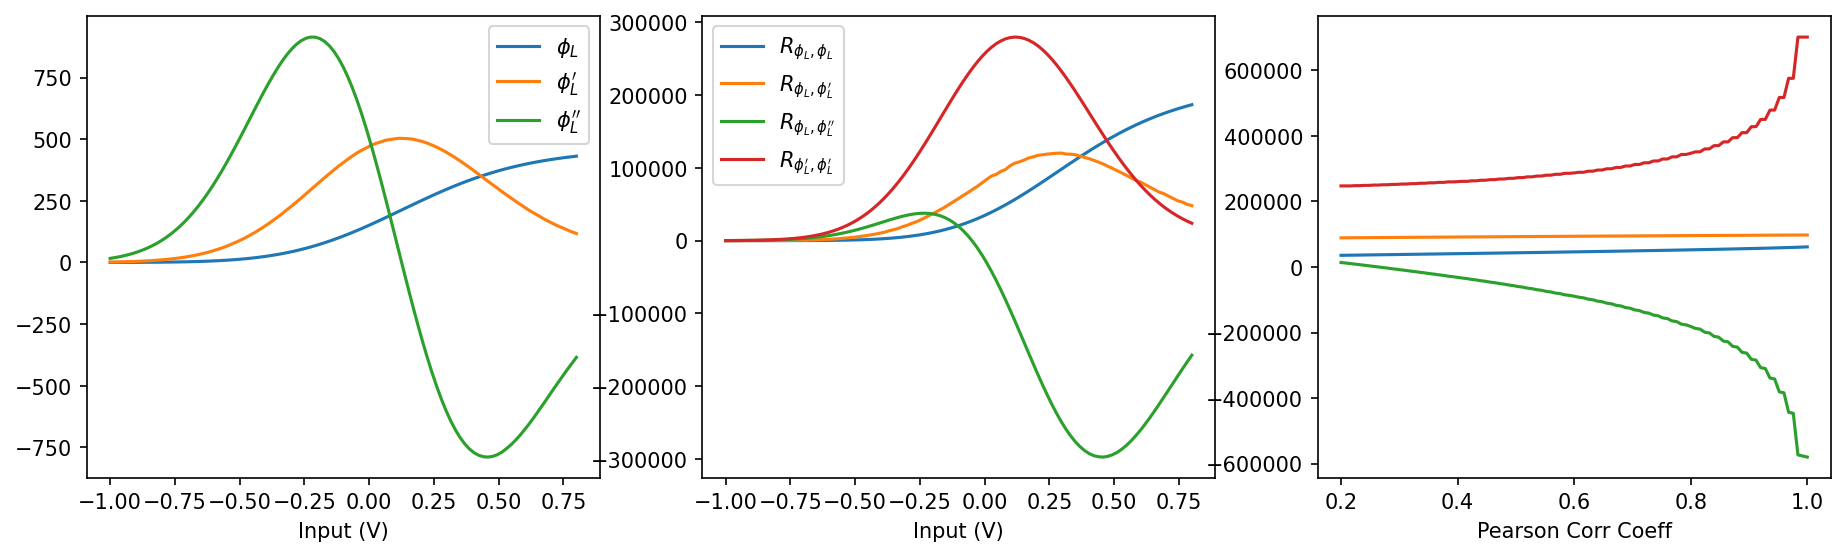

In [45]:
fig,axs = plt.subplots(1,3,figsize=(15,4),dpi=150)

mus = np.linspace(-1,0.8,101)
covs = 0.1*np.linspace(0.2,1.0,101)

axs[0].plot(mus,MFL(mus,0.1),label=r'$\phi_L$')
axs[0].plot(mus,MFPL(mus,0.1),label=r'$\phi^\prime_L$')
axs[0].plot(mus,MFPPL(mus,0.1),label=r'$\phi^{\prime\prime}_L$')

axs[1].plot(mus,CFFL(mus,0.1,0.05),label=r'$R_{\phi_L,\phi_L}$')
axs[1].plot(mus,CFFPL(mus,0.1,0.05),label=r'$R_{\phi_L,\phi^\prime_L}$')
axs[1].plot(mus,CFFPPL(mus,0.1,0.05),label=r'$R_{\phi_L,\phi^{\prime\prime}_L}$')
axs[1].plot(mus,CFPFPL(mus,0.1,0.05),label=r'$R_{\phi^\prime_L,\phi^\prime_L}$')

axs[2].plot(covs/0.1,CFFL(0.05,0.1,covs),label=r'$R_{\phi_L,\phi_L}$')
axs[2].plot(covs/0.1,CFFPL(0.05,0.1,covs),label=r'$R_{\phi_L,\phi^\prime_L}$')
axs[2].plot(covs/0.1,CFFPPL(0.05,0.1,covs),label=r'$R_{\phi_L,\phi^{\prime\prime}_L}$')
axs[2].plot(covs/0.1,CFPFPL(0.05,0.1,covs),label=r'$R_{\phi^\prime_L,\phi^\prime_L}$')

axs[0].legend()
axs[1].legend()

axs[0].set_xlabel(r'Input (V)')
axs[1].set_xlabel(r'Input (V)')
axs[2].set_xlabel(r'Pearson Corr Coeff')

In [69]:
bφ = np.array([MFL(res_dict_decoup['mub'][0],res_dict_decoup['Sigb'][0,0])[0],
               MFI(res_dict_decoup['mub'][1],res_dict_decoup['Sigb'][1,0])[0]])
bφp = np.array([MFPL(res_dict_decoup['mub'][0],res_dict_decoup['Sigb'][0,0])[0],
                MFPI(res_dict_decoup['mub'][1],res_dict_decoup['Sigb'][1,0])[0]])
bφpp = np.array([MFPPL(res_dict_decoup['mub'][0],res_dict_decoup['Sigb'][0,0])[0],
                 MFPPI(res_dict_decoup['mub'][1],res_dict_decoup['Sigb'][1,0])[0]])
pφ = np.array([MFL(res_dict_decoup['mup'][0],res_dict_decoup['Sigp'][0,0])[0],
               MFI(res_dict_decoup['mup'][1],res_dict_decoup['Sigp'][1,0])[0]])
pφp = np.array([MFPL(res_dict_decoup['mup'][0],res_dict_decoup['Sigp'][0,0])[0],
                MFPI(res_dict_decoup['mup'][1],res_dict_decoup['Sigp'][1,0])[0]])
pφpp = np.array([MFPPL(res_dict_decoup['mup'][0],res_dict_decoup['Sigp'][0,0])[0],
                 MFPPI(res_dict_decoup['mup'][1],res_dict_decoup['Sigp'][1,0])[0]])

bRφφ = np.array([[CFFL(res_dict_decoup['mub'][0],
                       res_dict_decoup['Sigb'][0,0],cov)[0] for cov in res_dict_decoup['Sigb'][0]],
                 [CFFI(res_dict_decoup['mub'][1],
                       res_dict_decoup['Sigb'][1,0],cov)[0] for cov in res_dict_decoup['Sigb'][1]]])
bRφφp = np.array([[CFFPL(res_dict_decoup['mub'][0],
                         res_dict_decoup['Sigb'][0,0],cov)[0] for cov in res_dict_decoup['Sigb'][0]],
                  [CFFPI(res_dict_decoup['mub'][1],
                         res_dict_decoup['Sigb'][1,0],cov)[0] for cov in res_dict_decoup['Sigb'][1]]])
bRφφpp = np.array([[CFFPPL(res_dict_decoup['mub'][0],
                           res_dict_decoup['Sigb'][0,0],cov)[0] for cov in res_dict_decoup['Sigb'][0]],
                   [CFFPPI(res_dict_decoup['mub'][1],
                           res_dict_decoup['Sigb'][1,0],cov)[0] for cov in res_dict_decoup['Sigb'][1]]])
bRφpφp = np.array([[CFPFPL(res_dict_decoup['mub'][0],
                           res_dict_decoup['Sigb'][0,0],cov)[0] for cov in res_dict_decoup['Sigb'][0]],
                   [CFPFPI(res_dict_decoup['mub'][1],
                           res_dict_decoup['Sigb'][1,0],cov)[0] for cov in res_dict_decoup['Sigb'][1]]])
pRφφ = np.array([[CFFL(res_dict_decoup['mup'][0],
                       res_dict_decoup['Sigp'][0,0],cov)[0] for cov in res_dict_decoup['Sigp'][0]],
                 [CFFI(res_dict_decoup['mup'][1],
                       res_dict_decoup['Sigp'][1,0],cov)[0] for cov in res_dict_decoup['Sigp'][1]]])
pRφφp = np.array([[CFFPL(res_dict_decoup['mup'][0],
                         res_dict_decoup['Sigp'][0,0],cov)[0] for cov in res_dict_decoup['Sigp'][0]],
                  [CFFPI(res_dict_decoup['mup'][1],
                         res_dict_decoup['Sigp'][1,0],cov)[0] for cov in res_dict_decoup['Sigp'][1]]])
pRφφpp = np.array([[CFFPPL(res_dict_decoup['mup'][0],
                           res_dict_decoup['Sigp'][0,0],cov)[0] for cov in res_dict_decoup['Sigp'][0]],
                   [CFFPPI(res_dict_decoup['mup'][1],
                           res_dict_decoup['Sigp'][1,0],cov)[0] for cov in res_dict_decoup['Sigp'][1]]])
pRφpφp = np.array([[CFPFPL(res_dict_decoup['mup'][0],
                           res_dict_decoup['Sigp'][0,0],cov)[0] for cov in res_dict_decoup['Sigp'][0]],
                   [CFPFPI(res_dict_decoup['mup'][1],
                           res_dict_decoup['Sigp'][1,0],cov)[0] for cov in res_dict_decoup['Sigp'][1]]])

bRφφpp = smooth_func(bRφφpp,dt)#,12)
bRφpφp = smooth_func(bRφpφp,dt)#,12)
pRφφpp = smooth_func(pRφφpp,dt)#,12)
pRφpφp = smooth_func(pRφpφp,dt)#,12)

In [71]:
NP = res_dict_init['Sigb'].shape[0]
NT = res_dict_init['Sigb'].shape[1]
dt = 0.01/5
ts = np.arange(NT)*dt

L = np.zeros((NT,NT))
L[(np.arange(NT), np.arange(NT))] = -2/dt**2
L[(np.arange(NT-1), np.arange(1,NT))] = 1/dt**2
L[(np.arange(1,NT), np.arange(NT-1))] = 1/dt**2
L[0,1] = 2/dt**2
L[-1,-1] = -1/dt**2
# L[-1,-2] = 2/dt**2

δ = np.concatenate(([1],np.zeros(NT-1)))

Abb = np.eye(NP) - bφp[:,None] * muWbb
Bbb = -0.5 * bφpp[:,None,None] * SigWbb[:,:,None] * δ[None,None,:]
Cbb = -2 * bRφφp[:,:,None] * muWbb[:,None,:]
Dbb = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
    - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:] +\
    - bRφpφp[:,:,None,None] * SigWbb[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
    - bRφφpp[:,:,None,None] * SigWbb[:,None,:,None] * δ[None,None,None,:]

Abp = - bφp[:,None] * muWbp
Bbp = -0.5 * bφpp[:,None,None] * SigWbp[:,:,None] * δ[None,None,:]
Cbp = -2 * bRφφp[:,:,None] * muWbp[:,None,:]
Dbp = - bRφpφp[:,:,None,None] * SigWbp[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
    - bRφφpp[:,:,None,None] * SigWbp[:,None,:,None] * δ[None,None,None,:]

Apb = - pφp[:,None] * muWpb
Bpb = -0.5 * pφpp[:,None,None] * SigWpb[:,:,None] * δ[None,None,:]
Cpb = -2 * pRφφp[:,:,None] * muWpb[:,None,:]
Dpb = - pRφpφp[:,:,None,None] * SigWpb[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
    - pRφφpp[:,:,None,None] * SigWpb[:,None,:,None] * δ[None,None,None,:]

App = np.eye(NP) - pφp[:,None] * muWpp
Bpp = -0.5 * pφpp[:,None,None] * SigWpp[:,:,None] * δ[None,None,:]
Cpp = -2 * pRφφp[:,:,None] * muWpp[:,None,:]
Dpp = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
    - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:] +\
    - pRφpφp[:,:,None,None] * SigWpp[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
    - pRφφpp[:,:,None,None] * SigWpp[:,None,:,None] * δ[None,None,None,:]
    
D0dis = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
    - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:]

_,S0dis,_ = np.linalg.svd(D0dis.reshape(NP*NT,NP*NT))
# Ubb,Sbb,VHbb = np.linalg.svd(Dbb.reshape(NP*NT,NP*NT))
# Upp,Spp,VHpp = np.linalg.svd(Dpp.reshape(NP*NT,NP*NT))
# Dbb = (Ubb@np.diag(np.fmax(np.min(S0dis),Sbb))@VHbb).reshape(NP,NT,NP,NT)
# Dpp = (Upp@np.diag(np.fmax(np.min(S0dis),Spp))@VHpp).reshape(NP,NT,NP,NT)

In [72]:
def svd_inv(A,reg=0):
    U,S,VH = np.linalg.svd(A)
    Sinv = 1/S
    Sinv[S < reg] = 0#S[S < reg]
    return VH.T@np.diag(Sinv)@U.T

def svd_solve(A,b,reg=0):
    U,S,VH = np.linalg.svd(A)
    Sinv = 1/S
    Sinv[S < reg] = 0#S[S < reg]
    return VH.T@np.diag(Sinv)@U.T@b

In [89]:
Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
Mbp = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mpb = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
Mpp = np.block([[App,Bpp.reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])

# Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])
# Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),np.zeros_like(Dbp).reshape(NP*NT,NP*NT)]])
# Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),np.zeros_like(Dpb).reshape(NP*NT,NP*NT)]])
# Mpp0dis = np.block([[App,np.zeros_like(Bpp).reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])

# Mbb0dis = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
# Mbp0dis = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
Mpp0dis = np.block([[App,np.zeros_like(Bpp).reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])

Mbb1dis = np.block([[np.zeros((NP,NP)),Bbb.reshape(NP,NP*NT)],[np.zeros((NP*NT,NP)),np.zeros((NP*NT,NP*NT))]])
Mbp1dis = np.block([[np.zeros((NP,NP)),Bbp.reshape(NP,NP*NT)],[np.zeros((NP*NT,NP)),np.zeros((NP*NT,NP*NT))]])
Mpb1dis = np.block([[np.zeros((NP,NP)),Bpb.reshape(NP,NP*NT)],[np.zeros((NP*NT,NP)),np.zeros((NP*NT,NP*NT))]])
Mpp1dis = np.block([[np.zeros((NP,NP)),Bpp.reshape(NP,NP*NT)],[np.zeros((NP*NT,NP)),np.zeros((NP*NT,NP*NT))]])

δmb0 = np.concatenate([δrb0,δCrb0.flatten()])
δmp0 = np.concatenate([δrp0,δCrp0.flatten()])

fb = Mbb@δmb0
fp = Mpp@δmp0

M = np.block([[Mbb,Mbp],[Mpb,Mpp]])
M0dis = np.block([[Mbb0dis,Mbp0dis],[Mpb0dis,Mpp0dis]])
f = np.concatenate([fb,fp])

δm = np.linalg.solve(M,f)
δm0dis = np.linalg.solve(M0dis,f)

δmb = δm[:NP+NP*NT]
δmp = δm[NP+NP*NT:]

δmb0dis = δm0dis[:NP+NP*NT]
δmp0dis = δm0dis[NP+NP*NT:]

δrb = δmb[:NP]
δCrb = δmb[NP:].reshape(NP,NT)
δrp = δmp[:NP]
δCrp = δmp[NP:].reshape(NP,NT)

δrb0dis = δmb0dis[:NP]
δCrb0dis = δmb0dis[NP:].reshape(NP,NT)
δrp0dis = δmp0dis[:NP]
δCrp0dis = δmp0dis[NP:].reshape(NP,NT)

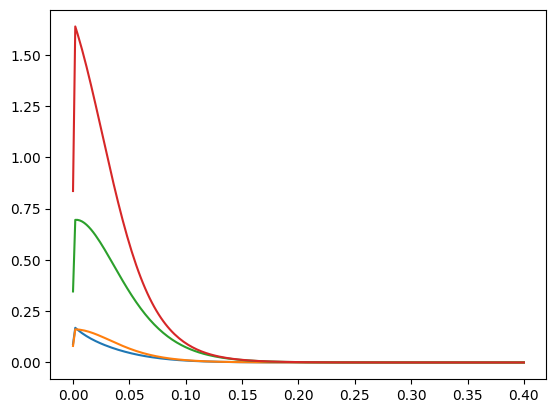

In [74]:
plt.plot((np.arange((NT))*dt),np.linalg.inv(Dbb.reshape(NP*NT,NP*NT)).reshape(NP,NT,NP,NT)[:,0,:,:].reshape(-1,NT).T)

In [75]:
print(δmb0[:2])
print(δmp0[:2])
print()
print(δmb[:2])
print(δmp[:2])

[3.3925219 5.5797977]
[5.5653305 2.80867  ]

[3.34044965 5.36339116]
[0.18589086 3.74914917]


In [76]:
np.max(np.abs(np.linalg.eig(np.linalg.inv(np.block([[Mbb,np.zeros_like(Mbp)],[Mpb,Mpp]]))@\
    np.block([[np.zeros_like(Mbb),Mbp],[np.zeros_like(Mpb),np.zeros_like(Mpp)]]))[0]))

0.30413387946971704

In [86]:
np.max(np.abs(np.linalg.eig(np.linalg.inv(np.block([[Mbb0dis,np.zeros_like(Mbp0dis)],[Mpb0dis,Mpp0dis]]))@\
    np.block([[np.zeros_like(Mbb0dis),Mbp0dis],[np.zeros_like(Mpb0dis),np.zeros_like(Mpp0dis)]]))[0]))

2.1752179514514522

In [78]:
np.max(np.abs(np.linalg.eig(np.linalg.inv(np.block([[Mbb,np.zeros_like(Mbp)],[np.zeros_like(Mpb),Mpp]]))@\
    np.block([[np.zeros_like(Mbb),Mbp],[Mpb,np.zeros_like(Mpp)]]))[0]))

0.5514833446892532

In [79]:
np.max(np.abs(np.linalg.eig(np.linalg.inv(np.block([[Mbb0dis,Mbp0dis],[Mpb0dis,Mpp0dis]]))@\
    np.block([[Mbb1dis,Mbp1dis],[Mpb1dis,Mpp1dis]]))[0]))

2.990600008624716

In [80]:
sim_dr = np.array([2.8632733 , 0.46012648, 0.31349788, 0.13982971, 0.05703189, 0.02666332])
sim_dstdr = np.array([15.64064821, 10.74145532,  9.67937987,  8.40606301,  7.96817521, 7.86632242])

sim_rvE = np.array([68.97733867, 55.62796466, 30.52583861, 12.9365711 ,  6.23059766,
        5.02963256,  5.67675831,  7.122793  ,  9.31705425, 10.7507899 ,
       11.62559419, 10.84714221,  9.19416534,  7.4510832 ,  5.80674291,
        5.05020631,  6.43007453, 12.91497832, 30.21023504, 55.28638687])
sim_rvI = np.array([42.22267755, 44.2655882 , 39.85187656, 35.78976117, 32.5092976 ,
       29.77520101, 26.33714218, 24.00078065, 20.9543997 , 19.96423943,
       18.52759328, 19.79796247, 21.77673685, 23.3321855 , 26.42613705,
       29.03981693, 33.32299897, 35.82229191, 40.3377957 , 42.45983409])

sim_roE = np.array([68.12356329, 55.62542769, 32.76158408, 16.77672343, 10.0900948 ,
        9.2486116 ,  9.66629388, 11.08456271, 12.45318941, 13.71325399,
       14.07155846, 13.78208456, 12.60230108, 11.06283618,  9.65569521,
        9.04009163, 10.13569005, 16.84672337, 32.28955217, 55.36414603])
sim_roI = np.array([45.77109566, 47.5042508 , 43.77013266, 40.34887994, 37.1388502 ,
       34.27780032, 32.25961519, 28.43824625, 26.22238183, 25.52519509,
       24.38144881, 25.525264  , 27.13649654, 28.63389435, 31.0277583 ,
       33.99121783, 37.36871739, 40.291363  , 43.58412479, 47.81088607])

sim_std_rvE = np.array([42.10519423, 39.7132907 , 31.28676259, 19.5746686 , 12.2799577 ,
       10.32652004, 10.61166957, 11.45794762, 12.91249399, 13.45310985,
       14.06741991, 13.61160906, 12.69215476, 11.76546235, 10.66237776,
       10.4683471 , 12.68349306, 19.54980369, 30.82531814, 39.5125641 ])
sim_std_rvI = np.array([66.02189259, 67.16863276, 63.95849201, 59.38342017, 54.75481557,
       50.28232267, 46.85709882, 43.36562633, 38.46335062, 36.44943882,
       35.38743924, 37.15797238, 38.92180719, 41.84712986, 46.35560574,
       50.79675898, 56.18926841, 59.45078842, 64.18852714, 66.45435967])

sim_std_roE = np.array([51.29680636, 48.58114268, 42.72370156, 34.13558415, 29.29143991,
       28.74414667, 29.53162426, 30.70441223, 30.61329712, 32.23168274,
       31.3706999 , 32.11373282, 31.18344056, 29.94073522, 28.45273394,
       28.30573962, 27.86295617, 34.37949692, 41.90246766, 49.28480156])
sim_std_roI = np.array([72.49110033, 73.29698759, 70.69122907, 66.79029227, 63.46540254,
       59.01493962, 56.13497679, 51.70726138, 49.19097429, 47.59169756,
       46.18178629, 47.39486643, 49.50127206, 52.33215921, 55.22989533,
       59.41658148, 63.60638401, 66.1437379 , 69.65726529, 73.03645928])

In [90]:
nori = 20

oris = np.arange(nori//2+1) * 90/(nori/2)
def gauss(x,b,p,s):
    return b + (p-b)*dmft.basesubwrapnorm(x,s)

rvE = gauss(oris,rvb[0],rvp[0],sr[0])
rvI = gauss(oris,rvb[1],rvp[1],sr[1])
roE = gauss(oris,rob[0],rop[0],sr[0])
roI = gauss(oris,rob[1],rop[1],sr[1])

drE0 = gauss(oris,δrb0[0],δrp0[0],sr[0])
drI0 = gauss(oris,δrb0[1],δrp0[1],sr[1])
drE = gauss(oris,δrb[0],δrp[0],sr[0])
drI = gauss(oris,δrb[1],δrp[1],sr[1])
drE0dis = gauss(oris,δrb0dis[0],δrp0dis[0],sr[0])
drI0dis = gauss(oris,δrb0dis[1],δrp0dis[1],sr[1])

CrvE = gauss(oris,dmft.grid_stat(np.mean,Crvb[0:0+1],1,dt),dmft.grid_stat(np.mean,Crvp[0:0+1],1,dt),sr[0])
CrvI = gauss(oris,dmft.grid_stat(np.mean,Crvb[1:1+1],1,dt),dmft.grid_stat(np.mean,Crvp[1:1+1],1,dt),sr[1])
CroE = gauss(oris,dmft.grid_stat(np.mean,Crob[0:0+1],1,dt),dmft.grid_stat(np.mean,Crop[0:0+1],1,dt),sr[0])
CroI = gauss(oris,dmft.grid_stat(np.mean,Crob[1:1+1],1,dt),dmft.grid_stat(np.mean,Crop[1:1+1],1,dt),sr[1])

dCrE0 = gauss(oris,dmft.grid_stat(np.mean,δCrb0[0:0+1],1,dt),dmft.grid_stat(np.mean,δCrp0[0:0+1],1,dt),sr[0])
dCrI0 = gauss(oris,dmft.grid_stat(np.mean,δCrb0[1:1+1],1,dt),dmft.grid_stat(np.mean,δCrp0[1:1+1],1,dt),sr[1])
dCrE = gauss(oris,dmft.grid_stat(np.mean,δCrb[0:0+1],1,dt),
              dmft.grid_stat(np.mean,δCrp[0:0+1],1,dt),sr[0])
dCrI = gauss(oris,dmft.grid_stat(np.mean,δCrb[1:1+1],1,dt),
              dmft.grid_stat(np.mean,δCrp[1:1+1],1,dt),sr[1])
dCrE0dis = gauss(oris,dmft.grid_stat(np.mean,δCrb0dis[0:0+1],1,dt),
              dmft.grid_stat(np.mean,δCrp0dis[0:0+1],1,dt),sr[0])
dCrI0dis = gauss(oris,dmft.grid_stat(np.mean,δCrb0dis[1:1+1],1,dt),
              dmft.grid_stat(np.mean,δCrp0dis[1:1+1],1,dt),sr[1])

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_39262/1867511569.py:41: RuntimeWarning: invalid value encountered in sqrt
  axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0dis-(rvE+drE0dis)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='-.',alpha=0.7)
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_39262/1867511569.py:46: RuntimeWarning: invalid value encountered in sqrt
  axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0dis-(rvI+drI0dis)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='-.',alpha=0.7)


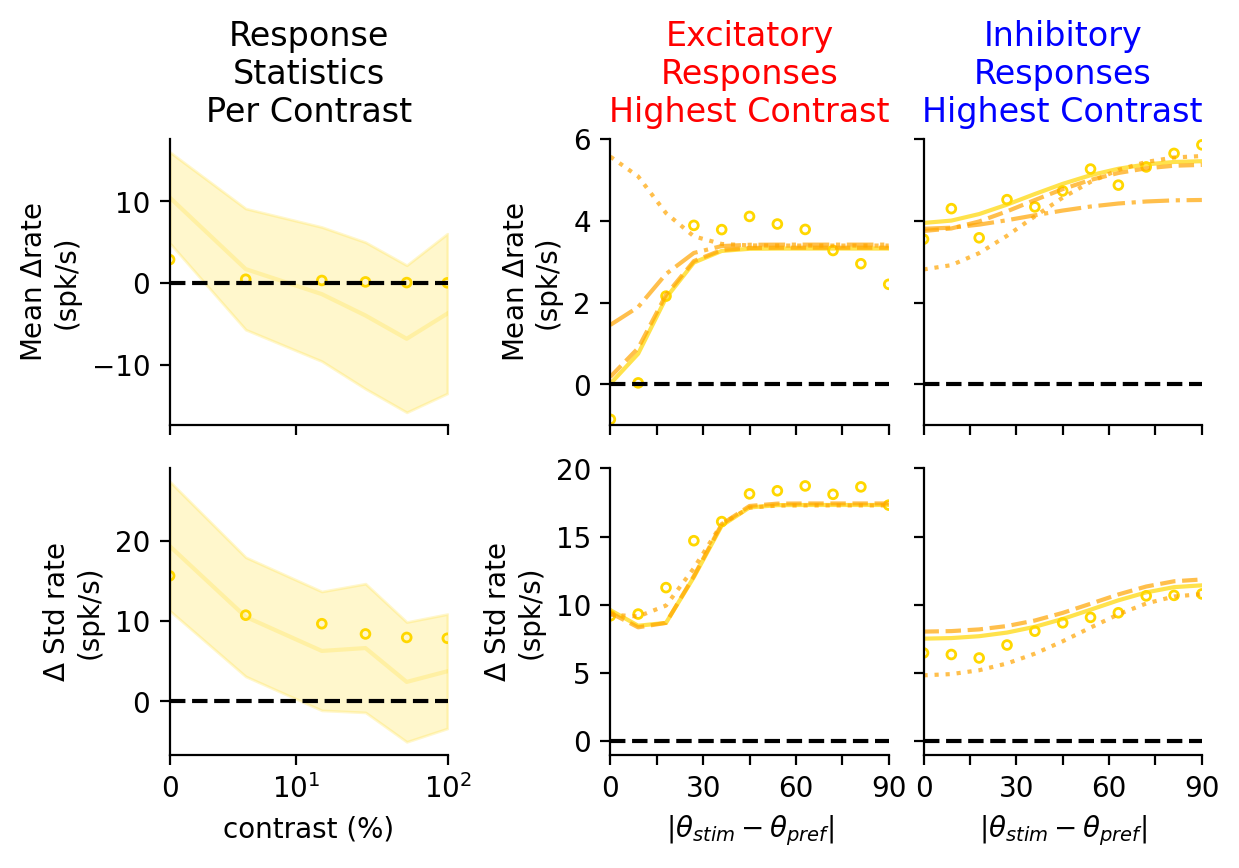

In [91]:
with open('./data_moments'+'.pkl', 'rb') as handle:
    data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
data_dr = np.concatenate([data_preds[:,1,0:1]-data_preds[:,0,0:1],
                          np.sqrt(data_preds[:,1,1:2]**2+data_preds[:,0,1:2]**2)],-1)
data_dstdr = np.concatenate([data_preds[:,3,0:1]-data_preds[:,2,0:1],
                             np.sqrt(data_preds[:,3,1:2]**2+data_preds[:,2,1:2]**2)],-1)
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]

def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

fig,axs = plt.subplots(2,4,figsize=(2*3.33,2*2),dpi=200,sharex='col',width_ratios=(3,1,3,3))
fig.subplots_adjust(hspace=0.15,wspace=0.15)
for i in range(2):
    axs[i,1].set_axis_off()
    axs[i,2].yaxis.set_tick_params(which='both',labelleft=True)
    axs[i,3].yaxis.set_tick_params(which='both',labelleft=False)
axs = axs[:,[0,2,3]]

axs[0,0].plot(cons,data_dr[:,0],color='gold',alpha=0.2)
axs[0,0].fill_between(cons,data_dr[:,0]-data_dr[:,1],data_dr[:,0]+data_dr[:,1],color='gold',alpha=0.2)
axs[0,0].scatter(cons,sim_dr,edgecolors='gold',facecolors='none',marker='o',s=10)
axs[0,1].plot(oris,roE-rvE,c='gold',ls='-',alpha=0.7,label='a')
axs[0,1].plot(oris,drE0,c='orange',ls=':',alpha=0.7,label='a')
axs[0,1].plot(oris,drE,c='orange',ls='--',alpha=0.7,label='a')
axs[0,1].plot(oris,drE0dis,c='orange',ls='-.',alpha=0.7,label='a')
# axs[0,1].legend()
axs[0,1].scatter(oris,abs_ori(sim_roE-sim_rvE),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[0,2].plot(oris,roI-rvI,c='gold',ls='-',alpha=0.7)
axs[0,2].plot(oris,drI0,c='orange',ls=':',alpha=0.7)
axs[0,2].plot(oris,drI,c='orange',ls='--',alpha=0.7)
axs[0,2].plot(oris,drI0dis,c='orange',ls='-.',alpha=0.7)
axs[0,2].scatter(oris,abs_ori(sim_roI-sim_rvI),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,0].plot(cons,data_dstdr[:,0],color='gold',alpha=0.2)
axs[1,0].fill_between(cons,data_dstdr[:,0]-data_dstdr[:,1],data_dstdr[:,0]+data_dstdr[:,1],color='gold',alpha=0.2)
axs[1,0].scatter(cons,sim_dstdr,edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,1].plot(oris,np.sqrt(CroE-roE**2)-np.sqrt(CrvE-rvE**2),c='gold',ls='-',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0-(rvE+drE0)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls=':',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE-(rvE+drE)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='--',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0dis-(rvE+drE0dis)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='-.',alpha=0.7)
axs[1,1].scatter(oris,abs_ori(sim_std_roE-sim_std_rvE),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,2].plot(oris,np.sqrt(CroI-roI**2)-np.sqrt(CrvI-rvI**2),c='gold',ls='-',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0-(rvI+drI0)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls=':',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI-(rvI+drI)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='--',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0dis-(rvI+drI0dis)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='-.',alpha=0.7)
axs[1,2].scatter(oris,abs_ori(sim_std_roI-sim_std_rvI),edgecolors='gold',facecolors='none',marker='o',s=10)

for i in range(2):
    for j in range(3):
        axs[i,j].axhline(0,c='k',ls='--')
    
# axs[0,1].legend()
# axs[1,1].legend()
# axs[2,1].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

axs[0,0].set_xscale('symlog', linthresh=12)
nticks = 7
ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
ticks[1::2] = ''
for i in range(1,3):
    axs[1,i].set_xticks(np.linspace(0,90,7),ticks)

axs[0,0].set_xlim(0,100)
axs[0,1].set_xlim(0,90)
axs[0,2].set_xlim(0,90)
for i in range(1,3):
    axs[0,i].set_ylim(-1,6)
    axs[1,i].set_ylim(-1,20)

axs[1,0].set_xlabel('contrast (%)')
axs[1,1].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
axs[1,2].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

for i in range(2):
    axs[0,i].set_ylabel(r'Mean $\Delta$rate'+'\n(spk/s)')
    axs[1,i].set_ylabel(r'$\Delta$ Std rate'+'\n(spk/s)')

axs[0,0].set_title('Response\nStatistics\nPer Contrast',color='k')
axs[0,1].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[0,2].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

# fig.tight_layout()
fig.savefig('./../plots/delta_rate_lin_resp_test.pdf')

# Calculate Linear Response for All Contrasts

In [244]:
res_dict_inits = [None]*6
res_dict_perts = [None]*6

for c_idx in range(6):
    with open('./../results/dmft_best_fit_id_None_c_{:d}'.format(c_idx)+'.pkl','rb') as\
            handle:
        this_res_dict = pickle.load(handle)['dmft_res']
    if c_idx==0:
        res_dict_inits[c_idx] = {key: this_res_dict[key][:2] for key in ['r','Cr','mu','Sig']}
        res_dict_perts[c_idx] = {key: this_res_dict[key][2:] for key in ['r','Cr','mu','Sig']}
    else:
        res_dict_inits[c_idx] = {key: this_res_dict[key][:2] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                                         'mub','mup','Sigb','Sigp']}
        res_dict_perts[c_idx] = {key: this_res_dict[key][2:] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                                         'mub','mup','Sigb','Sigp']}

In [94]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/5

res_dict_decoups = [None]*6

for c_idx in range(1,6):
    res_dict_decoups[c_idx] = dmft.run_decoupled_two_site_dmft(prms,bX,aXs[c_idx]/bX,eX,'./../results',ri,Twrm,Tsav,dt,
                                                               struct_dict=res_dict_inits[c_idx],
                                                               which='opto',return_full=True)

0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 232.9823550000001 s
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 231.96489599999973 s
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 242.0571789999999 s
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 217.775752 s
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integratin

In [95]:
SoriE = prms['SoriE']
SoriI = prms['SoriI']

sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
sW2 = sW**2
sWr = np.sqrt(sW2+sr**2)
sWCr = np.sqrt(sW2+sCr**2)

muWbb = (1 - dmft.struct_fact(180/2,sWr,sr,180)) * muW
muWbp = dmft.struct_fact(180/2,sWr,sr,180) * muW
muWpb = (1 - dmft.struct_fact(0,sWr,sr,180)) * muW
muWpp = dmft.struct_fact(0,sWr,sr,180) * muW

SigWbb = (1 - dmft.struct_fact(180/2,sWCr,sCr,180)) * SigW
SigWbp = dmft.struct_fact(180/2,sWCr,sCr,180) * SigW
SigWpb = (1 - dmft.struct_fact(0,sWCr,sCr,180)) * SigW
SigWpp = dmft.struct_fact(0,sWCr,sCr,180) * SigW

NP = 2
NT = int(np.round(Tsav/dt)+1)
ts = np.arange(NT)*dt

L = np.zeros((NT,NT))
L[(np.arange(NT), np.arange(NT))] = -2/dt**2
L[(np.arange(NT-1), np.arange(1,NT))] = 1/dt**2
L[(np.arange(1,NT), np.arange(NT-1))] = 1/dt**2
L[0,1] = 2/dt**2
L[-1,-1] = -1/dt**2
# L[-1,-2] = 2/dt**2

δ = np.concatenate(([1],np.zeros(NT-1)))

In [96]:
def calc_lin_resp(res_dict_init,res_dict_decoup):
    δrb0 = res_dict_decoup['rb'] - res_dict_init['rb']
    δrp0 = res_dict_decoup['rp'] - res_dict_init['rp']
    δCrb0 = res_dict_decoup['Crb'] - res_dict_init['Crb']
    δCrp0 = res_dict_decoup['Crp'] - res_dict_init['Crp']
    
    bφ = np.array([MFL(res_dict_decoup['mub'][0],res_dict_decoup['Sigb'][0,0])[0],
                   MFI(res_dict_decoup['mub'][1],res_dict_decoup['Sigb'][1,0])[0]])
    bφp = np.array([MFPL(res_dict_decoup['mub'][0],res_dict_decoup['Sigb'][0,0])[0],
                    MFPI(res_dict_decoup['mub'][1],res_dict_decoup['Sigb'][1,0])[0]])
    bφpp = np.array([MFPPL(res_dict_decoup['mub'][0],res_dict_decoup['Sigb'][0,0])[0],
                     MFPPI(res_dict_decoup['mub'][1],res_dict_decoup['Sigb'][1,0])[0]])
    pφ = np.array([MFL(res_dict_decoup['mup'][0],res_dict_decoup['Sigp'][0,0])[0],
                   MFI(res_dict_decoup['mup'][1],res_dict_decoup['Sigp'][1,0])[0]])
    pφp = np.array([MFPL(res_dict_decoup['mup'][0],res_dict_decoup['Sigp'][0,0])[0],
                    MFPI(res_dict_decoup['mup'][1],res_dict_decoup['Sigp'][1,0])[0]])
    pφpp = np.array([MFPPL(res_dict_decoup['mup'][0],res_dict_decoup['Sigp'][0,0])[0],
                     MFPPI(res_dict_decoup['mup'][1],res_dict_decoup['Sigp'][1,0])[0]])

    bRφφ = np.array([[CFFL(res_dict_decoup['mub'][0],
                           res_dict_decoup['Sigb'][0,0],cov)[0] for cov in res_dict_decoup['Sigb'][0]],
                    [CFFI(res_dict_decoup['mub'][1],
                          res_dict_decoup['Sigb'][1,0],cov)[0] for cov in res_dict_decoup['Sigb'][1]]])
    bRφφp = np.array([[CFFPL(res_dict_decoup['mub'][0],
                             res_dict_decoup['Sigb'][0,0],cov)[0] for cov in res_dict_decoup['Sigb'][0]],
                    [CFFPI(res_dict_decoup['mub'][1],
                           res_dict_decoup['Sigb'][1,0],cov)[0] for cov in res_dict_decoup['Sigb'][1]]])
    bRφφpp = np.array([[CFFPPL(res_dict_decoup['mub'][0],
                            res_dict_decoup['Sigb'][0,0],cov)[0] for cov in res_dict_decoup['Sigb'][0]],
                    [CFFPPI(res_dict_decoup['mub'][1],
                            res_dict_decoup['Sigb'][1,0],cov)[0] for cov in res_dict_decoup['Sigb'][1]]])
    bRφpφp = np.array([[CFPFPL(res_dict_decoup['mub'][0],
                            res_dict_decoup['Sigb'][0,0],cov)[0] for cov in res_dict_decoup['Sigb'][0]],
                    [CFPFPI(res_dict_decoup['mub'][1],
                            res_dict_decoup['Sigb'][1,0],cov)[0] for cov in res_dict_decoup['Sigb'][1]]])
    pRφφ = np.array([[CFFL(res_dict_decoup['mup'][0],
                        res_dict_decoup['Sigp'][0,0],cov)[0] for cov in res_dict_decoup['Sigp'][0]],
                    [CFFI(res_dict_decoup['mup'][1],
                        res_dict_decoup['Sigp'][1,0],cov)[0] for cov in res_dict_decoup['Sigp'][1]]])
    pRφφp = np.array([[CFFPL(res_dict_decoup['mup'][0],
                            res_dict_decoup['Sigp'][0,0],cov)[0] for cov in res_dict_decoup['Sigp'][0]],
                    [CFFPI(res_dict_decoup['mup'][1],
                            res_dict_decoup['Sigp'][1,0],cov)[0] for cov in res_dict_decoup['Sigp'][1]]])
    pRφφpp = np.array([[CFFPPL(res_dict_decoup['mup'][0],
                            res_dict_decoup['Sigp'][0,0],cov)[0] for cov in res_dict_decoup['Sigp'][0]],
                    [CFFPPI(res_dict_decoup['mup'][1],
                            res_dict_decoup['Sigp'][1,0],cov)[0] for cov in res_dict_decoup['Sigp'][1]]])
    pRφpφp = np.array([[CFPFPL(res_dict_decoup['mup'][0],
                            res_dict_decoup['Sigp'][0,0],cov)[0] for cov in res_dict_decoup['Sigp'][0]],
                    [CFPFPI(res_dict_decoup['mup'][1],
                            res_dict_decoup['Sigp'][1,0],cov)[0] for cov in res_dict_decoup['Sigp'][1]]])

    bRφφpp = smooth_func(bRφφpp,dt)
    bRφpφp = smooth_func(bRφpφp,dt)
    pRφφpp = smooth_func(pRφφpp,dt)
    pRφpφp = smooth_func(pRφpφp,dt)

    Abb = np.eye(NP) - bφp[:,None] * muWbb
    Bbb = -0.5 * bφpp[:,None,None] * SigWbb[:,:,None] * δ[None,None,:]
    Cbb = -2 * bRφφp[:,:,None] * muWbb[:,None,:]
    Dbb = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
        - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:] +\
        - bRφpφp[:,:,None,None] * SigWbb[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
        - bRφφpp[:,:,None,None] * SigWbb[:,None,:,None] * δ[None,None,None,:]

    Abp = - bφp[:,None] * muWbp
    Bbp = -0.5 * bφpp[:,None,None] * SigWbp[:,:,None] * δ[None,None,:]
    Cbp = -2 * bRφφp[:,:,None] * muWbp[:,None,:]
    Dbp = - bRφpφp[:,:,None,None] * SigWbp[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
        - bRφφpp[:,:,None,None] * SigWbp[:,None,:,None] * δ[None,None,None,:]

    Apb = - pφp[:,None] * muWpb
    Bpb = -0.5 * pφpp[:,None,None] * SigWpb[:,:,None] * δ[None,None,:]
    Cpb = -2 * pRφφp[:,:,None] * muWpb[:,None,:]
    Dpb = - pRφpφp[:,:,None,None] * SigWpb[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
        - pRφφpp[:,:,None,None] * SigWpb[:,None,:,None] * δ[None,None,None,:]

    App = np.eye(NP) - pφp[:,None] * muWpp
    Bpp = -0.5 * pφpp[:,None,None] * SigWpp[:,:,None] * δ[None,None,:]
    Cpp = -2 * pRφφp[:,:,None] * muWpp[:,None,:]
    Dpp = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
        - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:] +\
        - pRφpφp[:,:,None,None] * SigWpp[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
        - pRφφpp[:,:,None,None] * SigWpp[:,None,:,None] * δ[None,None,None,:]
    
    D0dis = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
        - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:]
    
    # _,S0dis,_ = np.linalg.svd(D0dis.reshape(NP*NT,NP*NT))
    # Ubb,Sbb,VHbb = np.linalg.svd(Dbb.reshape(NP*NT,NP*NT))
    # Upp,Spp,VHpp = np.linalg.svd(Dpp.reshape(NP*NT,NP*NT))
    # Dbb = (Ubb@np.diag(np.fmax(np.min(S0dis),Sbb))@VHbb).reshape(NP,NT,NP,NT)
    # Dpp = (Upp@np.diag(np.fmax(np.min(S0dis),Spp))@VHpp).reshape(NP,NT,NP,NT)
    
    Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
    Mbp = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
    Mpb = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
    Mpp = np.block([[App,Bpp.reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])

    Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
    Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
    Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
    Mpp0dis = np.block([[App,np.zeros_like(Bpp).reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])

    δmb0 = np.concatenate([δrb0,δCrb0.flatten()])
    δmp0 = np.concatenate([δrp0,δCrp0.flatten()])

    fb = Mbb@δmb0
    fp = Mpp@δmp0

    M = np.block([[Mbb,Mbp],[Mpb,Mpp]])
    M0dis = np.block([[Mbb0dis,Mbp0dis],[Mpb0dis,Mpp0dis]])
    f = np.concatenate([fb,fp])

    δm = np.linalg.solve(M,f)
    δm0dis = np.linalg.solve(M0dis,f)

    δmb = δm[:NP+NP*NT]
    δmp = δm[NP+NP*NT:]

    δmb0dis = δm0dis[:NP+NP*NT]
    δmp0dis = δm0dis[NP+NP*NT:]

    δrb = δmb[:NP]
    δCrb = δmb[NP:].reshape(NP,NT)
    δrp = δmp[:NP]
    δCrp = δmp[NP:].reshape(NP,NT)

    δrb0dis = δmb0dis[:NP]
    δCrb0dis = δmb0dis[NP:].reshape(NP,NT)
    δrp0dis = δmp0dis[:NP]
    δCrp0dis = δmp0dis[NP:].reshape(NP,NT)
    
    res_dict = {}
    
    res_dict['drb0'] = δrb0
    res_dict['drp0'] = δrp0
    res_dict['dCrb0'] = δCrb0
    res_dict['dCrp0'] = δCrp0
    res_dict['drb'] = δrb
    res_dict['drp'] = δrp
    res_dict['dCrb'] = δCrb
    res_dict['dCrp'] = δCrp
    res_dict['drb0dis'] = δrb0dis
    res_dict['drp0dis'] = δrp0dis
    res_dict['dCrb0dis'] = δCrb0dis
    res_dict['dCrp0dis'] = δCrp0dis
    
    return res_dict

In [97]:
res_dict_lin_resps = [None]*6

for c_idx in range(1,6):
    res_dict_lin_resps[c_idx] = calc_lin_resp(res_dict_inits[c_idx],res_dict_decoups[c_idx])

In [98]:
dmft_dr = np.zeros(6)
dmft_dr0 = np.zeros(6)
dmft_drfull = np.zeros(6)
dmft_dr0dis = np.zeros(6)
dmft_dstdr = np.zeros(6)
dmft_dstdr0 = np.zeros(6)
dmft_dstdrfull = np.zeros(6)
dmft_dstdr0dis = np.zeros(6)

for c_idx in range(6):
    if c_idx==0:
        dmft_dr[c_idx] = np.sum(np.array([0.8,0.2])*(res_dict_perts[c_idx]['r'] - res_dict_inits[c_idx]['r']))
        dmft_dr0[c_idx] = np.nan
        dmft_drfull[c_idx] = np.nan
        dmft_dr0dis[c_idx] = np.nan
        
        dmft_dstdr[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_perts[c_idx]['Cr'],1,dt)-res_dict_perts[c_idx]['r']**2))) -\
            np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_inits[c_idx]['Cr'],1,dt)-res_dict_inits[c_idx]['r']**2)))
        dmft_dstdr0[c_idx] = np.nan
        dmft_dstdrfull[c_idx] = np.nan
        dmft_dstdr0dis[c_idx] = np.nan
    else:
        dmft_dr[c_idx] = np.sum(np.array([0.8,0.2])*(res_dict_perts[c_idx]['rp'] - res_dict_inits[c_idx]['rp']))
        dmft_dr0[c_idx] = np.sum(np.array([0.8,0.2])*res_dict_lin_resps[c_idx]['drp0'])
        dmft_drfull[c_idx] = np.sum(np.array([0.8,0.2])*res_dict_lin_resps[c_idx]['drp'])
        dmft_dr0dis[c_idx] = np.sum(np.array([0.8,0.2])*res_dict_lin_resps[c_idx]['drp0dis'])
        
        init_varr = np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_inits[c_idx]['Crp'],1,dt)-res_dict_inits[c_idx]['rp']**2))
        dmft_dstdr[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_perts[c_idx]['Crp'],1,dt)-res_dict_perts[c_idx]['rp']**2))) -\
            np.sqrt(init_varr)
        dmft_dstdr0[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_decoups[c_idx]['Crp'],1,dt)-res_dict_decoups[c_idx]['rp']**2))) -\
            np.sqrt(init_varr)
        dmft_dstdrfull[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_inits[c_idx]['Crp']+res_dict_lin_resps[c_idx]['dCrp'],1,dt)-\
            (res_dict_inits[c_idx]['rp']+res_dict_lin_resps[c_idx]['drp'])**2))) -\
            np.sqrt(init_varr)
        dmft_dstdr0dis[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_inits[c_idx]['Crp']+res_dict_lin_resps[c_idx]['dCrp0dis'],1,dt)-\
            (res_dict_inits[c_idx]['rp']+res_dict_lin_resps[c_idx]['drp0dis'])**2))) -\
            np.sqrt(init_varr)

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_39262/1029952684.py:42: RuntimeWarning: invalid value encountered in sqrt
  dmft_dstdr0dis[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\


In [99]:
print(dmft_dr)
print(dmft_dr0)
print(dmft_drfull)
print(dmft_dr0dis)

[3.32553291 1.45615768 1.11685715 0.91701584 0.83977509 0.80113831]
[       nan 5.1755722  5.1078186  5.05428696 5.02886047 5.01399612]
[       nan 1.37006466 1.13257759 0.98574597 0.9269203  0.89853878]
[       nan 2.31727261 2.13902548 1.99753928 1.94779443 1.92360348]


In [100]:
drE0dis = gauss(oris,res_dict_lin_resps[5]['drb0dis'][0],res_dict_lin_resps[5]['drp0dis'][0],sr[0])
drI0dis = gauss(oris,res_dict_lin_resps[5]['drb0dis'][1],res_dict_lin_resps[5]['drp0dis'][1],sr[1])

dCrE0dis = gauss(oris,dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrb0dis'][0:0+1],1,dt),
              dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrp0dis'][0:0+1],1,dt),sr[0])
dCrI0dis = gauss(oris,dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrb0dis'][1:1+1],1,dt),
              dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrp0dis'][1:1+1],1,dt),sr[1])

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_39262/1389979659.py:49: RuntimeWarning: invalid value encountered in sqrt
  axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0dis-(rvE+drE0dis)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='-.',alpha=0.7)
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_39262/1389979659.py:54: RuntimeWarning: invalid value encountered in sqrt
  axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0dis-(rvI+drI0dis)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='-.',alpha=0.7)


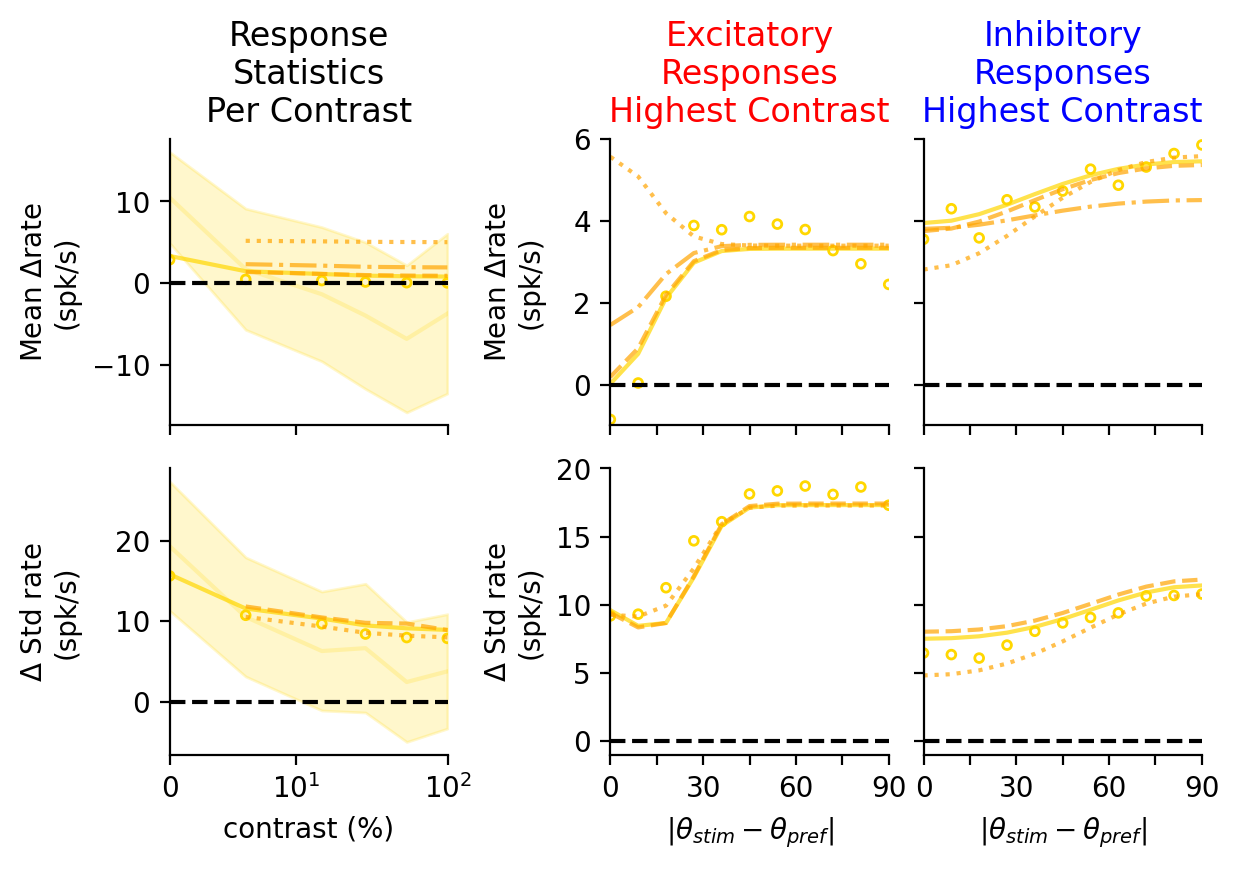

In [101]:
with open('./data_moments'+'.pkl', 'rb') as handle:
    data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
data_dr = np.concatenate([data_preds[:,1,0:1]-data_preds[:,0,0:1],
                          np.sqrt(data_preds[:,1,1:2]**2+data_preds[:,0,1:2]**2)],-1)
data_dstdr = np.concatenate([data_preds[:,3,0:1]-data_preds[:,2,0:1],
                             np.sqrt(data_preds[:,3,1:2]**2+data_preds[:,2,1:2]**2)],-1)
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]

def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

fig,axs = plt.subplots(2,4,figsize=(2*3.33,2*2),dpi=200,sharex='col',width_ratios=(3,1,3,3))
fig.subplots_adjust(hspace=0.15,wspace=0.15)
for i in range(2):
    axs[i,1].set_axis_off()
    axs[i,2].yaxis.set_tick_params(which='both',labelleft=True)
    axs[i,3].yaxis.set_tick_params(which='both',labelleft=False)
axs = axs[:,[0,2,3]]

axs[0,0].plot(cons,data_dr[:,0],color='gold',alpha=0.2)
axs[0,0].fill_between(cons,data_dr[:,0]-data_dr[:,1],data_dr[:,0]+data_dr[:,1],color='gold',alpha=0.2)
axs[0,0].scatter(cons,sim_dr,edgecolors='gold',facecolors='none',marker='o',s=10)
axs[0,0].plot(cons,dmft_dr,c='gold',ls='-',alpha=0.7,label='a')
axs[0,0].plot(cons,dmft_dr0,c='orange',ls=':',alpha=0.7,label='a')
axs[0,0].plot(cons,dmft_drfull,c='orange',ls='--',alpha=0.7,label='a')
axs[0,0].plot(cons,dmft_dr0dis,c='orange',ls='-.',alpha=0.7,label='a')
axs[0,1].plot(oris,roE-rvE,c='gold',ls='-',alpha=0.7,label='a')
axs[0,1].plot(oris,drE0,c='orange',ls=':',alpha=0.7,label='a')
axs[0,1].plot(oris,drE,c='orange',ls='--',alpha=0.7,label='a')
axs[0,1].plot(oris,drE0dis,c='orange',ls='-.',alpha=0.7,label='a')
# axs[0,1].legend()
axs[0,1].scatter(oris,abs_ori(sim_roE-sim_rvE),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[0,2].plot(oris,roI-rvI,c='gold',ls='-',alpha=0.7)
axs[0,2].plot(oris,drI0,c='orange',ls=':',alpha=0.7)
axs[0,2].plot(oris,drI,c='orange',ls='--',alpha=0.7)
axs[0,2].plot(oris,drI0dis,c='orange',ls='-.',alpha=0.7)
axs[0,2].scatter(oris,abs_ori(sim_roI-sim_rvI),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,0].plot(cons,data_dstdr[:,0],color='gold',alpha=0.2)
axs[1,0].fill_between(cons,data_dstdr[:,0]-data_dstdr[:,1],data_dstdr[:,0]+data_dstdr[:,1],color='gold',alpha=0.2)
axs[1,0].scatter(cons,sim_dstdr,edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,0].plot(cons,dmft_dstdr,c='gold',ls='-',alpha=0.7,label='a')
axs[1,0].plot(cons,dmft_dstdr0,c='orange',ls=':',alpha=0.7,label='a')
axs[1,0].plot(cons,dmft_dstdrfull,c='orange',ls='--',alpha=0.7,label='a')
axs[1,0].plot(cons,dmft_dstdr0dis,c='orange',ls='-.',alpha=0.7,label='a')
axs[1,1].plot(oris,np.sqrt(CroE-roE**2)-np.sqrt(CrvE-rvE**2),c='gold',ls='-',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0-(rvE+drE0)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls=':',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE-(rvE+drE)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='--',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0dis-(rvE+drE0dis)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='-.',alpha=0.7)
axs[1,1].scatter(oris,abs_ori(sim_std_roE-sim_std_rvE),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,2].plot(oris,np.sqrt(CroI-roI**2)-np.sqrt(CrvI-rvI**2),c='gold',ls='-',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0-(rvI+drI0)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls=':',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI-(rvI+drI)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='--',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0dis-(rvI+drI0dis)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='-.',alpha=0.7)
axs[1,2].scatter(oris,abs_ori(sim_std_roI-sim_std_rvI),edgecolors='gold',facecolors='none',marker='o',s=10)

for i in range(2):
    for j in range(3):
        axs[i,j].axhline(0,c='k',ls='--')
    
# axs[0,1].legend()
# axs[1,1].legend()
# axs[2,1].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

axs[0,0].set_xscale('symlog', linthresh=12)
nticks = 7
ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
ticks[1::2] = ''
for i in range(1,3):
    axs[1,i].set_xticks(np.linspace(0,90,7),ticks)

axs[0,0].set_xlim(0,100)
axs[0,1].set_xlim(0,90)
axs[0,2].set_xlim(0,90)
for i in range(1,3):
    axs[0,i].set_ylim(-1,6)
    axs[1,i].set_ylim(-1,20)

axs[1,0].set_xlabel('contrast (%)')
axs[1,1].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
axs[1,2].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

for i in range(2):
    axs[0,i].set_ylabel(r'Mean $\Delta$rate'+'\n(spk/s)')
    axs[1,i].set_ylabel(r'$\Delta$ Std rate'+'\n(spk/s)')

axs[0,0].set_title('Response\nStatistics\nPer Contrast',color='k')
axs[0,1].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[0,2].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

fig.align_labels()

# fig.tight_layout()
fig.savefig('./../plots/delta_rate_lin_resp_paper.pdf')

# Calculate Derivative of Peak Responese wrt Contrast

In [245]:
res_dict_norm_inits = [None]*6
res_dict_norm_perts = [None]*6

for c_idx in range(6):
    with open('./../results/dmft_opto_norm_id_None_c_{:d}'.format(c_idx)+'.pkl','rb') as\
            handle:
        this_res_dict = pickle.load(handle)['dmft_res']
    if c_idx==0:
        res_dict_norm_inits[c_idx] = {key: this_res_dict[key][:2] for key in ['r','Cr','mu','Sig']}
        res_dict_norm_perts[c_idx] = {key: this_res_dict[key][2:] for key in ['r','Cr','mu','Sig']}
    else:
        res_dict_norm_inits[c_idx] = {key: this_res_dict[key][:2] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                                              'mub','mup','Sigb','Sigp']}
        res_dict_norm_perts[c_idx] = {key: this_res_dict[key][2:] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                                              'mub','mup','Sigb','Sigp']}

In [296]:
rvEs = np.array([res_dict_inits[cidx]['rp'][0] for cidx in range(1,6)])
rvIs = np.array([res_dict_inits[cidx]['rp'][1] for cidx in range(1,6)])
roEs = np.array([res_dict_perts[cidx]['rp'][0] for cidx in range(1,6)])
roIs = np.array([res_dict_perts[cidx]['rp'][1] for cidx in range(1,6)])
r2vEs = np.array([res_dict_norm_inits[cidx]['rp'][0] for cidx in range(1,6)])
r2vIs = np.array([res_dict_norm_inits[cidx]['rp'][1] for cidx in range(1,6)])
r2oEs = np.array([res_dict_norm_perts[cidx]['rp'][0] for cidx in range(1,6)])
r2oIs = np.array([res_dict_norm_perts[cidx]['rp'][1] for cidx in range(1,6)])

Text(0, 0.5, '$\\frac{\\mathrm{d}}{\\mathrm{d}\\,c}$ Two Feature Peak I Mean Rate')

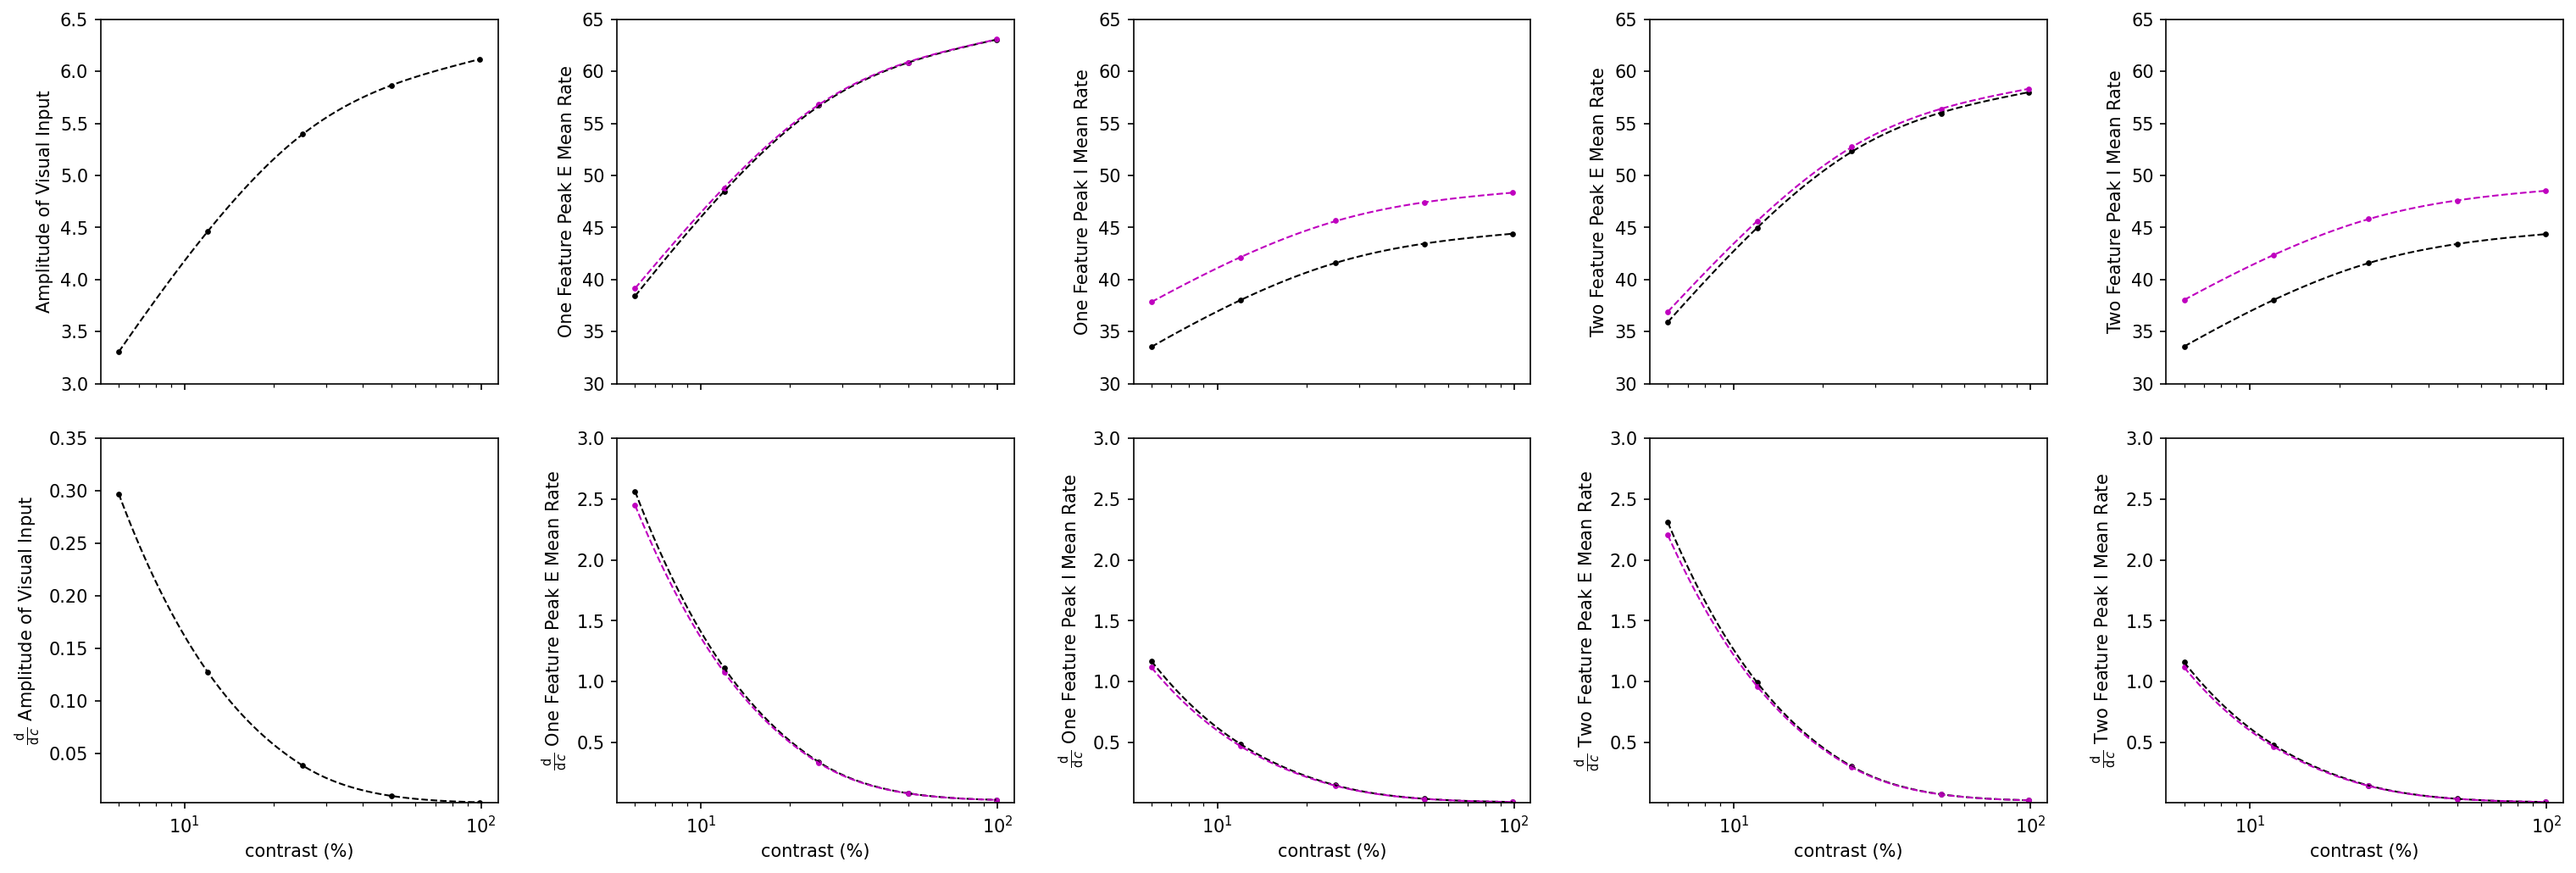

In [284]:
from scipy.interpolate import UnivariateSpline

fig,axs = plt.subplots(2,5,figsize=(25,8),dpi=150,sharex=True)
fig.subplots_adjust(hspace=0.15,wspace=0.3)

fine_log10cons = np.linspace(np.log10(cons[1]),np.log10(cons[-1]),101)

axs[0,0].scatter(cons[1:],aXs[1:],color='k',s=5)
itph = UnivariateSpline(np.log10(cons[1:]),aXs[1:],s=0.0001)
axs[0,0].plot(10**fine_log10cons,itph(fine_log10cons),'k--',lw=1)

axs[0,1].scatter(cons[1:],rvEs,color='k',s=5)
axs[0,2].scatter(cons[1:],rvIs,color='k',s=5)
itpvE = UnivariateSpline(np.log10(cons[1:]),[res_dict_inits[cidx]['rp'][0] for cidx in range(1,6)],s=0.01)
itpvI = UnivariateSpline(np.log10(cons[1:]),[res_dict_inits[cidx]['rp'][1] for cidx in range(1,6)],s=0.005)
axs[0,1].plot(10**fine_log10cons,itpvE(fine_log10cons),'k--',lw=1)
axs[0,2].plot(10**fine_log10cons,itpvI(fine_log10cons),'k--',lw=1)
axs[0,1].scatter(cons[1:],roEs,color='m',s=5)
axs[0,2].scatter(cons[1:],roIs,color='m',s=5)
itpoE = UnivariateSpline(np.log10(cons[1:]),[res_dict_perts[cidx]['rp'][0] for cidx in range(1,6)],s=0.01)
itpoI = UnivariateSpline(np.log10(cons[1:]),[res_dict_perts[cidx]['rp'][1] for cidx in range(1,6)],s=0.005)
axs[0,1].plot(10**fine_log10cons,itpoE(fine_log10cons),'m--',lw=1)
axs[0,2].plot(10**fine_log10cons,itpoI(fine_log10cons),'m--',lw=1)

axs[0,3].scatter(cons[1:],[res_dict_norm_inits[cidx]['rp'][0] for cidx in range(1,6)],color='k',s=5)
axs[0,4].scatter(cons[1:],[res_dict_norm_inits[cidx]['rp'][1] for cidx in range(1,6)],color='k',s=5)
itp2vE = UnivariateSpline(np.log10(cons[1:]),[res_dict_norm_inits[cidx]['rp'][0] for cidx in range(1,6)],s=0.01)
itp2vI = UnivariateSpline(np.log10(cons[1:]),[res_dict_norm_inits[cidx]['rp'][1] for cidx in range(1,6)],s=0.005)
axs[0,3].plot(10**fine_log10cons,itp2vE(fine_log10cons),'k--',lw=1)
axs[0,4].plot(10**fine_log10cons,itp2vI(fine_log10cons),'k--',lw=1)
axs[0,3].scatter(cons[1:],[res_dict_norm_perts[cidx]['rp'][0] for cidx in range(1,6)],color='m',s=5)
axs[0,4].scatter(cons[1:],[res_dict_norm_perts[cidx]['rp'][1] for cidx in range(1,6)],color='m',s=5)
itp2oE = UnivariateSpline(np.log10(cons[1:]),[res_dict_norm_perts[cidx]['rp'][0] for cidx in range(1,6)],s=0.01)
itp2oI = UnivariateSpline(np.log10(cons[1:]),[res_dict_norm_perts[cidx]['rp'][1] for cidx in range(1,6)],s=0.005)
axs[0,3].plot(10**fine_log10cons,itp2oE(fine_log10cons),'m--',lw=1)
axs[0,4].plot(10**fine_log10cons,itp2oI(fine_log10cons),'m--',lw=1)

ditph = itph.derivative()
ditpvE = itpvE.derivative()
ditpvI = itpvI.derivative()
ditpoE = itpoE.derivative()
ditpoI = itpoI.derivative()
ditp2vE = itp2vE.derivative()
ditp2vI = itp2vI.derivative()
ditp2oE = itp2oE.derivative()
ditp2oI = itp2oI.derivative()

axs[1,0].scatter(cons[1:],ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,0].plot(10**fine_log10cons,ditph(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)

axs[1,1].scatter(cons[1:],ditpvE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,1].plot(10**fine_log10cons,ditpvE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1,2].scatter(cons[1:],ditpvI(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,2].plot(10**fine_log10cons,ditpvI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1,1].scatter(cons[1:],ditpoE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1,1].plot(10**fine_log10cons,ditpoE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)
axs[1,2].scatter(cons[1:],ditpoI(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1,2].plot(10**fine_log10cons,ditpoI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

axs[1,3].scatter(cons[1:],ditp2vE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,3].plot(10**fine_log10cons,ditp2vE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1,4].scatter(cons[1:],ditp2vI(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,4].plot(10**fine_log10cons,ditp2vI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1,3].scatter(cons[1:],ditp2oE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1,3].plot(10**fine_log10cons,ditp2oE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)
axs[1,4].scatter(cons[1:],ditp2oI(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1,4].plot(10**fine_log10cons,ditp2oI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

axs[0,0].set_ylim(3,6.5)
axs[1,0].set_ylim(0.003,0.35)
for i in range(1,5):
    axs[0,i].set_ylim(30,65)
    axs[1,i].set_ylim(0.006,3)

for i in range(5):
    axs[1,i].set_xlabel('contrast (%)')
    axs[1,i].set_xscale('log')
    # axs[0,i].set_yscale('log')
    # axs[1,i].set_yscale('log')
    
axs[0,0].set_ylabel('Amplitude of Visual Input')
axs[0,1].set_ylabel('One Feature Peak E Mean Rate')
axs[0,2].set_ylabel('One Feature Peak I Mean Rate')
axs[0,3].set_ylabel('Two Feature Peak E Mean Rate')
axs[0,4].set_ylabel('Two Feature Peak I Mean Rate')
axs[1,0].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Amplitude of Visual Input')
axs[1,1].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ One Feature Peak E Mean Rate')
axs[1,2].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ One Feature Peak I Mean Rate')
axs[1,3].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Two Feature Peak E Mean Rate')
axs[1,4].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Two Feature Peak I Mean Rate')

Text(0, 0.5, '$\\frac{\\mathrm{d}}{\\mathrm{d}\\,c}$ Two Feature Peak E Mean Rate')

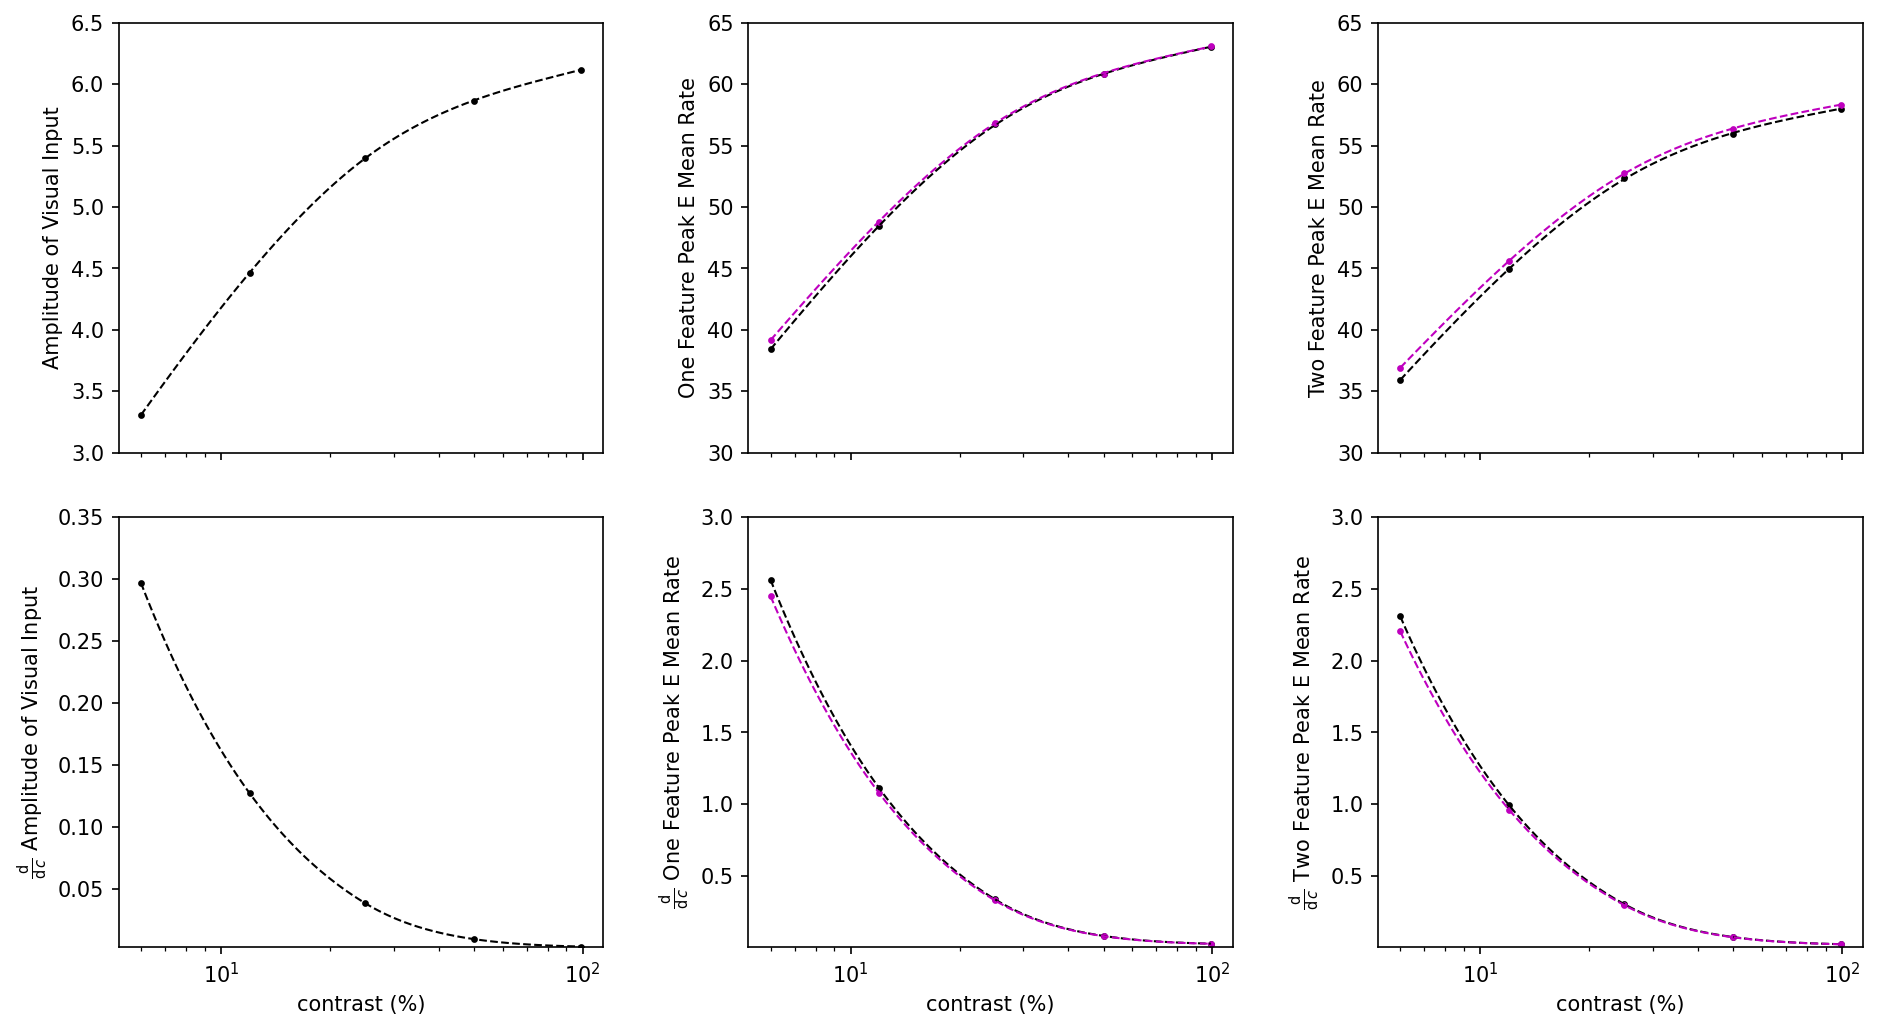

In [297]:
from scipy.interpolate import UnivariateSpline

fig,axs = plt.subplots(2,3,figsize=(15,8),dpi=150,sharex=True)
fig.subplots_adjust(hspace=0.15,wspace=0.3)

fine_log10cons = np.linspace(np.log10(cons[1]),np.log10(cons[-1]),101)

axs[0,0].scatter(cons[1:],aXs[1:],color='k',s=5)
axs[0,0].plot(10**fine_log10cons,itph(fine_log10cons),'k--',lw=1)

axs[0,1].scatter(cons[1:],rvEs,color='k',s=5)
axs[0,1].plot(10**fine_log10cons,itpvE(fine_log10cons),'k--',lw=1)
axs[0,1].scatter(cons[1:],roEs,color='m',s=5)
axs[0,1].plot(10**fine_log10cons,itpoE(fine_log10cons),'m--',lw=1)

axs[0,2].scatter(cons[1:],[res_dict_norm_inits[cidx]['rp'][0] for cidx in range(1,6)],color='k',s=5)
axs[0,2].plot(10**fine_log10cons,itp2vE(fine_log10cons),'k--',lw=1)
axs[0,2].scatter(cons[1:],[res_dict_norm_perts[cidx]['rp'][0] for cidx in range(1,6)],color='m',s=5)
axs[0,2].plot(10**fine_log10cons,itp2oE(fine_log10cons),'m--',lw=1)

axs[1,0].scatter(cons[1:],ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,0].plot(10**fine_log10cons,ditph(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)

axs[1,1].scatter(cons[1:],ditpvE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,1].plot(10**fine_log10cons,ditpvE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1,1].scatter(cons[1:],ditpoE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1,1].plot(10**fine_log10cons,ditpoE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

axs[1,2].scatter(cons[1:],ditp2vE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,2].plot(10**fine_log10cons,ditp2vE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1,2].scatter(cons[1:],ditp2oE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1,2].plot(10**fine_log10cons,ditp2oE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

axs[0,0].set_ylim(3,6.5)
axs[1,0].set_ylim(0.003,0.35)
for i in range(1,3):
    axs[0,i].set_ylim(30,65)
    axs[1,i].set_ylim(0.006,3)

for i in range(3):
    axs[1,i].set_xlabel('contrast (%)')
    axs[1,i].set_xscale('log')
    # axs[0,i].set_yscale('log')
    # axs[1,i].set_yscale('log')
    
axs[0,0].set_ylabel('Amplitude of Visual Input')
axs[0,1].set_ylabel('One Feature Peak E Mean Rate')
axs[0,2].set_ylabel('Two Feature Peak E Mean Rate')
axs[1,0].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Amplitude of Visual Input')
axs[1,1].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ One Feature Peak E Mean Rate')
axs[1,2].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Two Feature Peak E Mean Rate')

Text(0, 0.5, '$\\frac{\\mathrm{d}}{\\mathrm{d}\\,c}$ I Norm Weight')

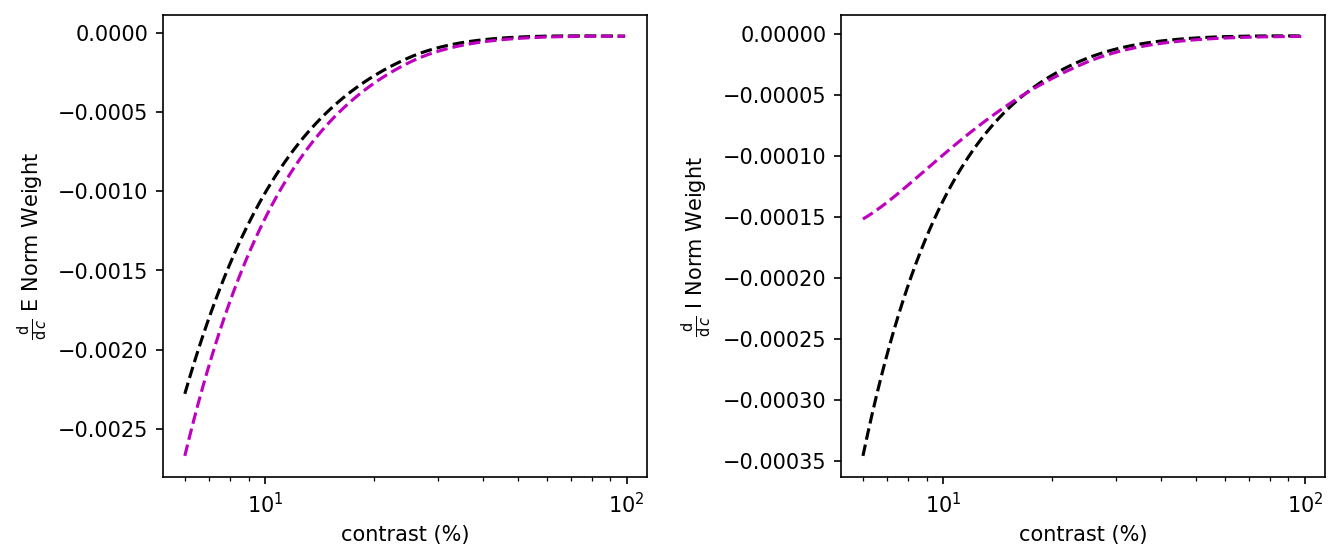

In [295]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150,sharex=True)
fig.subplots_adjust(hspace=0.15,wspace=0.4)

fine_rvEs = itpvE(fine_log10cons)
fine_rvIs = itpvI(fine_log10cons)
fine_roEs = itpoE(fine_log10cons)
fine_roIs = itpoI(fine_log10cons)
fine_r2vEs = itp2vE(fine_log10cons)
fine_r2vIs = itp2vI(fine_log10cons)
fine_r2oEs = itp2oE(fine_log10cons)
fine_r2oIs = itp2oI(fine_log10cons)

fine_drvEs = ditpvE(fine_log10cons)/(10**fine_log10cons*np.log(10))
fine_drvIs = ditpvI(fine_log10cons)/(10**fine_log10cons*np.log(10))
fine_droEs = ditpoE(fine_log10cons)/(10**fine_log10cons*np.log(10))
fine_droIs = ditpoI(fine_log10cons)/(10**fine_log10cons*np.log(10))
fine_dr2vEs = ditp2vE(fine_log10cons)/(10**fine_log10cons*np.log(10))
fine_dr2vIs = ditp2vI(fine_log10cons)/(10**fine_log10cons*np.log(10))
fine_dr2oEs = ditp2oE(fine_log10cons)/(10**fine_log10cons*np.log(10))
fine_dr2oIs = ditp2oI(fine_log10cons)/(10**fine_log10cons*np.log(10))

axs[0].plot(10**fine_log10cons,(fine_dr2vEs*fine_rvEs - fine_r2vEs*fine_drvEs)/fine_rvEs**2,'k--')
axs[0].plot(10**fine_log10cons,(fine_dr2oEs*fine_roEs - fine_r2oEs*fine_droEs)/fine_roEs**2,'m--')

axs[1].plot(10**fine_log10cons,(fine_dr2vIs*fine_rvIs - fine_r2vIs*fine_drvIs)/fine_rvIs**2,'k--')
axs[1].plot(10**fine_log10cons,(fine_dr2oIs*fine_roIs - fine_r2oIs*fine_droIs)/fine_roIs**2,'m--')

for i in range(2):
    axs[i].set_xlabel('contrast (%)')
    axs[i].set_xscale('log')
    
axs[0].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ E Norm Weight')
axs[1].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ I Norm Weight')

In [298]:
def calc_daX(res_dict,aX,npeaks=1):
    sr = res_dict['sr']
    sCr = res_dict['sCr'][:,-1]
    
    sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
    sW2 = sW**2
    sWr = np.sqrt(sW2+sr**2)
    sWCr = np.sqrt(sW2+sCr**2)

    muWbb = (1 - npeaks*dmft.struct_fact(180/2,sWr,sr,180)) * muW
    muWbp = npeaks*dmft.struct_fact(180/2,sWr,sr,180) * muW
    muWpb = (1 - dmft.struct_fact(0,sWr,sr,180) - (npeaks-1)*dmft.struct_fact(180/2,sWr,sr,180)) * muW
    muWpp = (dmft.struct_fact(0,sWr,sr,180) + (npeaks-1)*dmft.struct_fact(180/2,sWr,sr,180)) * muW

    SigWbb = (1 - npeaks*dmft.struct_fact(180/2,sWCr,sCr,180)) * SigW
    SigWbp = npeaks*dmft.struct_fact(180/2,sWCr,sCr,180) * SigW
    SigWpb = (1 - dmft.struct_fact(0,sWCr,sCr,180) - (npeaks-1)*dmft.struct_fact(180/2,sWCr,sCr,180)) * SigW
    SigWpp = (dmft.struct_fact(0,sWCr,sCr,180) + (npeaks-1)*dmft.struct_fact(180/2,sWCr,sCr,180)) * SigW

    bφ = np.array([MFL(res_dict['mub'][0],res_dict['Sigb'][0,0])[0],
                   MFI(res_dict['mub'][1],res_dict['Sigb'][1,0])[0]])
    bφp = np.array([MFPL(res_dict['mub'][0],res_dict['Sigb'][0,0])[0],
                    MFPI(res_dict['mub'][1],res_dict['Sigb'][1,0])[0]])
    bφpp = np.array([MFPPL(res_dict['mub'][0],res_dict['Sigb'][0,0])[0],
                     MFPPI(res_dict['mub'][1],res_dict['Sigb'][1,0])[0]])
    pφ = np.array([MFL(res_dict['mup'][0],res_dict['Sigp'][0,0])[0],
                   MFI(res_dict['mup'][1],res_dict['Sigp'][1,0])[0]])
    pφp = np.array([MFPL(res_dict['mup'][0],res_dict['Sigp'][0,0])[0],
                    MFPI(res_dict['mup'][1],res_dict['Sigp'][1,0])[0]])
    pφpp = np.array([MFPPL(res_dict['mup'][0],res_dict['Sigp'][0,0])[0],
                     MFPPI(res_dict['mup'][1],res_dict['Sigp'][1,0])[0]])

    bRφφ = np.array([[CFFL(res_dict['mub'][0],
                           res_dict['Sigb'][0,0],cov)[0] for cov in res_dict['Sigb'][0]],
                    [CFFI(res_dict['mub'][1],
                          res_dict['Sigb'][1,0],cov)[0] for cov in res_dict['Sigb'][1]]])
    bRφφp = np.array([[CFFPL(res_dict['mub'][0],
                             res_dict['Sigb'][0,0],cov)[0] for cov in res_dict['Sigb'][0]],
                    [CFFPI(res_dict['mub'][1],
                           res_dict['Sigb'][1,0],cov)[0] for cov in res_dict['Sigb'][1]]])
    bRφφpp = np.array([[CFFPPL(res_dict['mub'][0],
                            res_dict['Sigb'][0,0],cov)[0] for cov in res_dict['Sigb'][0]],
                    [CFFPPI(res_dict['mub'][1],
                            res_dict['Sigb'][1,0],cov)[0] for cov in res_dict['Sigb'][1]]])
    bRφpφp = np.array([[CFPFPL(res_dict['mub'][0],
                            res_dict['Sigb'][0,0],cov)[0] for cov in res_dict['Sigb'][0]],
                    [CFPFPI(res_dict['mub'][1],
                            res_dict['Sigb'][1,0],cov)[0] for cov in res_dict['Sigb'][1]]])
    pRφφ = np.array([[CFFL(res_dict['mup'][0],
                        res_dict['Sigp'][0,0],cov)[0] for cov in res_dict['Sigp'][0]],
                    [CFFI(res_dict['mup'][1],
                        res_dict['Sigp'][1,0],cov)[0] for cov in res_dict['Sigp'][1]]])
    pRφφp = np.array([[CFFPL(res_dict['mup'][0],
                            res_dict['Sigp'][0,0],cov)[0] for cov in res_dict['Sigp'][0]],
                    [CFFPI(res_dict['mup'][1],
                            res_dict['Sigp'][1,0],cov)[0] for cov in res_dict['Sigp'][1]]])
    pRφφpp = np.array([[CFFPPL(res_dict['mup'][0],
                            res_dict['Sigp'][0,0],cov)[0] for cov in res_dict['Sigp'][0]],
                    [CFFPPI(res_dict['mup'][1],
                            res_dict['Sigp'][1,0],cov)[0] for cov in res_dict['Sigp'][1]]])
    pRφpφp = np.array([[CFPFPL(res_dict['mup'][0],
                            res_dict['Sigp'][0,0],cov)[0] for cov in res_dict['Sigp'][0]],
                    [CFPFPI(res_dict['mup'][1],
                            res_dict['Sigp'][1,0],cov)[0] for cov in res_dict['Sigp'][1]]])

    bRφφpp = smooth_func(bRφφpp,dt)
    bRφpφp = smooth_func(bRφpφp,dt)
    pRφφpp = smooth_func(pRφφpp,dt)
    pRφpφp = smooth_func(pRφpφp,dt)

    Abb = np.eye(NP) - bφp[:,None] * muWbb
    Bbb = -0.5 * bφpp[:,None,None] * SigWbb[:,:,None] * δ[None,None,:]
    Cbb = -2 * bRφφp[:,:,None] * muWbb[:,None,:]
    Dbb = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
        - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:] +\
        - bRφpφp[:,:,None,None] * SigWbb[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
        - bRφφpp[:,:,None,None] * SigWbb[:,None,:,None] * δ[None,None,None,:]

    Abp = - bφp[:,None] * muWbp
    Bbp = -0.5 * bφpp[:,None,None] * SigWbp[:,:,None] * δ[None,None,:]
    Cbp = -2 * bRφφp[:,:,None] * muWbp[:,None,:]
    Dbp = - bRφpφp[:,:,None,None] * SigWbp[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
        - bRφφpp[:,:,None,None] * SigWbp[:,None,:,None] * δ[None,None,None,:]

    Apb = - pφp[:,None] * muWpb
    Bpb = -0.5 * pφpp[:,None,None] * SigWpb[:,:,None] * δ[None,None,:]
    Cpb = -2 * pRφφp[:,:,None] * muWpb[:,None,:]
    Dpb = - pRφpφp[:,:,None,None] * SigWpb[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
        - pRφφpp[:,:,None,None] * SigWpb[:,None,:,None] * δ[None,None,None,:]

    App = np.eye(NP) - pφp[:,None] * muWpp
    Bpp = -0.5 * pφpp[:,None,None] * SigWpp[:,:,None] * δ[None,None,:]
    Cpp = -2 * pRφφp[:,:,None] * muWpp[:,None,:]
    Dpp = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
        - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:] +\
        - pRφpφp[:,:,None,None] * SigWpp[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
        - pRφφpp[:,:,None,None] * SigWpp[:,None,:,None] * δ[None,None,None,:]
    
    D0dis = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
        - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:]
        
    muHp = (bX+aX)*K*J*np.array([hE,hI/beta],dtype=np.float32)
    
    dmuHpdξ = tau*K*J*np.array([hE,hI/beta],dtype=np.float32)
    dmuHbdξ = np.zeros_like(dmuHpdξ)
    dSigHpdξ = (2*muHp*dmuHpdξ*eH**2)[:,None]
    dSigHbdξ = np.zeros_like(dSigHpdξ)

    Eb = bφp * dmuHbdξ + 0.5 * bφpp * dSigHbdξ[:,0]
    Fb = 2 * bRφφp * dmuHbdξ[:,None] + bRφφpp * dSigHbdξ[:,0:1] + bRφpφp * dSigHbdξ

    Ep = pφp * dmuHpdξ + 0.5 * pφpp * dSigHpdξ[:,0]
    Fp = 2 * pRφφp * dmuHpdξ[:,None] + pRφφpp * dSigHpdξ[:,0:1] + pRφpφp * dSigHpdξ
    
    Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
    Mbp = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
    Mpb = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
    Mpp = np.block([[App,Bpp.reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])

    Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
    Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
    Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
    Mpp0dis = np.block([[App,np.zeros_like(Bpp).reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])

    fb = np.concatenate([Eb,Fb.flatten()])
    fp = np.concatenate([Ep,Fp.flatten()])

    M = np.block([[Mbb,Mbp],[Mpb,Mpp]])
    M0dis = np.block([[Mbb0dis,Mbp0dis],[Mpb0dis,Mpp0dis]])
    f = np.concatenate([fb,fp])

    δm = np.linalg.solve(M,f)
    δm0dis = np.linalg.solve(M0dis,f)

    δmb = δm[:NP+NP*NT]
    δmp = δm[NP+NP*NT:]

    δmb0dis = δm0dis[:NP+NP*NT]
    δmp0dis = δm0dis[NP+NP*NT:]

    δrb = δmb[:NP]
    δCrb = δmb[NP:].reshape(NP,NT)
    δrp = δmp[:NP]
    δCrp = δmp[NP:].reshape(NP,NT)

    δrb0dis = δmb0dis[:NP]
    δCrb0dis = δmb0dis[NP:].reshape(NP,NT)
    δrp0dis = δmp0dis[:NP]
    δCrp0dis = δmp0dis[NP:].reshape(NP,NT)
    
    res_dict = {}
    
    res_dict['drb'] = δrb
    res_dict['drp'] = δrp
    res_dict['dCrb'] = δCrb
    res_dict['dCrp'] = δCrp
    res_dict['drb0dis'] = δrb0dis
    res_dict['drp0dis'] = δrp0dis
    res_dict['dCrb0dis'] = δCrb0dis
    res_dict['dCrp0dis'] = δCrp0dis
    
    return res_dict

In [299]:
res_dict_daX_inits = [None]*6
res_dict_daX_perts = [None]*6
res_dict_daX_norm_inits = [None]*6
res_dict_daX_norm_perts = [None]*6

for c_idx in range(1,6):
    res_dict_daX_inits[c_idx] = calc_daX(res_dict_inits[c_idx],aXs[c_idx],1)
    res_dict_daX_perts[c_idx] = calc_daX(res_dict_perts[c_idx],aXs[c_idx],1)
    res_dict_daX_norm_inits[c_idx] = calc_daX(res_dict_norm_inits[c_idx],aXs[c_idx],2)
    res_dict_daX_norm_perts[c_idx] = calc_daX(res_dict_norm_perts[c_idx],aXs[c_idx],2)

Text(0, 0.5, '$\\frac{\\mathrm{d}}{\\mathrm{d}\\,c}$ Two Feature Peak I Mean Rate')

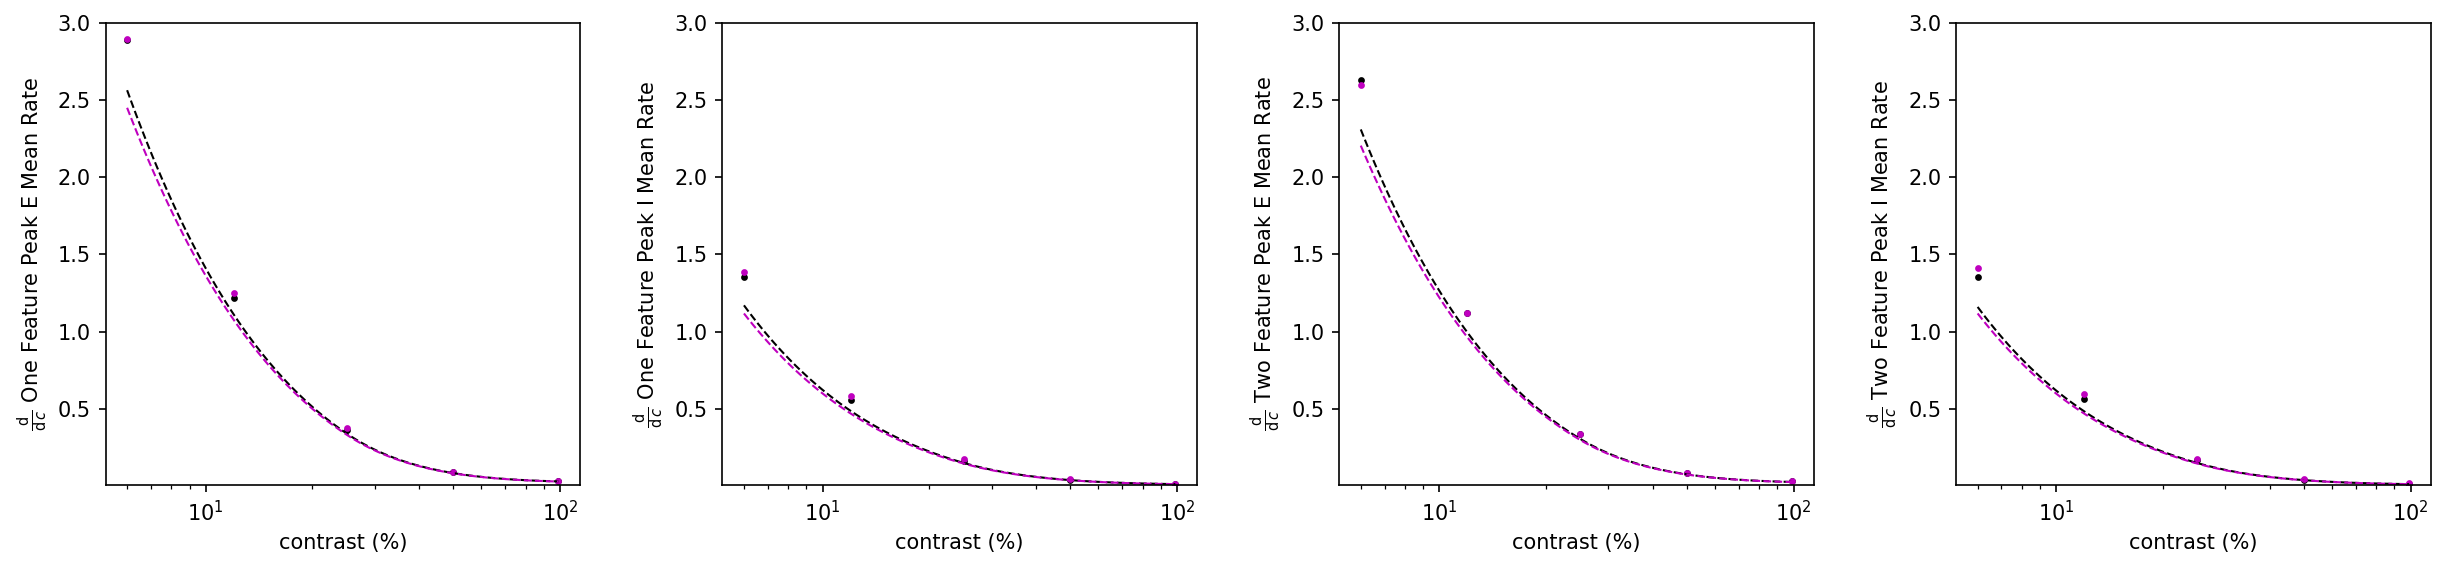

In [300]:
from scipy.interpolate import UnivariateSpline

fig,axs = plt.subplots(1,4,figsize=(20,4),dpi=150,sharex=True)
fig.subplots_adjust(hspace=0.15,wspace=0.3)

fine_log10cons = np.linspace(np.log10(cons[1]),np.log10(cons[-1]),101)

axs[0].scatter(cons[1:],[res_dict_daX_inits[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[0].plot(10**fine_log10cons,ditpvE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1].scatter(cons[1:],[res_dict_daX_inits[cidx]['drp'][1] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1].plot(10**fine_log10cons,ditpvI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[0].scatter(cons[1:],[res_dict_daX_perts[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[0].plot(10**fine_log10cons,ditpoE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)
axs[1].scatter(cons[1:],[res_dict_daX_perts[cidx]['drp'][1] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1].plot(10**fine_log10cons,ditpoI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

axs[2].scatter(cons[1:],[res_dict_daX_norm_inits[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[2].plot(10**fine_log10cons,ditp2vE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[3].scatter(cons[1:],[res_dict_daX_norm_inits[cidx]['drp'][1] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[3].plot(10**fine_log10cons,ditp2vI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[2].scatter(cons[1:],[res_dict_daX_norm_perts[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[2].plot(10**fine_log10cons,ditp2oE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)
axs[3].scatter(cons[1:],[res_dict_daX_norm_perts[cidx]['drp'][1] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[3].plot(10**fine_log10cons,ditp2oI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

for i in range(4):
    axs[i].set_ylim(0.006,3)

for i in range(4):
    axs[i].set_xlabel('contrast (%)')
    axs[i].set_xscale('log')
    # axs[i].set_yscale('log')
    
axs[0].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ One Feature Peak E Mean Rate')
axs[1].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ One Feature Peak I Mean Rate')
axs[2].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Two Feature Peak E Mean Rate')
axs[3].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Two Feature Peak I Mean Rate')

Text(0, 0.5, '$\\frac{\\mathrm{d}}{\\mathrm{d}\\,c}$ Two Feature Peak E Mean Rate')

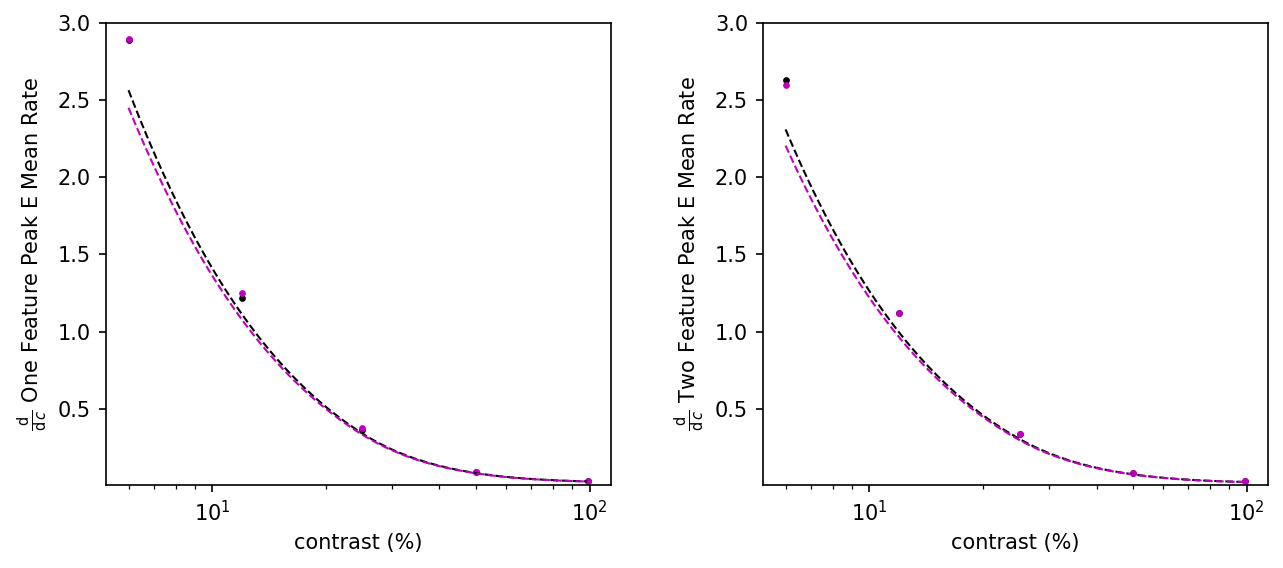

In [301]:
from scipy.interpolate import UnivariateSpline

fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150,sharex=True)
fig.subplots_adjust(hspace=0.15,wspace=0.3)

fine_log10cons = np.linspace(np.log10(cons[1]),np.log10(cons[-1]),101)

axs[0].scatter(cons[1:],[res_dict_daX_inits[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[0].plot(10**fine_log10cons,ditpvE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[0].scatter(cons[1:],[res_dict_daX_perts[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[0].plot(10**fine_log10cons,ditpoE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

axs[1].scatter(cons[1:],[res_dict_daX_norm_inits[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1].plot(10**fine_log10cons,ditp2vE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1].scatter(cons[1:],[res_dict_daX_norm_perts[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1].plot(10**fine_log10cons,ditp2oE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

for i in range(2):
    axs[i].set_ylim(0.006,3)

for i in range(2):
    axs[i].set_xlabel('contrast (%)')
    axs[i].set_xscale('log')
    # axs[i].set_yscale('log')
    
axs[0].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ One Feature Peak E Mean Rate')
axs[1].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Two Feature Peak E Mean Rate')

In [287]:
print([res_dict_daX_inits[cidx]['drp'][0] for cidx in range(1,6)])
print([res_dict_daX_perts[cidx]['drp'][0] for cidx in range(1,6)])
print()
print([res_dict_daX_inits[cidx]['drp0dis'][0] for cidx in range(1,6)])
print([res_dict_daX_perts[cidx]['drp0dis'][0] for cidx in range(1,6)])

[9.716188376337183, 9.595765642886352, 9.450252483537822, 9.361476043782794, 9.310884632876922]
[9.734781763677965, 9.834311789949867, 9.769216463995066, 9.707823557006135, 9.675188243004653]

[10.996916755133434, 10.89911889225987, 10.748346382580669, 10.648209393970129, 10.587859385455193]
[10.402630549919259, 10.638202549550808, 10.651004881954188, 10.620418974076332, 10.596011318270746]


In [283]:
print([res_dict_daX_norm_inits[cidx]['drp'][0] for cidx in range(1,6)])
print([res_dict_daX_norm_perts[cidx]['drp'][0] for cidx in range(1,6)])

[9.767682523161165, 9.720678633029049, 9.597491762186237, 9.548035915568775, 9.491960565316445]
[9.663186647968342, 9.818063381336831, 9.808715558374336, 9.78670640504124, 9.765681489259135]


# Miscellaneous

In [319]:
with open('./../results/'+'itp_ranges'+'.pkl', 'rb') as handle:
    ranges_dict = pickle.load(handle)

In [414]:
from scipy.special import erf, erfi, erfcx, dawsn
from mpmath import fp

def int_dawsni_scal(x):
    return -0.5*x**2*fp.hyp2f2(1.0,1.0,1.5,2.0,x**2)
int_dawsni = np.vectorize(int_dawsni_scal)

sr2 = np.sqrt(2)
sr2pi = np.sqrt(2*np.pi)
srpi = np.sqrt(np.pi)

u = np.linspace(-0.1,0.2,401)
min_u = (ri.Vr-u)/ri.st
max_u = (ri.tht-u)/ri.st

r = np.zeros_like(u);

for idx in range(len(u)):
    if(min_u[idx]>3):
        r[idx]=max_u[idx]/ri.tE/ric.srpi*np.exp(-max_u[idx]**2)
    elif(min_u[idx]>-5):
        r[idx]=1.0/(ri.trp+ri.tE*(0.5*np.pi*\
                            (erfi(max_u[idx]) - erfi(min_u[idx])) +
                            -2*(int_dawsni(max_u[idx]) - int_dawsni(min_u[idx]))))
    else:
        r[idx]=1.0/(ri.trp+ri.tE*(np.log(abs(min_u[idx])) -
                                np.log(abs(max_u[idx])) +
                            (0.25*min_u[idx]**-2 - 0.1875*min_u[idx]**-4 +
                            0.3125*min_u[idx]**-6 - 0.8203125*min_u[idx]**-8 +
                            2.953125*min_u[idx]**-10) -
                            (0.25*max_u[idx]**-2 - 0.1875*max_u[idx]**-4 +
                            0.3125*max_u[idx]**-6 - 0.8203125*max_u[idx]**-8 +
                            2.953125*max_u[idx]**-10)))

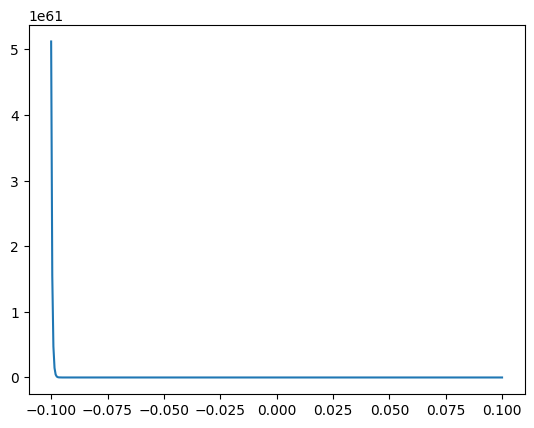

In [396]:
plt.plot(u,0.5*np.pi*erfi(max_u) - 2*int_dawsni(max_u))

In [378]:
erfi(-1)

-1.6504257587975428

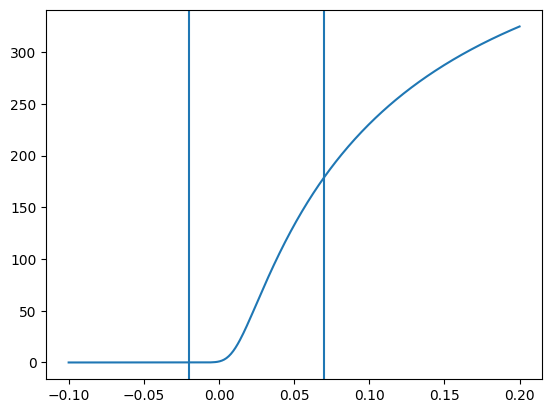

In [415]:
plt.plot(u,r)
plt.axvline(ri.Vr-3*ri.st)
plt.axvline(ri.Vr+6*ri.st)

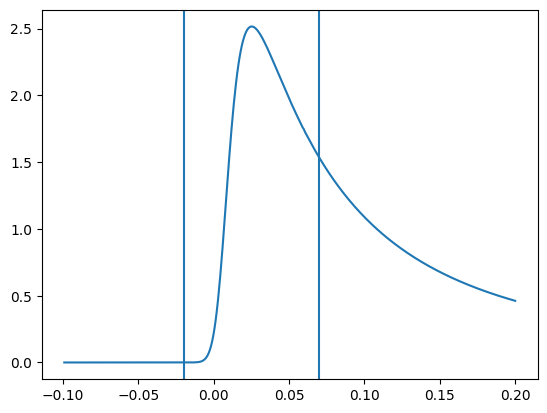

In [416]:
plt.plot(u[1:],r[1:]-r[:-1])
plt.axvline(ri.Vr-3*ri.st)
plt.axvline(ri.Vr+6*ri.st)

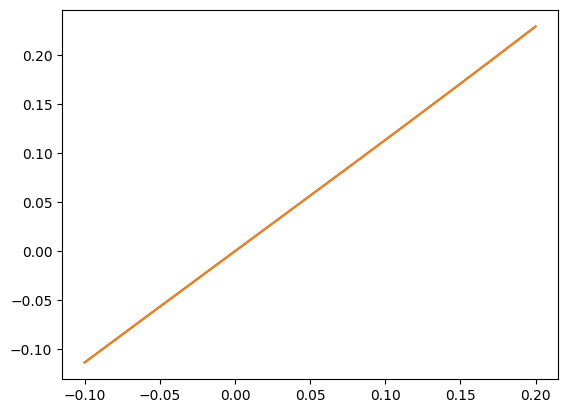

In [407]:
plt.plot(u,erfi(u))
plt.plot(u,2/srpi*(dawsn(u)*np.exp(u**2)))

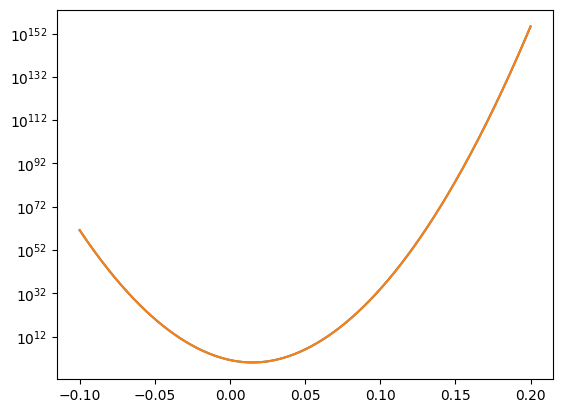

In [409]:
plt.plot(u,erfi((ri.tht-u)/ri.st) - erfi((ri.Vr-u)/ri.st))
plt.plot(u,2/srpi*(dawsn((ri.tht-u)/ri.st)*np.exp(((ri.tht-u)/ri.st)**2)-\
    dawsn((ri.Vr-u)/ri.st)*np.exp(((ri.Vr-u)/ri.st)**2)))
plt.yscale('log')

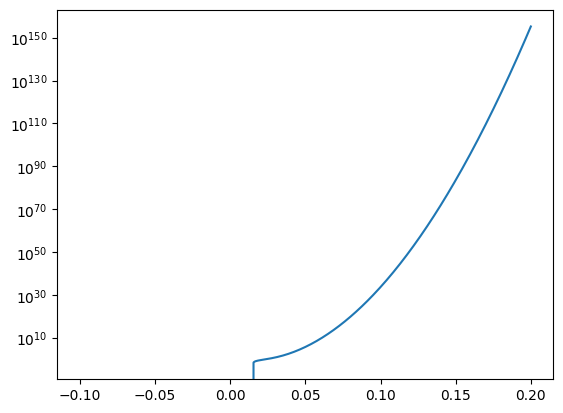

In [410]:
plt.plot(u,int_dawsni(max_u) - int_dawsni(min_u))
plt.yscale('log')

In [385]:
int_dawsni(u)

array([-5.01671121e-03, -4.96650404e-03, -4.91655187e-03, -4.86685462e-03,
       -4.81741225e-03, -4.76822472e-03, -4.71929198e-03, -4.67061396e-03,
       -4.62219063e-03, -4.57402194e-03, -4.52610784e-03, -4.47844827e-03,
       -4.43104320e-03, -4.38389257e-03, -4.33699634e-03, -4.29035446e-03,
       -4.24396688e-03, -4.19783356e-03, -4.15195444e-03, -4.10632949e-03,
       -4.06095866e-03, -4.01584190e-03, -3.97097917e-03, -3.92637041e-03,
       -3.88201560e-03, -3.83791467e-03, -3.79406760e-03, -3.75047432e-03,
       -3.70713481e-03, -3.66404902e-03, -3.62121689e-03, -3.57863840e-03,
       -3.53631349e-03, -3.49424213e-03, -3.45242427e-03, -3.41085987e-03,
       -3.36954889e-03, -3.32849129e-03, -3.28768702e-03, -3.24713605e-03,
       -3.20683833e-03, -3.16679383e-03, -3.12700250e-03, -3.08746430e-03,
       -3.04817920e-03, -3.00914715e-03, -2.97036812e-03, -2.93184206e-03,
       -2.89356894e-03, -2.85554872e-03, -2.81778136e-03, -2.78026682e-03,
       -2.74300507e-03, -

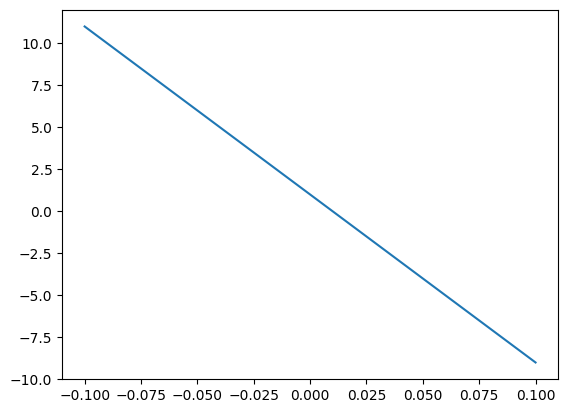

In [386]:
plt.plot(u,min_u)

In [417]:
oris = np.arange(20)/20 * 180
doris = oris[:,None] - oris[None,:]

In [431]:
kerns = dmft.wrapnormdens(doris[:,:,None,None],sW[None,None,:,:])
# kerns /= np.sum(kerns,1,keepdims=True)

In [443]:
np.sum(kerns[:,:,0,1],-1)[0]*2*np.pi/20

0.9999999999999998

In [447]:
np.sum(muW[None,None,:,:]*2*np.pi*kerns,1)[:,0,0]

array([0.03126955, 0.03126955, 0.03126955, 0.03126955, 0.03126955,
       0.03126955, 0.03126955, 0.03126955, 0.03126955, 0.03126955,
       0.03126955, 0.03126955, 0.03126955, 0.03126955, 0.03126955,
       0.03126955, 0.03126955, 0.03126955, 0.03126955, 0.03126955])

In [534]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/5

res_dict_decoup_ring = dmft.run_decoupled_ring_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,struct_dict=res_dict_init,which='opto',return_full=True)

0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
0.20% completed
0.40% completed


KeyboardInterrupt: 

In [562]:
Nori = 20

tau = np.array([ri.tE,ri.tI],dtype=np.float32)
W = J*np.array([[1,-gE],[1./beta,-gI/beta]],dtype=np.float32)
Ks = np.array([K,K/4],dtype=np.float32)
Hb = bX*K*J*np.array([hE,hI/beta],dtype=np.float32)
Hp = (bX+aXs[-1])*K*J*np.array([hE,hI/beta],dtype=np.float32)
eH = eX
sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
sH = np.array([SoriF,SoriF],dtype=np.float32)

oris = np.arange(Nori)/Nori * 180
doris = oris[:,None] - oris[None,:]
kerns = dmft.wrapnormdens(doris[:,:,None,None],sW[None,None,:,:])

muWs = (muW[None,None,:,:]*2*np.pi*kerns) / Nori
SigWs = (SigW[None,None,:,:]*2*np.pi*kerns) / Nori

rs = res_dict_init['rb'][None,:] + (res_dict_init['rp']-res_dict_init['rb'])[None,:]*\
    dmft.basesubwrapnorm(oris[:,None],sr[None,:])
Crs = res_dict_init['Crb'][None,:,:] + (res_dict_init['Crp']-res_dict_init['Crb'])[None,:,:]*\
    dmft.basesubwrapnorm(oris[:,None,None],sCr[None,:,None])

muHs = tau[None,:]*(Hb[None,:] + (Hp-Hb)[None,:]*dmft.basesubwrapnorm(oris[:,None],sH[None,:]))
SigHs = ((tau[None,:]*(Hb[None,:] + (Hp-Hb)[None,:]*dmft.basesubwrapnorm(oris[:,None],sH[None,:]))*eH)**2)[:,:,None]

mus = muHs + np.einsum('ijkl,jl->ik',muWs,rs)
Sigs = SigHs + np.einsum('ijkl,jlm->ikm',SigWs,Crs)

dmuHdξs = (tau*K*J*np.array([hE,hI/beta],dtype=np.float32))[None,:]*np.ones(Nori)[:,None]
dSigHdξs = (2*muHs*dmuHdξs*eH**2)[:,:,None]

In [569]:
φs = np.zeros_like(rs)
φps = np.zeros_like(rs)
φpps = np.zeros_like(rs)
Rφφs = np.zeros_like(Crs)
Rφφps = np.zeros_like(Crs)
Rφφpps = np.zeros_like(Crs)
Rφpφps = np.zeros_like(Crs)

for i in range(Nori):
    φs[i] = np.array([MFE(mus[i,0],Sigs[i,0,0])[0],MFI(mus[i,1],Sigs[i,1,0])[0]])
    φps[i] = np.array([MFPE(mus[i,0],Sigs[i,0,0])[0],MFPI(mus[i,1],Sigs[i,1,0])[0]])
    φpps[i] = np.array([MFPPE(mus[i,0],Sigs[i,0,0])[0],MFPPI(mus[i,1],Sigs[i,1,0])[0]])

    Rφφs[i] = np.array([[CFFE(mus[i,0],Sigs[i,0,0],cov)[0] for cov in Sigs[i,0]],
                        [CFFI(mus[i,1],Sigs[i,1,0],cov)[0] for cov in Sigs[i,1]]])
    Rφφps[i] = np.array([[CFFPE(mus[i,0],Sigs[i,0,0],cov)[0] for cov in Sigs[i,0]],
                         [CFFPI(mus[i,1],Sigs[i,1,0],cov)[0] for cov in Sigs[i,1]]])
    Rφφpps[i] = np.array([[CFFPPE(mus[i,0],Sigs[i,0,0],cov)[0] for cov in Sigs[i,0]],
                          [CFFPPI(mus[i,1],Sigs[i,1,0],cov)[0] for cov in Sigs[i,1]]])
    Rφpφps[i] = np.array([[CFPFPE(mus[i,0],Sigs[i,0,0],cov)[0] for cov in Sigs[i,0]],
                          [CFPFPI(mus[i,1],Sigs[i,1,0],cov)[0] for cov in Sigs[i,1]]])

    Rφφpps[i] = smooth_func(Rφφpps[i],dt)
    Rφpφps[i] = smooth_func(Rφpφps[i],dt)

(0.0, 65.93273651060026)

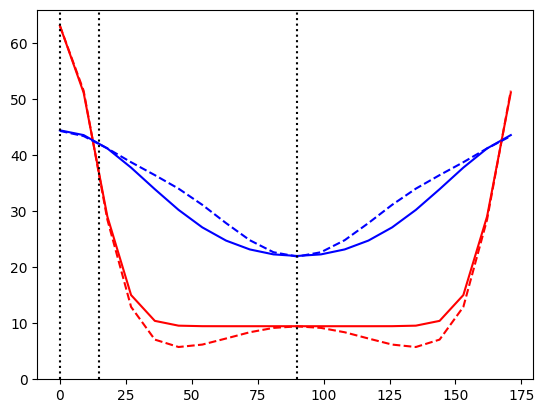

In [607]:
plt.plot(oris,rs[:,0],'r')
plt.plot(oris,rs[:,1],'b')
plt.plot(oris,φs[:,0],'r--')
plt.plot(oris,φs[:,1],'b--')
plt.axvline(0,c='k',ls=':')
plt.axvline(15,c='k',ls=':')
plt.axvline(90,c='k',ls=':')

plt.ylim(0,None)

In [589]:
As = np.eye(Nori)[:,:,None,None]*np.eye(NP)[None,None,:,:] - φps[:,None,:,None] * muWs
Bs = -0.5 * φpps[:,None,:,None,None] * SigWs[:,:,:,:,None] * δ[None,None,None,None,:]
Cs = -2 * Rφφps[:,None,:,:,None] * muWs[:,:,:,None,:]
Ds = np.eye(Nori)[:,:,None,None,None,None]*(np.eye(NP)[None,None,:,None,:,None]*np.eye(NT)[None,None,None,:,None,:] +\
    - np.diag(tau**2)[None,None,:,None,:,None] * L[None,None,None,:,None,:] +\
        dt*np.diag(tau)[None,None,:,None,:,None] * L[None,None,None,:,None,:]) +\
    - Rφpφps[:,None,:,:,None,None] * SigWs[:,:,:,None,:,None] * np.eye(NT)[None,None,None,:,None,:] +\
    - Rφφpps[:,None,:,:,None,None] * SigWs[:,:,:,None,:,None] * δ[None,None,None,None,None,:]
    
Es = φps * dmuHdξs + 0.5 * φpps * dSigHdξs[:,:,0]
Fs = 2 * Rφφps * dmuHdξs[:,:,None] + Rφφpps * dSigHdξs[:,:,0:1] + Rφpφps * dSigHdξs

In [602]:
Ms = np.zeros((Nori,Nori,NP*(NT+1),NP*(NT+1)))
fs = np.zeros((Nori,NP*(NT+1)))

for i in range(Nori):
    fs[i] = np.concatenate([Es[i],Fs[i].flatten()])
    for j in range(Nori):
        Ms[i,j] = np.block([[As[i,j],np.zeros_like(Bs[i,j]).reshape(NP,NP*NT)],[Cs[i,j].reshape(NP*NT,NP),Ds[i,j].reshape(NP*NT,NP*NT)]])

In [603]:
dmdξs = np.linalg.solve(Ms.transpose(0,2,1,3).reshape(Nori*NP*(NT+1),Nori*NP*(NT+1)),fs.flatten()).reshape(Nori,NP*(NT+1))

In [604]:
drdξs = np.zeros_like(rs)
for i in range(Nori):
    drdξs[i] = dmdξs[i,:2]

(0.0, 5.589520807400232)

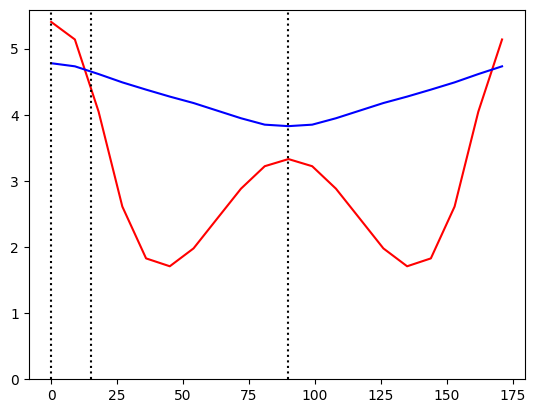

In [606]:
plt.plot(oris,drdξs[:,0],'r')
plt.plot(oris,drdξs[:,1],'b')
plt.axvline(0,c='k',ls=':')
plt.axvline(15,c='k',ls=':')
plt.axvline(90,c='k',ls=':')

plt.ylim(0,None)

(0.0, 71.59365366040498)

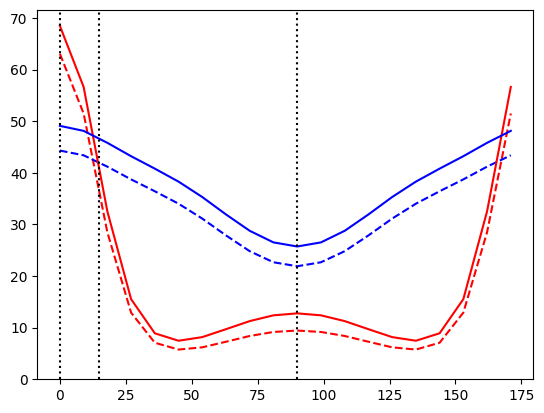

In [610]:
plt.plot(oris,φs[:,0],'r')
plt.plot(oris,φs[:,0],'r:')
# plt.plot(oris,φs[:,1],'b--')
plt.plot(oris,φs[:,0]+0.5*drdξs[:,0],'r--')
# plt.plot(oris,φs[:,1]+1*drdξs[:,1],'b')
plt.axvline(0,c='k',ls=':')
plt.axvline(15,c='k',ls=':')
plt.axvline(90,c='k',ls=':')

plt.ylim(0,None)

In [583]:
(-0.5 * φpps[:,None,:,None,None] * SigWs[:,:,:,:,None] * δ[None,None,None,None,:]).shape

(20, 20, 2, 2, 201)

In [612]:
δrX = 0.5

res_dict_pert = dmft.run_first_stage_ring_dmft(prms,bX+δrX,aXs[-1]/(bX+δrX),eX,'./../results',ri,Twrm,Tsav,dt,which='base',return_full=True)

0.20% completed


/Users/tuannguyen/ToroidalNetworks/sparse_weights/notebooks/./../scripts/dmft.py:701: RuntimeWarning: invalid value encountered in divide
  sCrij = solve_width((Craij-Crbij)/(Crpij-Crbij))


0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 631.884438 s


In [613]:
pert_rs = res_dict_init['rb'][None,:] + (res_dict_init['rp']-res_dict_init['rb'])[None,:]*\
    dmft.basesubwrapnorm(oris[:,None],sr[None,:])
pert_Crs = res_dict_init['Crb'][None,:,:] + (res_dict_init['Crp']-res_dict_init['Crb'])[None,:,:]*\
    dmft.basesubwrapnorm(oris[:,None,None],sCr[None,:,None])

In [ ]:
pert_φs = np.zeros_like(rs)

for i in range(Nori):
    pert_φs[i] = np.array([MFE(mus[i,0],Sigs[i,0,0])[0],MFI(mus[i,1],Sigs[i,1,0])[0]])

In [155]:
reload(dmft)

full_ring_res_dict = dmft.run_first_stage_full_ring_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,0.8,0.2,0.01/3,Nori=4,which='both',return_full=True)

0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 73.31788299999971 s


In [137]:
reload(dmft)

diff_full_ring_res_dict = dmft.run_second_stage_full_ring_dmft(full_ring_res_dict,prms,bX,aXs[-1]/bX,eX,'./../results',ri,0.8,0.2,0.01/3,Nori=4,return_full=True)

0.05% completed
0.10% completed
0.15% completed
0.20% completed
0.25% completed
0.30% completed
0.35% completed
0.40% completed
0.45% completed
0.50% completed
0.55% completed
0.60% completed
0.65% completed
0.70% completed
0.75% completed
0.80% completed
0.85% completed
0.90% completed
0.95% completed
1.00% completed
integrating second stage took 978.1103479999997 s


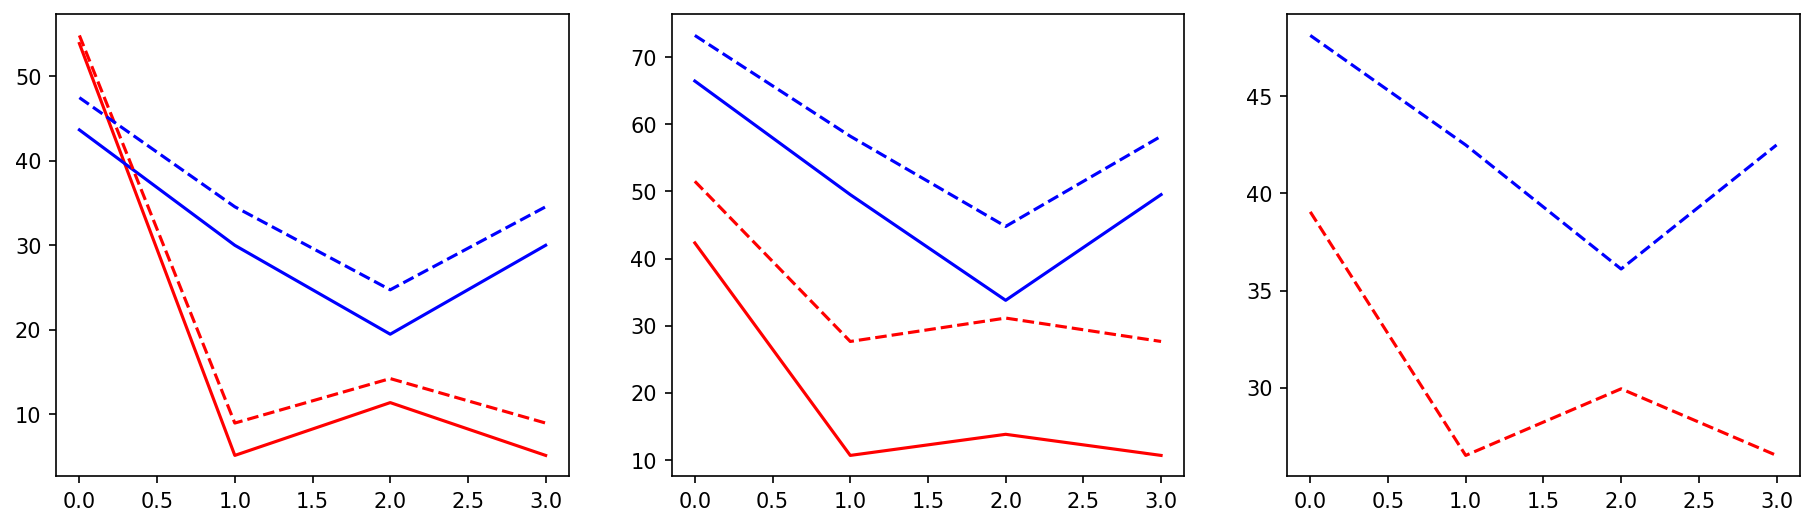

In [142]:
fig,axs = plt.subplots(1,3,figsize=(15,4),dpi=150)

axs[0].plot(full_ring_res_dict['rs'][:,0],'r')
axs[0].plot(full_ring_res_dict['rs'][:,1],'b')
axs[0].plot(full_ring_res_dict['rs'][:,2],'r--')
axs[0].plot(full_ring_res_dict['rs'][:,3],'b--')

axs[1].plot(np.sqrt(full_ring_res_dict['Crs'][:,0,-1]-full_ring_res_dict['rs'][:,0]**2),'r')
axs[1].plot(np.sqrt(full_ring_res_dict['Crs'][:,1,-1]-full_ring_res_dict['rs'][:,1]**2),'b')
axs[1].plot(np.sqrt(full_ring_res_dict['Crs'][:,2,-1]-full_ring_res_dict['rs'][:,2]**2),'r--')
axs[1].plot(np.sqrt(full_ring_res_dict['Crs'][:,3,-1]-full_ring_res_dict['rs'][:,3]**2),'b--')

axs[2].plot(np.sqrt(diff_full_ring_res_dict['Cdrs'][:,0,-1]-diff_full_ring_res_dict['drs'][:,0]**2),'r--')
axs[2].plot(np.sqrt(diff_full_ring_res_dict['Cdrs'][:,1,-1]-diff_full_ring_res_dict['drs'][:,1]**2),'b--')